In [33]:
### INTEGRATED ANALYSIS 3: GENOMIC VS CLINICAL VARIABLES IN THE MMRp GROUP OF SAMPLES ################

# Import libraries to work 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# I read the file containing the samples with all type of data available: gold standard results+genomic+clinical+TILs
path='/home/vant/TFM/Final_db/Samples_alltypedata_annotated.xlsx'  
df=pd.read_excel(path)
# See dataframe characteristics (columns names, type of values and number of null values in each column)
print(df.info()) 

######## Firstly we reclassify misclassified samples to redo the analysis  #######################

# Change the values to 'MMRp' for samples 'LP20', 'LP26', and 'MDA15'
# We use .loc[] to access specific rows where 'ID_CNIO' matches one of the specified samples
df.loc[df['ID_CNIO'].isin(['LP20', 'LP26', 'MDA15']), 'MMR_final_status'] = 'MMRp'

# Change the values to 'MMRd' for samples 'MDA26' and 'OVE28'. 'OVE28' is not misclassified according Diego's previous work
df.loc[df['ID_CNIO'].isin(['MDA26']), 'MMR_final_status'] = 'MMRd'

# Eliminate mixed case
df=df[df['ID_CNIO']!='RVB3']

 # Create a new DataFrame without the first two rows that only contain the descriptive and coding information
df = df.iloc[2:].reset_index(drop=True)

##### FACILITATE THE INTERPRETATION OF HISTOLOGY,FIGOL,GRADE AND RESIDUALa COLUMNS ##############

# Mapping dictionary for HISTOLOGY
category_mapping = {0: 'EOC', 1: 'CCOC', 2: 'Mixed', 3: 'Others'}

# Replace values in HISTOLOGY
df['HISTOLOGY'] = df['HISTOLOGY'].map(category_mapping)

# Mapping representative categories for FIGOL
df.loc[:,'FIGOL'] = df['FIGOL'].map({0: 'Localized', 1: 'Advanced'})

# Mapping GRADE values using .loc and convert it to a categorical type with a specific order
df.loc[:, 'GRADE'] = df['GRADE'].map({
    1: 'Well differentiated', 
    2: 'Moderately differentiated', 
    3: 'Poorly differentiated'
})
# Mapping representative categories for RESIDUALa
df.loc[:, 'RESIDUALa'] = df['RESIDUALa'].map({0: 'No', 1: 'Yes'})

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169 entries, 0 to 168
Data columns (total 56 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   ID_CNIO                    169 non-null    object
 1   ID_ORIGINAL                165 non-null    object
 2   ID_ORIGINAL_NHC_BBANK      149 non-null    object
 3   HISTOLOGY                  169 non-null    object
 4   HISTOLOGY_DETAIL           169 non-null    object
 5   AGE                        169 non-null    object
 6   GRADE                      134 non-null    object
 7   FIGO                       163 non-null    object
 8   FIGOL                      163 non-null    object
 9   FIGOa                      163 non-null    object
 10  NEOADJUVANT_TREATMENT      113 non-null    object
 11  ADJUVANT_TREATMENT         154 non-null    object
 12  TYPE_ADJUVANT              123 non-null    object
 13  OTHER_ADJ_TREAT            9 non-null      object
 14  RESIDUAL  

In [34]:
# Filter the dataframe to obtain the filtered dataframes to work
### Dataframes with all samples (EOC+CC), EOC samples and CC samples including only MMRp cases 
df_all_mmrp=df[df['MMR_final_status']=='MMRp']
df_eoc_mmrp=df[(df['HISTOLOGY']=='EOC') & (df['MMR_final_status']=='MMRp')]
df_cc_mmrp=df[(df['HISTOLOGY']=='CCOC') & (df['MMR_final_status']=='MMRp')]
# Verify the number of samples in every category ALL MMRp, EOC MMRp and CC MMRp
print("Number of MMRp samples:", len(df_all_mmrp))
print("Number of MMRp EOC samples:", len(df_eoc_mmrp))
print("Number of MMRp CCOC samples:", len(df_cc_mmrp))

Number of MMRp samples: 149
Number of MMRp EOC samples: 77
Number of MMRp CCOC samples: 72


Number of samples in each category:
Localized: 103
Advanced: 41
Shapiro-Wilk test for Localized: W=0.2889, p-value=0.0000
Shapiro-Wilk test for Advanced: W=0.3364, p-value=0.0000
Levene's test: W=0.1311, p-value=0.7179


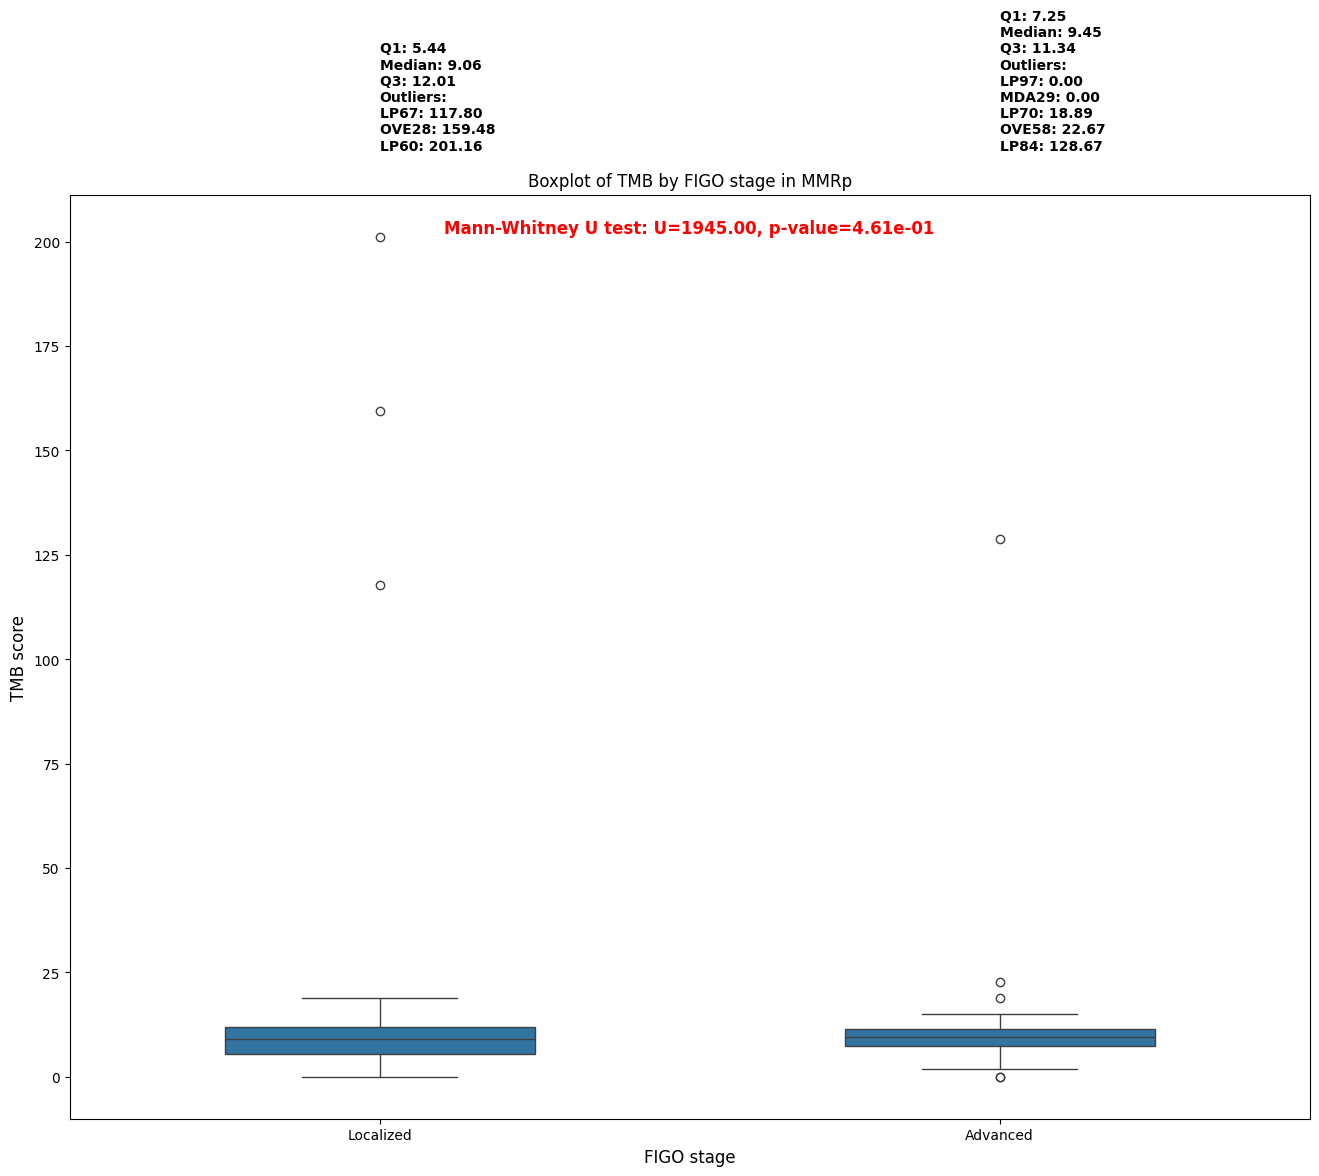

In [35]:
#### Analysis of statistics and distribution of TMB values in FIGOL categories in the MMRp entire cohort ########

# Import necessary libraries
import seaborn as sns  # Library for statistical data visualization
from scipy.stats import shapiro  # Function to test normality of data (Shapiro-Wilk test)
from scipy.stats import levene  # Function to test equality of variances (Levene's test)
from scipy.stats import ttest_ind  # Function for independent two-sample t-test
from scipy.stats import mannwhitneyu  # Function for Mann-Whitney U test (non-parametric test for two groups)

def analyze_and_plot_tmb(df, output_folder, output_file):
    # Filter only the categories "Localized" and "Advanced" in FIGOL
    df = df[df['FIGOL'].isin(['Localized', 'Advanced'])]
    # Dictionary to store outlier statistics
    outliers_dict = {}
    # Dictionary to store the number of samples in each category
    sample_counts = df['FIGOL'].value_counts().to_dict()
    print(f"Number of samples in each category:")
    for category, count in sample_counts.items():
        print(f"{category}: {count}")
    # Create a figure for the boxplot
    plt.figure(figsize=(16, 12))  # Increased size for better visibility
    sns.boxplot(x='FIGOL', y='TMB', data=df, width=0.5)  # Adjust the width of the boxes
    
    # Variables to store data for FIGO categories
    tmb_figoloc = []
    tmb_figoadv = []

    for category in df['FIGOL'].unique():
        # Filter data for the current category
        category_data = df[df['FIGOL'] == category]

        # Calculate Q1, Q3, and median
        Q1 = category_data['TMB'].quantile(0.25)
        Q3 = category_data['TMB'].quantile(0.75)
        median = category_data['TMB'].median()
        IQR = Q3 - Q1
        
        # Define limits for outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Identify outliers
        outliers = category_data[(category_data['TMB'] < lower_bound) | 
                                 (category_data['TMB'] > upper_bound)]
        
        # Store outlier IDs and values
        outliers_dict[category] = {
            'Outlier_IDs': outliers['ID_CNIO'].tolist(),
            'Outlier_Values': outliers['TMB'].tolist(),
            'Q1': Q1,
            'Q3': Q3,
            'Median': median
        }
        
        # Add data to the corresponding lists
        if category == 'Localized':
            tmb_figoloc = category_data['TMB'].astype(float).dropna()
        elif category == 'Advanced':
            tmb_figoadv = category_data['TMB'].astype(float).dropna()

    # Perform statistical tests
    if not tmb_figoloc.empty and not tmb_figoadv.empty:
        # Shapiro-Wilk normality test
        shapiro_loc = shapiro(tmb_figoloc)
        shapiro_adv = shapiro(tmb_figoadv)
        print(f"Shapiro-Wilk test for Localized: W={shapiro_loc.statistic:.4f}, p-value={shapiro_loc.pvalue:.4f}")
        print(f"Shapiro-Wilk test for Advanced: W={shapiro_adv.statistic:.4f}, p-value={shapiro_adv.pvalue:.4f}")
        
        # Levene's test for homogeneity of variances
        levene_test = levene(tmb_figoloc, tmb_figoadv)
        print(f"Levene's test: W={levene_test.statistic:.4f}, p-value={levene_test.pvalue:.4f}")
        
        # Select the appropriate test
        if shapiro_loc.pvalue > 0.05 and shapiro_adv.pvalue > 0.05 and levene_test.pvalue > 0.05:
            # T-test
            t_test = ttest_ind(tmb_figoloc, tmb_figoadv)
            test_result = f"T-test: t={t_test.statistic:.2f}, p-value={t_test.pvalue:.2e}"
        else:
            # Mann-Whitney U test
            mannwhitney_test = mannwhitneyu(tmb_figoloc, tmb_figoadv, alternative='two-sided')
            test_result = f"Mann-Whitney U test: U={mannwhitney_test.statistic:.2f}, p-value={mannwhitney_test.pvalue:.2e}"
        
        # Add the test result to the plot
        plt.gca().text(
            x=0.5, y=df['TMB'].max(), 
            s=test_result,
            horizontalalignment='center', verticalalignment='bottom', 
            fontsize=12, color='red', 
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', boxstyle='round,pad=0.5'),
            weight='bold'
        )

    # Add text with outliers, Q1, Q3, and Median
    for category, stats in outliers_dict.items():
        sorted_outliers = sorted(zip(stats['Outlier_IDs'], stats['Outlier_Values']), key=lambda x: x[1])
        outlier_text = 'Outliers:\n' + '\n'.join([f'{id_}: {val:.2f}' for id_, val in sorted_outliers]) if stats['Outlier_Values'] else 'No Outliers'
        
        # Always include Q1, Median, and Q3 in the text box
        summary_stats_text = f"Q1: {stats['Q1']:.2f}\nMedian: {stats['Median']:.2f}\nQ3: {stats['Q3']:.2f}\n{outlier_text}"
        
        x_pos = df['FIGOL'].unique().tolist().index(category)
        plt.gca().text(
            x=x_pos, 
            y=df['TMB'].max() + 0.1 * (df['TMB'].max() - df['TMB'].min()), 
            s=summary_stats_text,
            horizontalalignment='left', verticalalignment='bottom', 
            fontsize=10, color='black',
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.5'),
            weight='bold'
        )
    
    # Set title and labels for the plot
    plt.title('Boxplot of TMB by FIGO stage in MMRp', fontsize=12)
    plt.xlabel('FIGO stage', fontsize=12)
    plt.ylabel('TMB score', fontsize=12)
    
    # Save the plot as a PDF file
    plt.savefig(f'{output_folder}/{output_file}', format='pdf', bbox_inches='tight')
    
    # Show the plot
    plt.show()

# Define output folder and file and call the function
output_folder = '/home/vant/TFM/Plots_TFM_final/'
output_file = 'Boxplot_MMRp_TMB_by_FIGOL.pdf'  
analyze_and_plot_tmb(df_all_mmrp, output_folder, output_file)

Number of samples in each category:
Localized: 63
Advanced: 13
Shapiro-Wilk test for Localized: W=0.2767, p-value=0.0000
Shapiro-Wilk test for Advanced: W=0.9347, p-value=0.3918
Levene's test: W=0.5120, p-value=0.4765


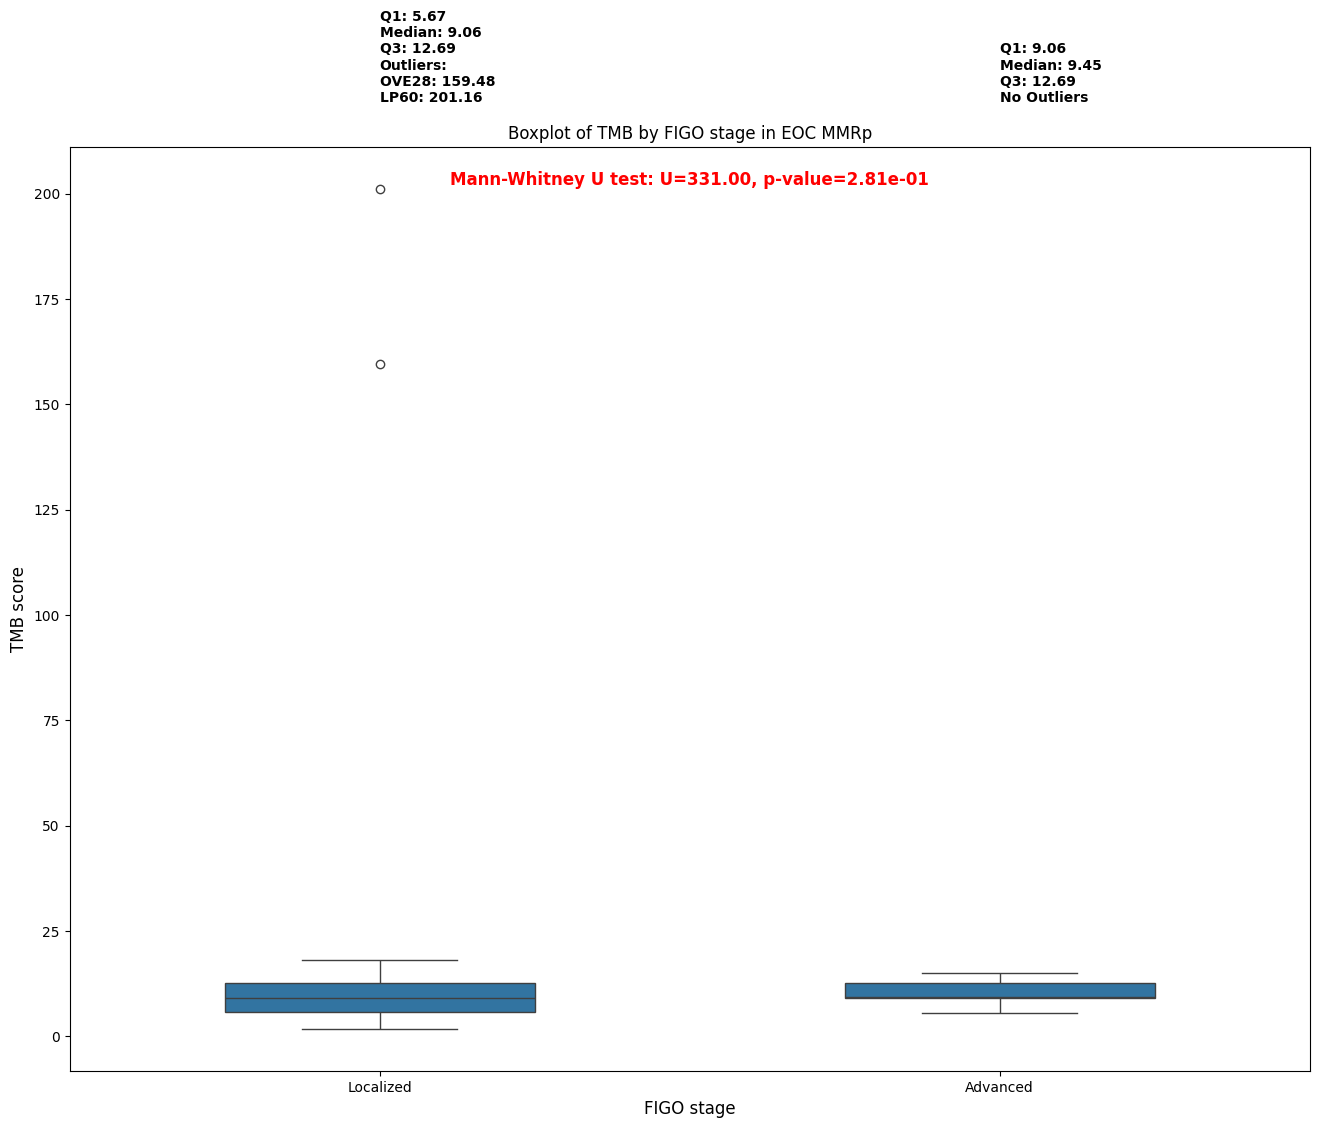

In [36]:
#### Analysis of statistics and distribution of TMB values in FIGOL categories in the EOC MMRp cohort ########

# Uncomment to import if not done previously
#import seaborn as sns  # Library for statistical data visualization
#from scipy.stats import shapiro  # Function to test normality of data (Shapiro-Wilk test)
#from scipy.stats import levene  # Function to test equality of variances (Levene's test)
#from scipy.stats import ttest_ind  # Function for independent two-sample t-test
#from scipy.stats import mannwhitneyu  # Function for Mann-Whitney U test (non-parametric test for two groups)

def analyze_and_plot_tmb(df, output_folder, output_file):
    # Filter only the categories "Localized" and "Advanced" in FIGOL
    df = df[df['FIGOL'].isin(['Localized', 'Advanced'])]
    # Dictionary to store outlier statistics
    outliers_dict = {}
    # Dictionary to store the number of samples in each category
    sample_counts = df['FIGOL'].value_counts().to_dict()
    print(f"Number of samples in each category:")
    for category, count in sample_counts.items():
        print(f"{category}: {count}")
        
    # Create a figure for the boxplot
    plt.figure(figsize=(16, 12))  # Increased size for better visibility
    sns.boxplot(x='FIGOL', y='TMB', data=df, width=0.5)  # Adjust the width of the boxes
    
    # Variables to store data for FIGO categories
    tmb_figoloc = []
    tmb_figoadv = []

    for category in df['FIGOL'].unique():
        # Filter data for the current category
        category_data = df[df['FIGOL'] == category]

        # Calculate Q1, Q3, and median
        Q1 = category_data['TMB'].quantile(0.25)
        Q3 = category_data['TMB'].quantile(0.75)
        median = category_data['TMB'].median()
        IQR = Q3 - Q1
        
        # Define limits for outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Identify outliers
        outliers = category_data[(category_data['TMB'] < lower_bound) | 
                                 (category_data['TMB'] > upper_bound)]
        
        # Store outlier IDs and values
        outliers_dict[category] = {
            'Outlier_IDs': outliers['ID_CNIO'].tolist(),
            'Outlier_Values': outliers['TMB'].tolist(),
            'Q1': Q1,
            'Q3': Q3,
            'Median': median
        }
        
        # Add data to the corresponding lists
        if category == 'Localized':
            tmb_figoloc = category_data['TMB'].astype(float).dropna()
        elif category == 'Advanced':
            tmb_figoadv = category_data['TMB'].astype(float).dropna()

    # Perform statistical tests
    if not tmb_figoloc.empty and not tmb_figoadv.empty:
        # Shapiro-Wilk normality test
        shapiro_loc = shapiro(tmb_figoloc)
        shapiro_adv = shapiro(tmb_figoadv)
        print(f"Shapiro-Wilk test for Localized: W={shapiro_loc.statistic:.4f}, p-value={shapiro_loc.pvalue:.4f}")
        print(f"Shapiro-Wilk test for Advanced: W={shapiro_adv.statistic:.4f}, p-value={shapiro_adv.pvalue:.4f}")
        
        # Levene's test for homogeneity of variances
        levene_test = levene(tmb_figoloc, tmb_figoadv)
        print(f"Levene's test: W={levene_test.statistic:.4f}, p-value={levene_test.pvalue:.4f}")
        
        # Select the appropriate test
        if shapiro_loc.pvalue > 0.05 and shapiro_adv.pvalue > 0.05 and levene_test.pvalue > 0.05:
            # T-test
            t_test = ttest_ind(tmb_figoloc, tmb_figoadv)
            test_result = f"T-test: t={t_test.statistic:.2f}, p-value={t_test.pvalue:.2e}"
        else:
            # Mann-Whitney U test
            mannwhitney_test = mannwhitneyu(tmb_figoloc, tmb_figoadv, alternative='two-sided')
            test_result = f"Mann-Whitney U test: U={mannwhitney_test.statistic:.2f}, p-value={mannwhitney_test.pvalue:.2e}"
        
        # Add the test result to the plot
        plt.gca().text(
            x=0.5, y=df['TMB'].max(), 
            s=test_result,
            horizontalalignment='center', verticalalignment='bottom', 
            fontsize=12, color='red', 
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', boxstyle='round,pad=0.5'),
            weight='bold'
        )

    # Add text with outliers, Q1, Q3, and Median
    for category, stats in outliers_dict.items():
        sorted_outliers = sorted(zip(stats['Outlier_IDs'], stats['Outlier_Values']), key=lambda x: x[1])
        outlier_text = 'Outliers:\n' + '\n'.join([f'{id_}: {val:.2f}' for id_, val in sorted_outliers]) if stats['Outlier_Values'] else 'No Outliers'
        
        # Always include Q1, Median, and Q3 in the text box
        summary_stats_text = f"Q1: {stats['Q1']:.2f}\nMedian: {stats['Median']:.2f}\nQ3: {stats['Q3']:.2f}\n{outlier_text}"
        
        x_pos = df['FIGOL'].unique().tolist().index(category)
        plt.gca().text(
            x=x_pos, 
            y=df['TMB'].max() + 0.1 * (df['TMB'].max() - df['TMB'].min()), 
            s=summary_stats_text,
            horizontalalignment='left', verticalalignment='bottom', 
            fontsize=10, color='black',
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.5'),
            weight='bold'
        )
    
    # Set title and labels for the plot
    plt.title('Boxplot of TMB by FIGO stage in EOC MMRp', fontsize=12)
    plt.xlabel('FIGO stage', fontsize=12)
    plt.ylabel('TMB score', fontsize=12)
    
    # Save the plot as a PDF file
    plt.savefig(f'{output_folder}/{output_file}', format='pdf', bbox_inches='tight')
    
    # Show the plot
    plt.show()

# Define output folder and file and call the function
output_folder = '/home/vant/TFM/Plots_TFM_final/'
output_file = 'Boxplot_MMRp_EOC_TMB_by_FIGOL.pdf'  
analyze_and_plot_tmb(df_eoc_mmrp, output_folder, output_file)

Number of samples in each category:
Localized: 40
Advanced: 28
Shapiro-Wilk test for Localized: W=0.3655, p-value=0.0000
Shapiro-Wilk test for Advanced: W=0.3703, p-value=0.0000
Levene's test: W=0.0814, p-value=0.7764


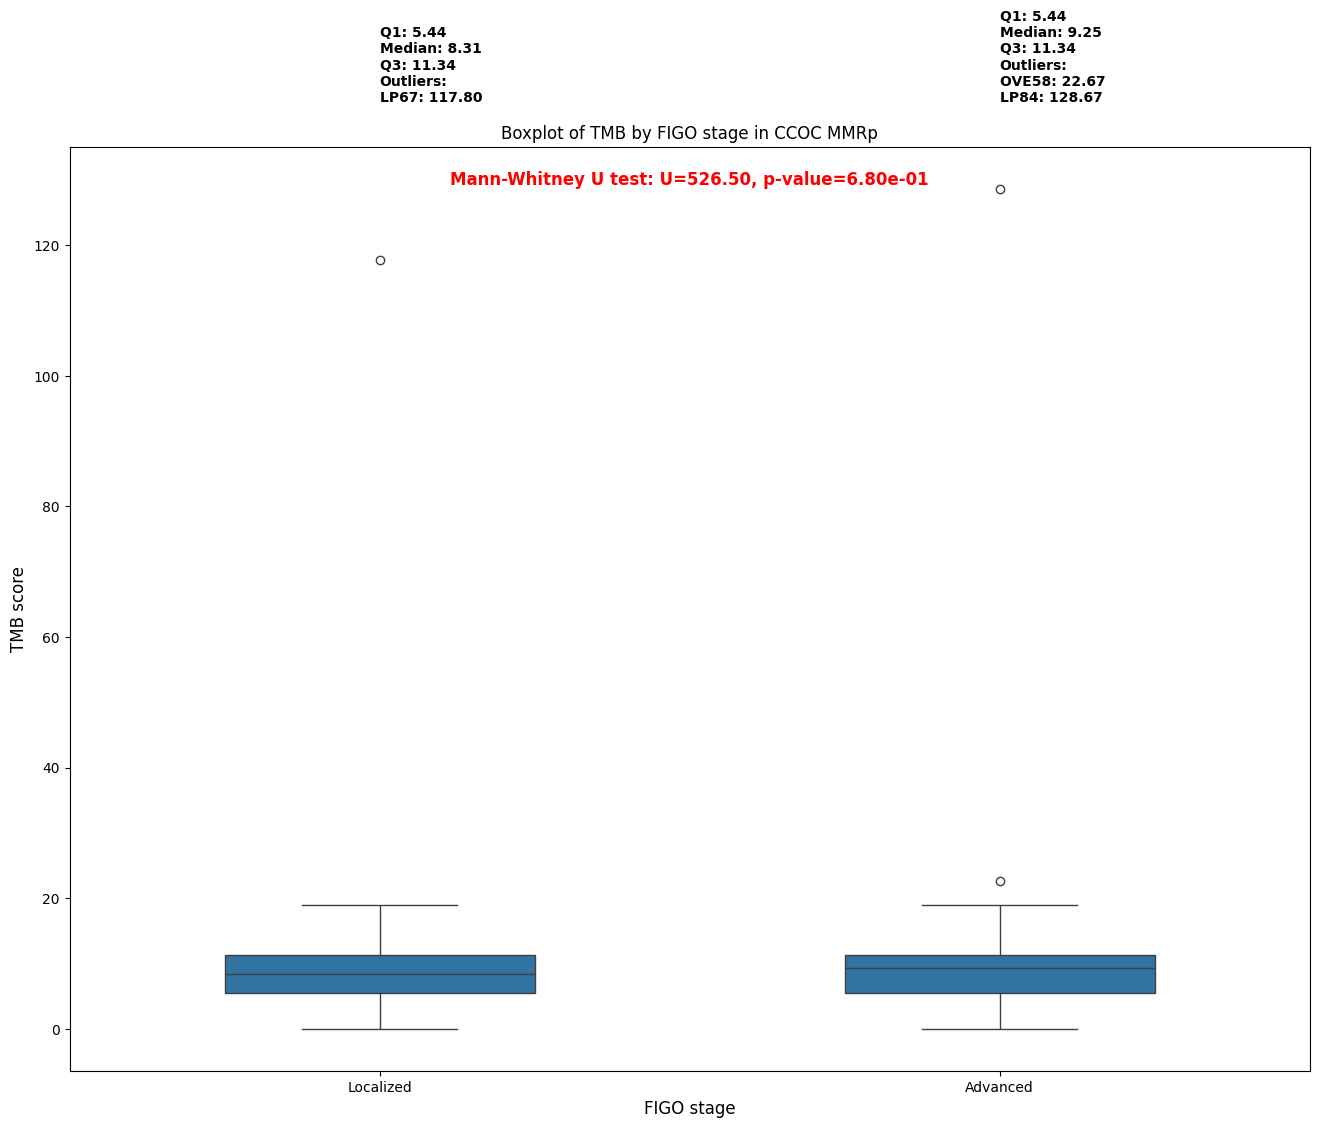

In [37]:
#### Analysis of statistics and distribution of TMB values in FIGOL categories in the CCOC MMRp cohort ########

# Uncomment to import if not done previously
#import seaborn as sns  # Library for statistical data visualization
#from scipy.stats import shapiro  # Function to test normality of data (Shapiro-Wilk test)
#from scipy.stats import levene  # Function to test equality of variances (Levene's test)
#from scipy.stats import ttest_ind  # Function for independent two-sample t-test
#from scipy.stats import mannwhitneyu  # Function for Mann-Whitney U test (non-parametric test for two groups)

def analyze_and_plot_tmb(df, output_folder, output_file):
    # Filter only the categories "Localized" and "Advanced" in FIGOL
    df = df[df['FIGOL'].isin(['Localized', 'Advanced'])]
    # Dictionary to store outlier statistics
    outliers_dict = {}
    # Dictionary to store the number of samples in each category
    sample_counts = df['FIGOL'].value_counts().to_dict()
    print(f"Number of samples in each category:")
    for category, count in sample_counts.items():
        print(f"{category}: {count}")
        
    # Create a figure for the boxplot
    plt.figure(figsize=(16, 12))  # Increased size for better visibility
    sns.boxplot(x='FIGOL', y='TMB', data=df, width=0.5)  # Adjust the width of the boxes
    
    # Variables to store data for FIGO categories
    tmb_figoloc = []
    tmb_figoadv = []

    for category in df['FIGOL'].unique():
        # Filter data for the current category
        category_data = df[df['FIGOL'] == category]

        # Calculate Q1, Q3, and median
        Q1 = category_data['TMB'].quantile(0.25)
        Q3 = category_data['TMB'].quantile(0.75)
        median = category_data['TMB'].median()
        IQR = Q3 - Q1
        
        # Define limits for outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Identify outliers
        outliers = category_data[(category_data['TMB'] < lower_bound) | 
                                 (category_data['TMB'] > upper_bound)]
        
        # Store outlier IDs and values
        outliers_dict[category] = {
            'Outlier_IDs': outliers['ID_CNIO'].tolist(),
            'Outlier_Values': outliers['TMB'].tolist(),
            'Q1': Q1,
            'Q3': Q3,
            'Median': median
        }
        
        # Add data to the corresponding lists
        if category == 'Localized':
            tmb_figoloc = category_data['TMB'].astype(float).dropna()
        elif category == 'Advanced':
            tmb_figoadv = category_data['TMB'].astype(float).dropna()

    # Perform statistical tests
    if not tmb_figoloc.empty and not tmb_figoadv.empty:
        # Shapiro-Wilk normality test
        shapiro_loc = shapiro(tmb_figoloc)
        shapiro_adv = shapiro(tmb_figoadv)
        print(f"Shapiro-Wilk test for Localized: W={shapiro_loc.statistic:.4f}, p-value={shapiro_loc.pvalue:.4f}")
        print(f"Shapiro-Wilk test for Advanced: W={shapiro_adv.statistic:.4f}, p-value={shapiro_adv.pvalue:.4f}")
        
        # Levene's test for homogeneity of variances
        levene_test = levene(tmb_figoloc, tmb_figoadv)
        print(f"Levene's test: W={levene_test.statistic:.4f}, p-value={levene_test.pvalue:.4f}")
        
        # Select the appropriate test
        if shapiro_loc.pvalue > 0.05 and shapiro_adv.pvalue > 0.05 and levene_test.pvalue > 0.05:
            # T-test
            t_test = ttest_ind(tmb_figoloc, tmb_figoadv)
            test_result = f"T-test: t={t_test.statistic:.2f}, p-value={t_test.pvalue:.2e}"
        else:
            # Mann-Whitney U test
            mannwhitney_test = mannwhitneyu(tmb_figoloc, tmb_figoadv, alternative='two-sided')
            test_result = f"Mann-Whitney U test: U={mannwhitney_test.statistic:.2f}, p-value={mannwhitney_test.pvalue:.2e}"
        
        # Add the test result to the plot
        plt.gca().text(
            x=0.5, y=df['TMB'].max(), 
            s=test_result,
            horizontalalignment='center', verticalalignment='bottom', 
            fontsize=12, color='red', 
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', boxstyle='round,pad=0.5'),
            weight='bold'
        )

    # Add text with outliers, Q1, Q3, and Median
    for category, stats in outliers_dict.items():
        sorted_outliers = sorted(zip(stats['Outlier_IDs'], stats['Outlier_Values']), key=lambda x: x[1])
        outlier_text = 'Outliers:\n' + '\n'.join([f'{id_}: {val:.2f}' for id_, val in sorted_outliers]) if stats['Outlier_Values'] else 'No Outliers'
        
        # Always include Q1, Median, and Q3 in the text box
        summary_stats_text = f"Q1: {stats['Q1']:.2f}\nMedian: {stats['Median']:.2f}\nQ3: {stats['Q3']:.2f}\n{outlier_text}"
        
        x_pos = df['FIGOL'].unique().tolist().index(category)
        plt.gca().text(
            x=x_pos, 
            y=df['TMB'].max() + 0.1 * (df['TMB'].max() - df['TMB'].min()), 
            s=summary_stats_text,
            horizontalalignment='left', verticalalignment='bottom', 
            fontsize=10, color='black',
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.5'),
            weight='bold'
        )
    
    # Set title and labels for the plot
    plt.title('Boxplot of TMB by FIGO stage in CCOC MMRp', fontsize=12)
    plt.xlabel('FIGO stage', fontsize=12)
    plt.ylabel('TMB score', fontsize=12)
    
    # Save the plot as a PDF file
    plt.savefig(f'{output_folder}/{output_file}', format='pdf', bbox_inches='tight')
    
    # Show the plot
    plt.show()

# Define output folder and file and call the function
output_folder = '/home/vant/TFM/Plots_TFM_final/'
output_file = 'Boxplot_MMRp_CCOC_TMB_by_FIGOL.pdf'  
analyze_and_plot_tmb(df_cc_mmrp, output_folder, output_file)

Number of samples in each category:
Localized: 103
Advanced: 41
Shapiro-Wilk test for Localized: W=0.9145, p-value=0.0000
Shapiro-Wilk test for Advanced: W=0.8857, p-value=0.0006
Levene's test: W=0.1396, p-value=0.7093


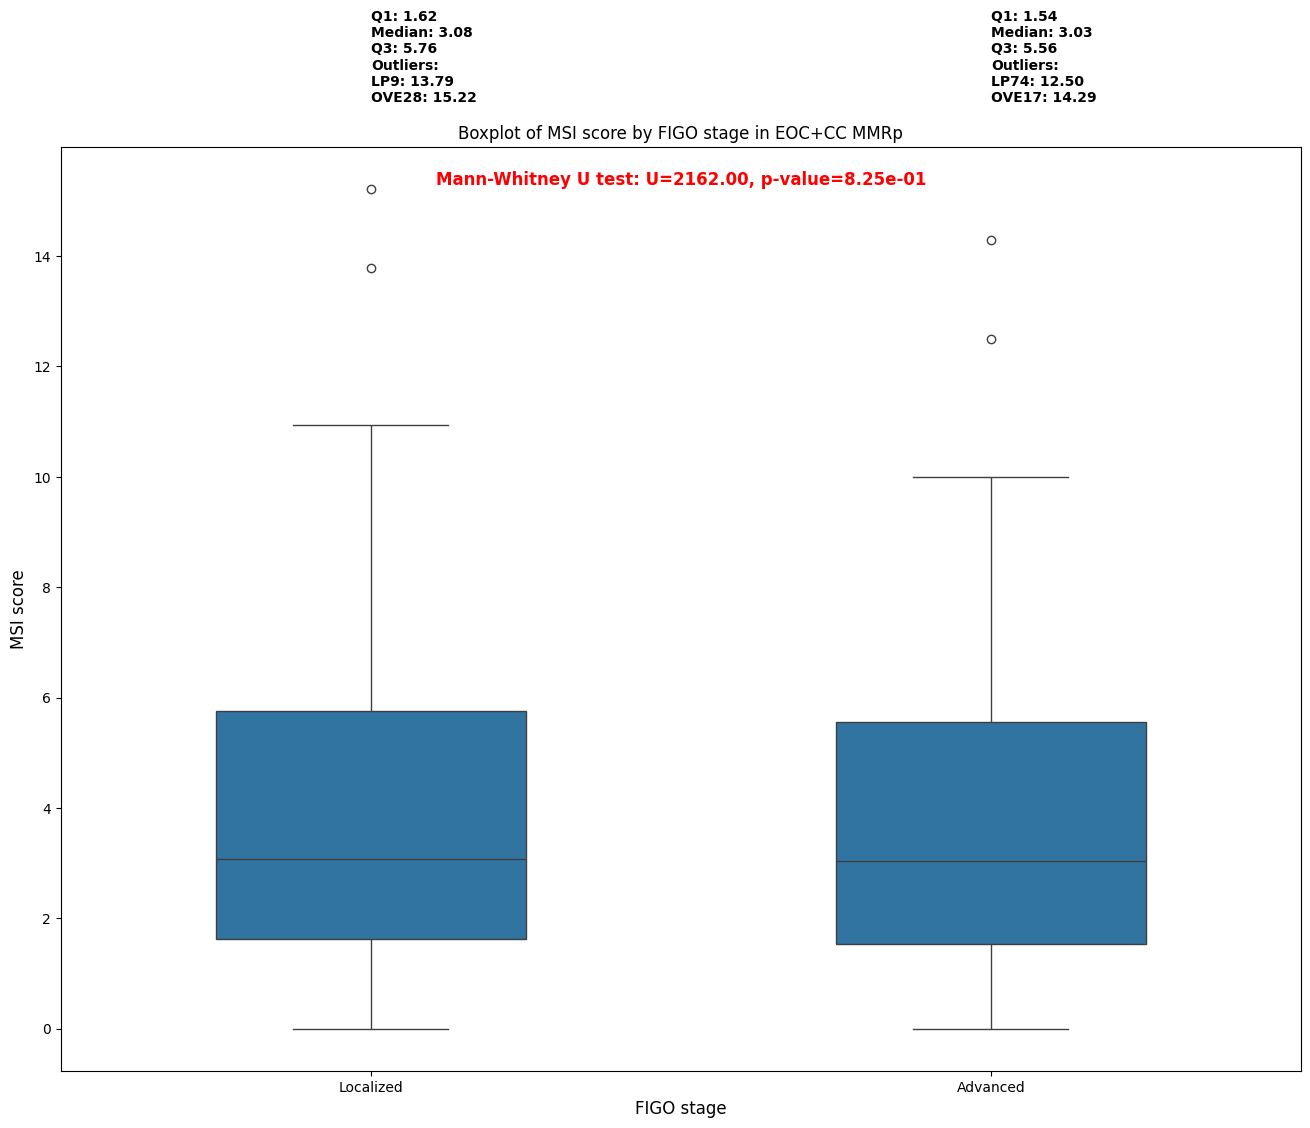

In [38]:
#### Analysis of statistics and distribution of MSI scores values in FIGOL categories in the entire MMRp cohort ########

# Uncomment to import if not done previously
#import seaborn as sns  # Library for statistical data visualization
#from scipy.stats import shapiro  # Function to test normality of data (Shapiro-Wilk test)
#from scipy.stats import levene  # Function to test equality of variances (Levene's test)
#from scipy.stats import ttest_ind  # Function for independent two-sample t-test
#from scipy.stats import mannwhitneyu  # Function for Mann-Whitney U test (non-parametric test for two groups)

def analyze_and_plot_msi(df, output_folder, output_file):
    # Filtrar solo las categorías "Localized" y "Advanced" en FIGOL
    df = df[df['FIGOL'].isin(['Localized', 'Advanced'])]

    # Dictionary to store outlier statistics
    outliers_dict = {}

    # Dictionary to store the number of samples in each category
    sample_counts = df['FIGOL'].value_counts().to_dict()
    print(f"Number of samples in each category:")
    for category, count in sample_counts.items():
        print(f"{category}: {count}")

    # Create a figure for the boxplot
    plt.figure(figsize=(16, 12))  # Increased size for better visibility
    sns.boxplot(x='FIGOL', y='MSI_sensor2', data=df, width=0.5)  # Adjust the width of the boxes

    # Variables to store data for FIGO categories
    msi_figoloc = []
    msi_figoadv = []

    for category in df['FIGOL'].unique():
        # Filter data for the current category
        category_data = df[df['FIGOL'] == category]

        # Calculate Q1, Q3, and median
        Q1 = category_data['MSI_sensor2'].quantile(0.25)
        Q3 = category_data['MSI_sensor2'].quantile(0.75)
        median = category_data['MSI_sensor2'].median()
        IQR = Q3 - Q1

        # Define limits for outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Identify outliers
        outliers = category_data[(category_data['MSI_sensor2'] < lower_bound) | 
                                 (category_data['MSI_sensor2'] > upper_bound)]

        # Store outlier IDs and values
        outliers_dict[category] = {
            'Outlier_IDs': outliers['ID_CNIO'].tolist(),
            'Outlier_Values': outliers['MSI_sensor2'].tolist(),
            'Q1': Q1,
            'Q3': Q3,
            'Median': median
        }

        # Add data to the corresponding lists
        if category == 'Localized':
            msi_figoloc = category_data['MSI_sensor2'].astype(float).dropna()
        elif category == 'Advanced':
            msi_figoadv = category_data['MSI_sensor2'].astype(float).dropna()

    # Perform statistical tests
    if not msi_figoloc.empty and not msi_figoadv.empty:
        # Shapiro-Wilk normality test
        shapiro_loc = shapiro(msi_figoloc)
        shapiro_adv = shapiro(msi_figoadv)
        print(f"Shapiro-Wilk test for Localized: W={shapiro_loc.statistic:.4f}, p-value={shapiro_loc.pvalue:.4f}")
        print(f"Shapiro-Wilk test for Advanced: W={shapiro_adv.statistic:.4f}, p-value={shapiro_adv.pvalue:.4f}")
        
        # Levene's test for homogeneity of variances
        levene_test = levene(msi_figoloc, msi_figoadv)
        print(f"Levene's test: W={levene_test.statistic:.4f}, p-value={levene_test.pvalue:.4f}")
        
        # Select the appropriate test
        if shapiro_loc.pvalue > 0.05 and shapiro_adv.pvalue > 0.05 and levene_test.pvalue > 0.05:
            # T-test
            t_test = ttest_ind(msi_figoloc, msi_figoadv)
            test_result = f"T-test: t={t_test.statistic:.2f}, p-value={t_test.pvalue:.2e}"
        else:
            # Mann-Whitney U test
            mannwhitney_test = mannwhitneyu(msi_figoloc, msi_figoadv, alternative='two-sided')
            test_result = f"Mann-Whitney U test: U={mannwhitney_test.statistic:.2f}, p-value={mannwhitney_test.pvalue:.2e}"

        # Add the test result to the plot
        plt.gca().text(
            x=0.5, y=df['MSI_sensor2'].max(), 
            s=test_result,
            horizontalalignment='center', verticalalignment='bottom', 
            fontsize=12, color='red', 
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', boxstyle='round,pad=0.5'),
            weight='bold'
        )

    # Add text with outliers, Q1, Q3, and Median
    for category, stats in outliers_dict.items():
        sorted_outliers = sorted(zip(stats['Outlier_IDs'], stats['Outlier_Values']), key=lambda x: x[1])
        outlier_text = 'Outliers:\n' + '\n'.join([f'{id_}: {val:.2f}' for id_, val in sorted_outliers]) if stats['Outlier_Values'] else 'No Outliers'
        
        # Always include Q1, Median, and Q3 in the text box
        summary_stats_text = f"Q1: {stats['Q1']:.2f}\nMedian: {stats['Median']:.2f}\nQ3: {stats['Q3']:.2f}\n{outlier_text}"
        
        x_pos = df['FIGOL'].unique().tolist().index(category)
        plt.gca().text(
            x=x_pos, 
            y=df['MSI_sensor2'].max() + 0.1 * (df['MSI_sensor2'].max() - df['MSI_sensor2'].min()), 
            s=summary_stats_text,
            horizontalalignment='left', verticalalignment='bottom', 
            fontsize=10, color='black',
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.5'),
            weight='bold'
        )

    # Set title and labels for the plot
    plt.title('Boxplot of MSI score by FIGO stage in EOC+CC MMRp', fontsize=12)
    plt.xlabel('FIGO stage', fontsize=12)
    plt.ylabel('MSI score', fontsize=12)
    
    # Save the plot as a PDF file
    plt.savefig(f'{output_folder}/{output_file}', format='pdf', bbox_inches='tight')
    
    # Show the plot
    plt.show()

# Define output folder and file and call the function
output_folder = '/home/vant/TFM/Plots_TFM_final/'
output_file = 'Boxplot_MMRp_MSIscore_by_FIGOL.pdf'  
analyze_and_plot_msi(df_all_mmrp, output_folder, output_file)

Number of samples in each category:
Localized: 63
Advanced: 13
Shapiro-Wilk test for Localized: W=0.9035, p-value=0.0001
Shapiro-Wilk test for Advanced: W=0.9318, p-value=0.3594
Levene's test: W=0.0567, p-value=0.8124


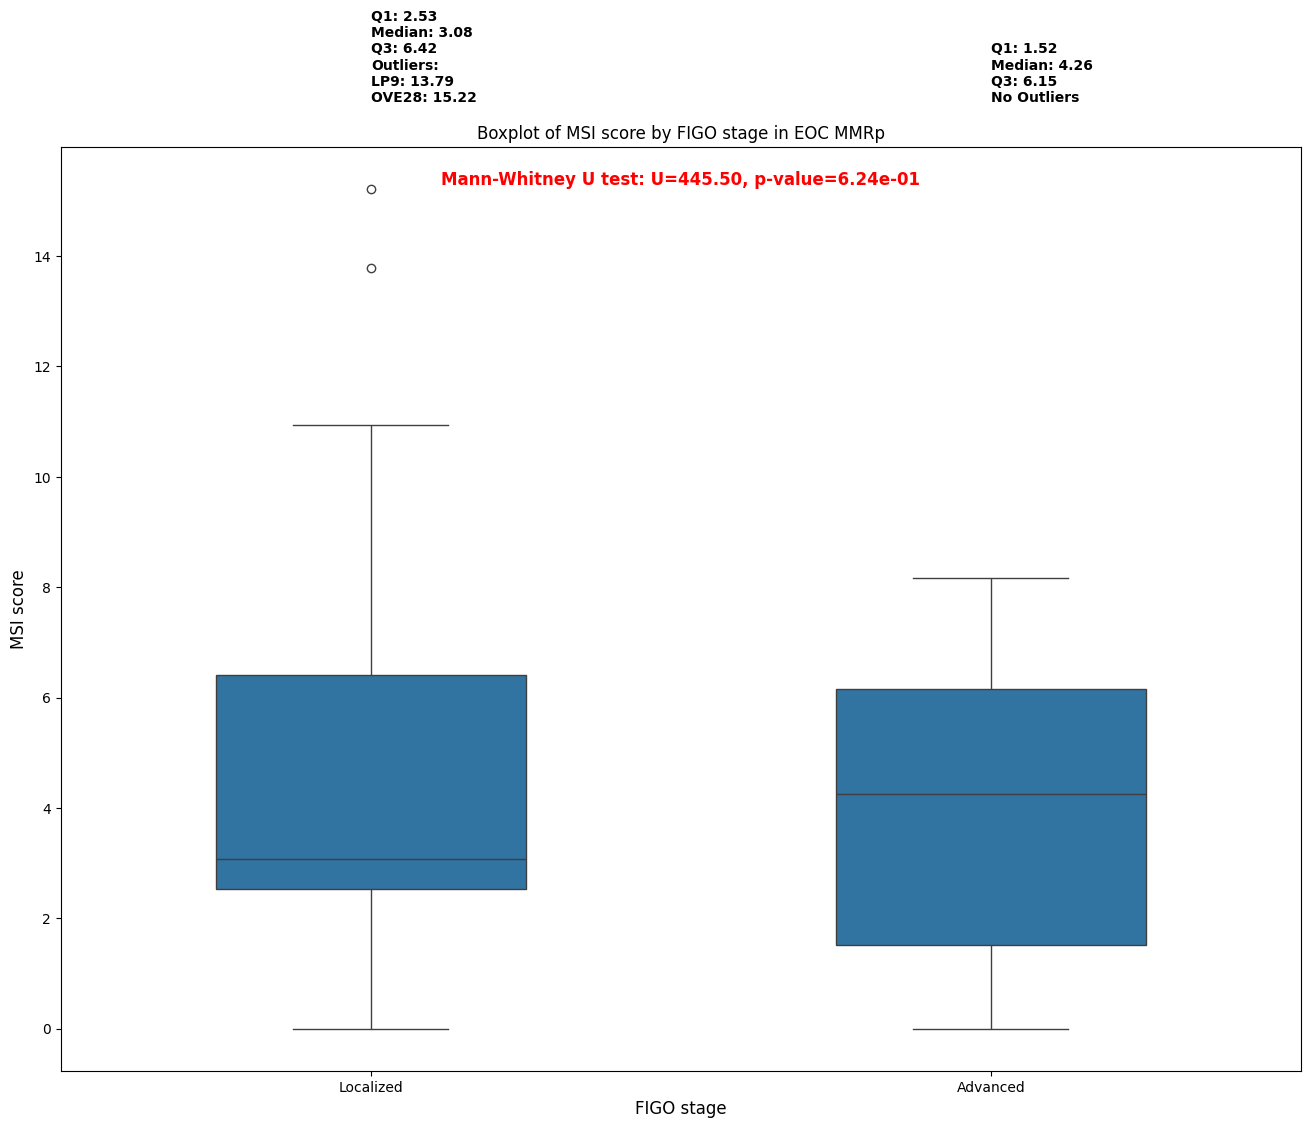

In [39]:
#### Analysis of statistics and distribution of MSI scores values in FIGOL categories in the EOC MMRp cohort ########

# Uncomment to import if not done previously
#import seaborn as sns  # Library for statistical data visualization
#from scipy.stats import shapiro  # Function to test normality of data (Shapiro-Wilk test)
#from scipy.stats import levene  # Function to test equality of variances (Levene's test)
#from scipy.stats import ttest_ind  # Function for independent two-sample t-test
#from scipy.stats import mannwhitneyu  # Function for Mann-Whitney U test (non-parametric test for two groups)

def analyze_and_plot_msi(df, output_folder, output_file):
    # Filtrar solo las categorías "Localized" y "Advanced" en FIGOL
    df = df[df['FIGOL'].isin(['Localized', 'Advanced'])]

    # Dictionary to store outlier statistics
    outliers_dict = {}

    # Dictionary to store the number of samples in each category
    sample_counts = df['FIGOL'].value_counts().to_dict()
    print(f"Number of samples in each category:")
    for category, count in sample_counts.items():
        print(f"{category}: {count}")

    # Create a figure for the boxplot
    plt.figure(figsize=(16, 12))  # Increased size for better visibility
    sns.boxplot(x='FIGOL', y='MSI_sensor2', data=df, width=0.5)  # Adjust the width of the boxes

    # Variables to store data for FIGO categories
    msi_figoloc = []
    msi_figoadv = []

    for category in df['FIGOL'].unique():
        # Filter data for the current category
        category_data = df[df['FIGOL'] == category]

        # Calculate Q1, Q3, and median
        Q1 = category_data['MSI_sensor2'].quantile(0.25)
        Q3 = category_data['MSI_sensor2'].quantile(0.75)
        median = category_data['MSI_sensor2'].median()
        IQR = Q3 - Q1

        # Define limits for outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Identify outliers
        outliers = category_data[(category_data['MSI_sensor2'] < lower_bound) | 
                                 (category_data['MSI_sensor2'] > upper_bound)]

        # Store outlier IDs and values
        outliers_dict[category] = {
            'Outlier_IDs': outliers['ID_CNIO'].tolist(),
            'Outlier_Values': outliers['MSI_sensor2'].tolist(),
            'Q1': Q1,
            'Q3': Q3,
            'Median': median
        }

        # Add data to the corresponding lists
        if category == 'Localized':
            msi_figoloc = category_data['MSI_sensor2'].astype(float).dropna()
        elif category == 'Advanced':
            msi_figoadv = category_data['MSI_sensor2'].astype(float).dropna()

    # Perform statistical tests
    if not msi_figoloc.empty and not msi_figoadv.empty:
        # Shapiro-Wilk normality test
        shapiro_loc = shapiro(msi_figoloc)
        shapiro_adv = shapiro(msi_figoadv)
        print(f"Shapiro-Wilk test for Localized: W={shapiro_loc.statistic:.4f}, p-value={shapiro_loc.pvalue:.4f}")
        print(f"Shapiro-Wilk test for Advanced: W={shapiro_adv.statistic:.4f}, p-value={shapiro_adv.pvalue:.4f}")
        
        # Levene's test for homogeneity of variances
        levene_test = levene(msi_figoloc, msi_figoadv)
        print(f"Levene's test: W={levene_test.statistic:.4f}, p-value={levene_test.pvalue:.4f}")
        
        # Select the appropriate test
        if shapiro_loc.pvalue > 0.05 and shapiro_adv.pvalue > 0.05 and levene_test.pvalue > 0.05:
            # T-test
            t_test = ttest_ind(msi_figoloc, msi_figoadv)
            test_result = f"T-test: t={t_test.statistic:.2f}, p-value={t_test.pvalue:.2e}"
        else:
            # Mann-Whitney U test
            mannwhitney_test = mannwhitneyu(msi_figoloc, msi_figoadv, alternative='two-sided')
            test_result = f"Mann-Whitney U test: U={mannwhitney_test.statistic:.2f}, p-value={mannwhitney_test.pvalue:.2e}"

        # Add the test result to the plot
        plt.gca().text(
            x=0.5, y=df['MSI_sensor2'].max(), 
            s=test_result,
            horizontalalignment='center', verticalalignment='bottom', 
            fontsize=12, color='red', 
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', boxstyle='round,pad=0.5'),
            weight='bold'
        )

    # Add text with outliers, Q1, Q3, and Median
    for category, stats in outliers_dict.items():
        sorted_outliers = sorted(zip(stats['Outlier_IDs'], stats['Outlier_Values']), key=lambda x: x[1])
        outlier_text = 'Outliers:\n' + '\n'.join([f'{id_}: {val:.2f}' for id_, val in sorted_outliers]) if stats['Outlier_Values'] else 'No Outliers'
        
        # Always include Q1, Median, and Q3 in the text box
        summary_stats_text = f"Q1: {stats['Q1']:.2f}\nMedian: {stats['Median']:.2f}\nQ3: {stats['Q3']:.2f}\n{outlier_text}"
        
        x_pos = df['FIGOL'].unique().tolist().index(category)
        plt.gca().text(
            x=x_pos, 
            y=df['MSI_sensor2'].max() + 0.1 * (df['MSI_sensor2'].max() - df['MSI_sensor2'].min()), 
            s=summary_stats_text,
            horizontalalignment='left', verticalalignment='bottom', 
            fontsize=10, color='black',
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.5'),
            weight='bold'
        )

    # Set title and labels for the plot
    plt.title('Boxplot of MSI score by FIGO stage in EOC MMRp', fontsize=12)
    plt.xlabel('FIGO stage', fontsize=12)
    plt.ylabel('MSI score', fontsize=12)
    
    # Save the plot as a PDF file
    plt.savefig(f'{output_folder}/{output_file}', format='pdf', bbox_inches='tight')
    
    # Show the plot
    plt.show()

# Define output folder and file and call the function
output_folder = '/home/vant/TFM/Plots_TFM_final/'
output_file = 'Boxplot_MMRp_EOC_MSIscore_by_FIGOL.pdf'  
analyze_and_plot_msi(df_eoc_mmrp, output_folder, output_file)

Number of samples in each category:
Localized: 40
Advanced: 28
Shapiro-Wilk test for Localized: W=0.9227, p-value=0.0094
Shapiro-Wilk test for Advanced: W=0.8430, p-value=0.0007
Levene's test: W=0.5800, p-value=0.4490


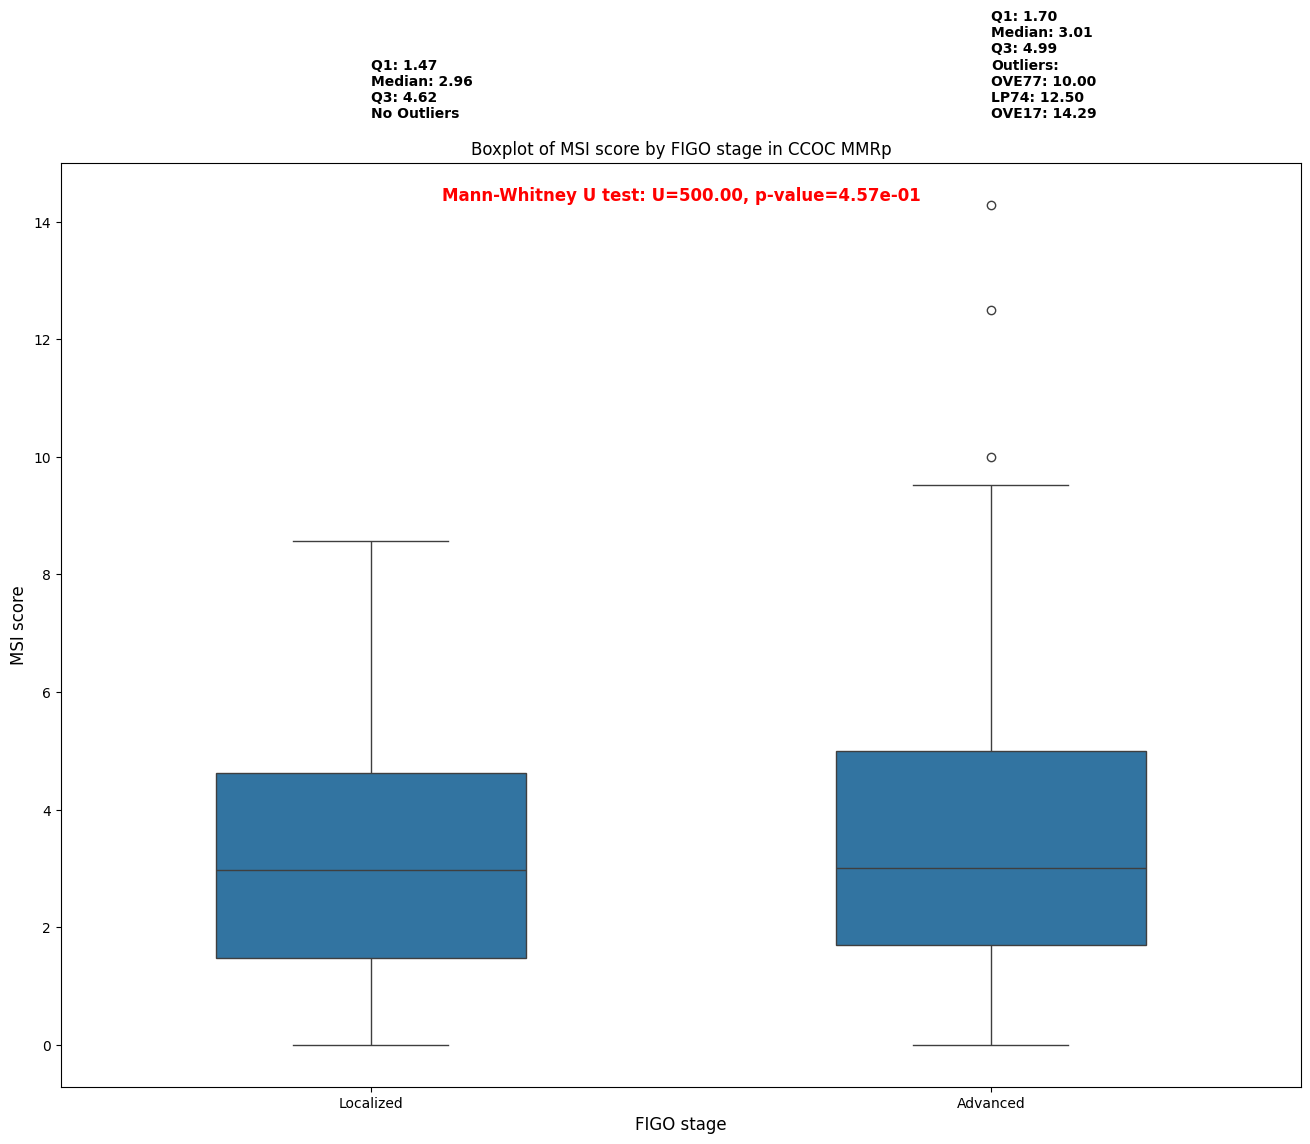

In [40]:
#### Analysis of statistics and distribution of MSI scores values in FIGOL categories in the CCOC MMRp cohort ########

# Uncomment to import if not done previously
#import seaborn as sns  # Library for statistical data visualization
#from scipy.stats import shapiro  # Function to test normality of data (Shapiro-Wilk test)
#from scipy.stats import levene  # Function to test equality of variances (Levene's test)
#from scipy.stats import ttest_ind  # Function for independent two-sample t-test
#from scipy.stats import mannwhitneyu  # Function for Mann-Whitney U test (non-parametric test for two groups)

def analyze_and_plot_msi(df, output_folder, output_file):
    # Filtrar solo las categorías "Localized" y "Advanced" en FIGOL
    df = df[df['FIGOL'].isin(['Localized', 'Advanced'])]

    # Dictionary to store outlier statistics
    outliers_dict = {}

    # Dictionary to store the number of samples in each category
    sample_counts = df['FIGOL'].value_counts().to_dict()
    print(f"Number of samples in each category:")
    for category, count in sample_counts.items():
        print(f"{category}: {count}")

    # Create a figure for the boxplot
    plt.figure(figsize=(16, 12))  # Increased size for better visibility
    sns.boxplot(x='FIGOL', y='MSI_sensor2', data=df, width=0.5)  # Adjust the width of the boxes

    # Variables to store data for FIGO categories
    msi_figoloc = []
    msi_figoadv = []

    for category in df['FIGOL'].unique():
        # Filter data for the current category
        category_data = df[df['FIGOL'] == category]

        # Calculate Q1, Q3, and median
        Q1 = category_data['MSI_sensor2'].quantile(0.25)
        Q3 = category_data['MSI_sensor2'].quantile(0.75)
        median = category_data['MSI_sensor2'].median()
        IQR = Q3 - Q1

        # Define limits for outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Identify outliers
        outliers = category_data[(category_data['MSI_sensor2'] < lower_bound) | 
                                 (category_data['MSI_sensor2'] > upper_bound)]

        # Store outlier IDs and values
        outliers_dict[category] = {
            'Outlier_IDs': outliers['ID_CNIO'].tolist(),
            'Outlier_Values': outliers['MSI_sensor2'].tolist(),
            'Q1': Q1,
            'Q3': Q3,
            'Median': median
        }

        # Add data to the corresponding lists
        if category == 'Localized':
            msi_figoloc = category_data['MSI_sensor2'].astype(float).dropna()
        elif category == 'Advanced':
            msi_figoadv = category_data['MSI_sensor2'].astype(float).dropna()

    # Perform statistical tests
    if not msi_figoloc.empty and not msi_figoadv.empty:
        # Shapiro-Wilk normality test
        shapiro_loc = shapiro(msi_figoloc)
        shapiro_adv = shapiro(msi_figoadv)
        print(f"Shapiro-Wilk test for Localized: W={shapiro_loc.statistic:.4f}, p-value={shapiro_loc.pvalue:.4f}")
        print(f"Shapiro-Wilk test for Advanced: W={shapiro_adv.statistic:.4f}, p-value={shapiro_adv.pvalue:.4f}")
        
        # Levene's test for homogeneity of variances
        levene_test = levene(msi_figoloc, msi_figoadv)
        print(f"Levene's test: W={levene_test.statistic:.4f}, p-value={levene_test.pvalue:.4f}")
        
        # Select the appropriate test
        if shapiro_loc.pvalue > 0.05 and shapiro_adv.pvalue > 0.05 and levene_test.pvalue > 0.05:
            # T-test
            t_test = ttest_ind(msi_figoloc, msi_figoadv)
            test_result = f"T-test: t={t_test.statistic:.2f}, p-value={t_test.pvalue:.2e}"
        else:
            # Mann-Whitney U test
            mannwhitney_test = mannwhitneyu(msi_figoloc, msi_figoadv, alternative='two-sided')
            test_result = f"Mann-Whitney U test: U={mannwhitney_test.statistic:.2f}, p-value={mannwhitney_test.pvalue:.2e}"

        # Add the test result to the plot
        plt.gca().text(
            x=0.5, y=df['MSI_sensor2'].max(), 
            s=test_result,
            horizontalalignment='center', verticalalignment='bottom', 
            fontsize=12, color='red', 
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', boxstyle='round,pad=0.5'),
            weight='bold'
        )

    # Add text with outliers, Q1, Q3, and Median
    for category, stats in outliers_dict.items():
        sorted_outliers = sorted(zip(stats['Outlier_IDs'], stats['Outlier_Values']), key=lambda x: x[1])
        outlier_text = 'Outliers:\n' + '\n'.join([f'{id_}: {val:.2f}' for id_, val in sorted_outliers]) if stats['Outlier_Values'] else 'No Outliers'
        
        # Always include Q1, Median, and Q3 in the text box
        summary_stats_text = f"Q1: {stats['Q1']:.2f}\nMedian: {stats['Median']:.2f}\nQ3: {stats['Q3']:.2f}\n{outlier_text}"
        
        x_pos = df['FIGOL'].unique().tolist().index(category)
        plt.gca().text(
            x=x_pos, 
            y=df['MSI_sensor2'].max() + 0.1 * (df['MSI_sensor2'].max() - df['MSI_sensor2'].min()), 
            s=summary_stats_text,
            horizontalalignment='left', verticalalignment='bottom', 
            fontsize=10, color='black',
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.5'),
            weight='bold'
        )

    # Set title and labels for the plot
    plt.title('Boxplot of MSI score by FIGO stage in CCOC MMRp', fontsize=12)
    plt.xlabel('FIGO stage', fontsize=12)
    plt.ylabel('MSI score', fontsize=12)
    
    # Save the plot as a PDF file
    plt.savefig(f'{output_folder}/{output_file}', format='pdf', bbox_inches='tight')
    
    # Show the plot
    plt.show()

# Define output folder and file and call the function
output_folder = '/home/vant/TFM/Plots_TFM_final/'
output_file = 'Boxplot_MMRp_CCOC_MSIscore_by_FIGOL.pdf'  
analyze_and_plot_msi(df_cc_mmrp, output_folder, output_file)

Number of samples in each category:
Localized: 103
Advanced: 41
Shapiro-Wilk test for Localized: W=0.8485, p-value=0.0000
Shapiro-Wilk test for Advanced: W=0.8874, p-value=0.0007
Levene's test: W=4.8756, p-value=0.0288


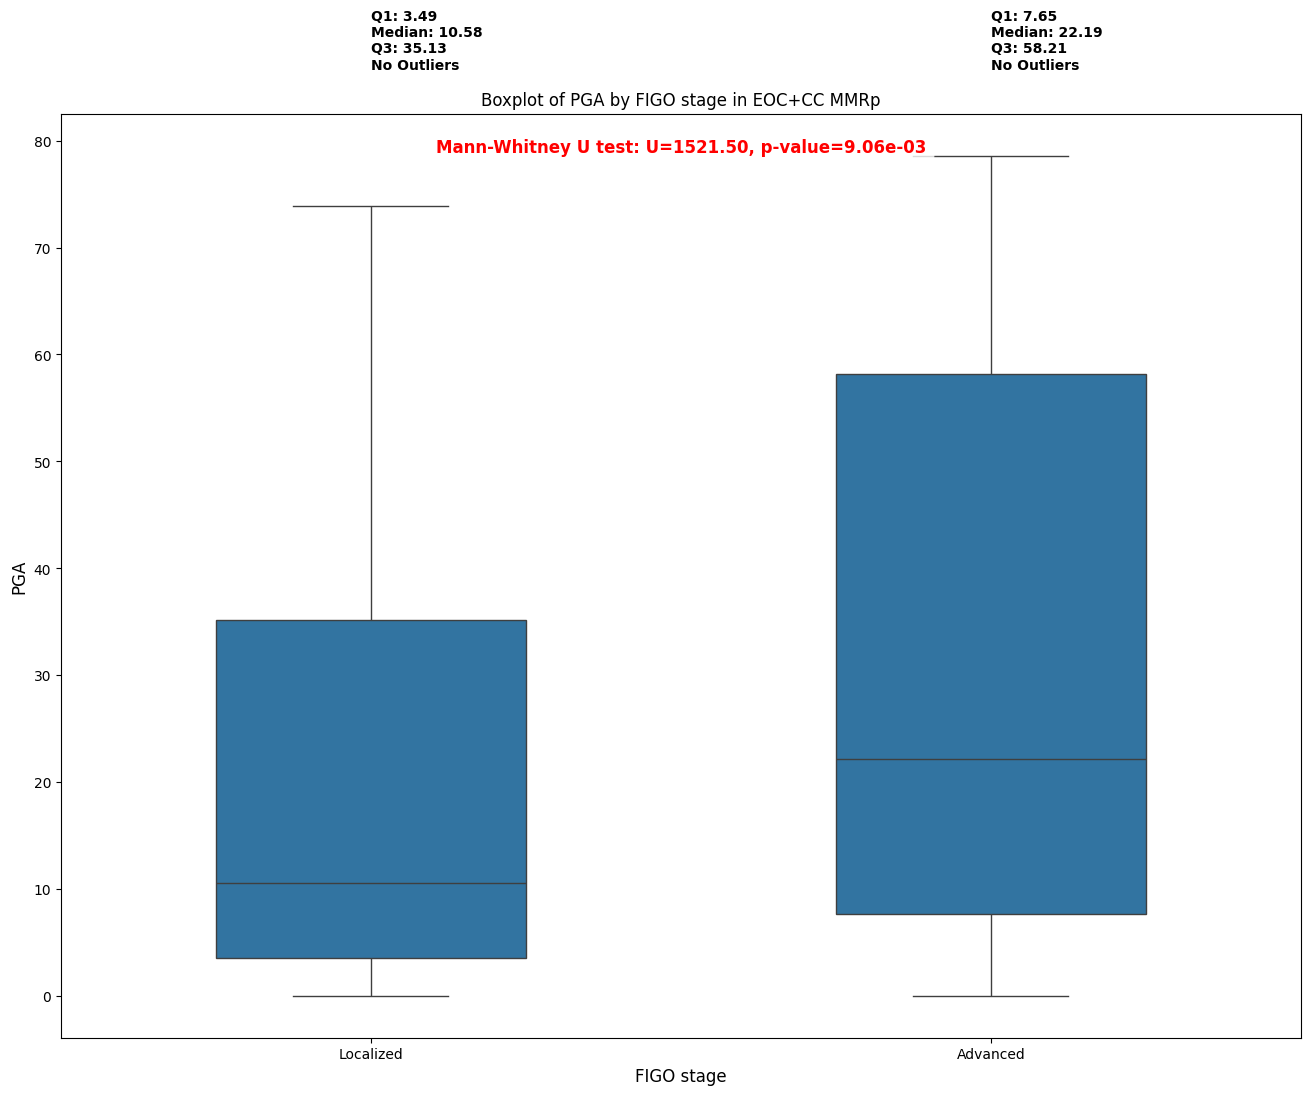

In [41]:
#### Analysis of statistics and distribution of percentage of genome altered values in FIGOL categories in the entire MMRp cohort ########

# Uncomment to import if not done previously
#import seaborn as sns  # Library for statistical data visualization
#from scipy.stats import shapiro  # Function to test normality of data (Shapiro-Wilk test)
#from scipy.stats import levene  # Function to test equality of variances (Levene's test)
#from scipy.stats import ttest_ind  # Function for independent two-sample t-test
#from scipy.stats import mannwhitneyu  # Function for Mann-Whitney U test (non-parametric test for two groups)

def analyze_and_plot_genome_altered(df, output_folder, output_file):
    # Filter only "Localized" and "Advanced" categories in FIGOL
    df = df[df['FIGOL'].isin(['Localized', 'Advanced'])]

    # Dictionary to store outlier statistics
    outliers_dict = {}

    # Dictionary to store the number of samples in each category
    sample_counts = df['FIGOL'].value_counts().to_dict()
    print(f"Number of samples in each category:")
    for category, count in sample_counts.items():
        print(f"{category}: {count}")

    # Create a figure for the boxplot
    plt.figure(figsize=(16, 12))  # Increased size for better visibility
    sns.boxplot(x='FIGOL', y='%genome_altered', data=df, width=0.5)  # Adjust the width of the boxes

    # Variables to store data for FIGO categories
    genome_altered_figoloc = []
    genome_altered_figoadv = []

    for category in df['FIGOL'].unique():
        # Filter data for the current category
        category_data = df[df['FIGOL'] == category]

        # Calculate Q1, Q3, and median
        Q1 = category_data['%genome_altered'].quantile(0.25)
        Q3 = category_data['%genome_altered'].quantile(0.75)
        median = category_data['%genome_altered'].median()
        IQR = Q3 - Q1

        # Define limits for outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Identify outliers
        outliers = category_data[(category_data['%genome_altered'] < lower_bound) | 
                                 (category_data['%genome_altered'] > upper_bound)]

        # Store outlier IDs and values
        outliers_dict[category] = {
            'Outlier_IDs': outliers['ID_CNIO'].tolist(),
            'Outlier_Values': outliers['%genome_altered'].tolist(),
            'Q1': Q1,
            'Q3': Q3,
            'Median': median
        }

        # Add data to the corresponding lists
        if category == 'Localized':
            genome_altered_figoloc = category_data['%genome_altered'].astype(float).dropna()
        elif category == 'Advanced':
            genome_altered_figoadv = category_data['%genome_altered'].astype(float).dropna()

    # Perform statistical tests
    if not genome_altered_figoloc.empty and not genome_altered_figoadv.empty:
        # Shapiro-Wilk normality test
        shapiro_loc = shapiro(genome_altered_figoloc)
        shapiro_adv = shapiro(genome_altered_figoadv)
        print(f"Shapiro-Wilk test for Localized: W={shapiro_loc.statistic:.4f}, p-value={shapiro_loc.pvalue:.4f}")
        print(f"Shapiro-Wilk test for Advanced: W={shapiro_adv.statistic:.4f}, p-value={shapiro_adv.pvalue:.4f}")
        
        # Levene's test for homogeneity of variances
        levene_test = levene(genome_altered_figoloc, genome_altered_figoadv)
        print(f"Levene's test: W={levene_test.statistic:.4f}, p-value={levene_test.pvalue:.4f}")
        
        # Select the appropriate test
        if shapiro_loc.pvalue > 0.05 and shapiro_adv.pvalue > 0.05 and levene_test.pvalue > 0.05:
            # T-test
            t_test = ttest_ind(genome_altered_figoloc, genome_altered_figoadv)
            test_result = f"T-test: t={t_test.statistic:.2f}, p-value={t_test.pvalue:.2e}"
        else:
            # Mann-Whitney U test
            mannwhitney_test = mannwhitneyu(genome_altered_figoloc, genome_altered_figoadv, alternative='two-sided')
            test_result = f"Mann-Whitney U test: U={mannwhitney_test.statistic:.2f}, p-value={mannwhitney_test.pvalue:.2e}"

        # Add the test result to the plot
        plt.gca().text(
            x=0.5, y=df['%genome_altered'].max(), 
            s=test_result,
            horizontalalignment='center', verticalalignment='bottom', 
            fontsize=12, color='red', 
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', boxstyle='round,pad=0.5'),
            weight='bold'
        )

    # Add text with outliers, Q1, Q3, and Median
    for category, stats in outliers_dict.items():
        sorted_outliers = sorted(zip(stats['Outlier_IDs'], stats['Outlier_Values']), key=lambda x: x[1])
        outlier_text = 'Outliers:\n' + '\n'.join([f'{id_}: {val:.2f}' for id_, val in sorted_outliers]) if stats['Outlier_Values'] else 'No Outliers'
        
        # Always include Q1, Median, and Q3 in the text box
        summary_stats_text = f"Q1: {stats['Q1']:.2f}\nMedian: {stats['Median']:.2f}\nQ3: {stats['Q3']:.2f}\n{outlier_text}"
        
        x_pos = df['FIGOL'].unique().tolist().index(category)
        plt.gca().text(
            x=x_pos, 
            y=df['%genome_altered'].max() + 0.1 * (df['%genome_altered'].max() - df['%genome_altered'].min()), 
            s=summary_stats_text,
            horizontalalignment='left', verticalalignment='bottom', 
            fontsize=10, color='black',
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.5'),
            weight='bold'
        )

    # Set title and labels for the plot
    plt.title('Boxplot of PGA by FIGO stage in EOC+CC MMRp', fontsize=12)
    plt.xlabel('FIGO stage', fontsize=12)
    plt.ylabel('PGA', fontsize=12)
    
    # Save the plot as a PDF file
    plt.savefig(f'{output_folder}/{output_file}', format='pdf', bbox_inches='tight')
    
    # Show the plot
    plt.show()

# Define output folder and file and call the function
output_folder = '/home/vant/TFM/Plots_TFM_final/'
output_file = 'Boxplot_MMRp_PGA_by_FIGOL.pdf'  
analyze_and_plot_genome_altered(df_all_mmrp, output_folder, output_file)

Number of samples in each category:
Localized: 63
Advanced: 13
Shapiro-Wilk test for Localized: W=0.8377, p-value=0.0000
Shapiro-Wilk test for Advanced: W=0.8448, p-value=0.0244
Levene's test: W=0.0342, p-value=0.8539


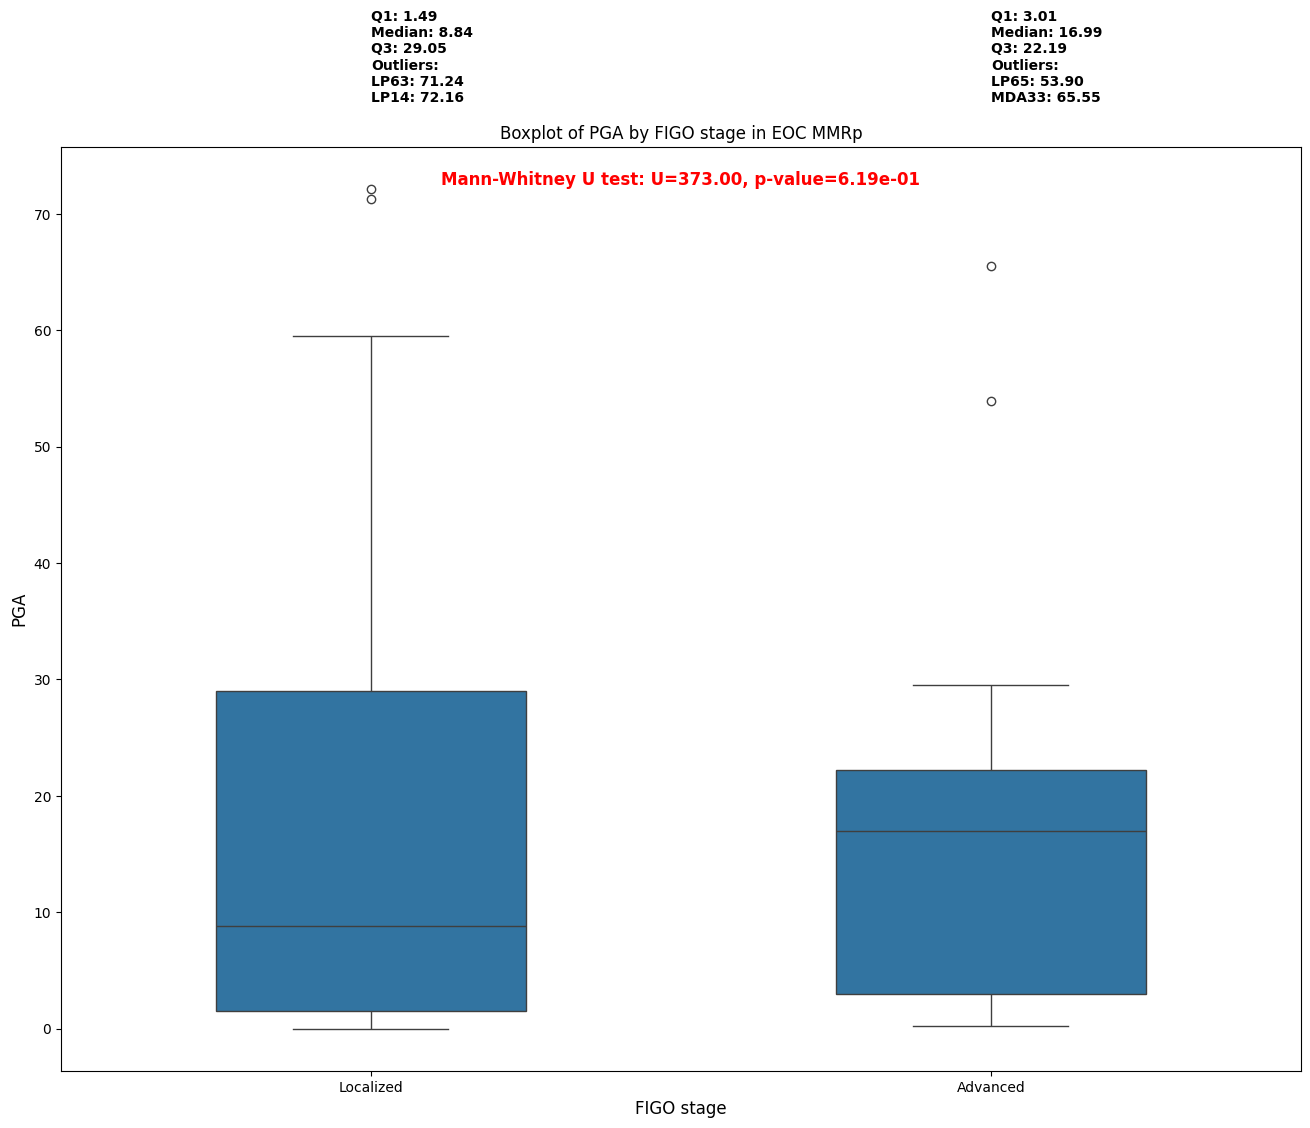

In [42]:
#### Analysis of statistics and distribution of percentage of genome altered values in FIGOL categories in the EOC MMRp cohort ########

# Uncomment to import if not done previously
#import seaborn as sns  # Library for statistical data visualization
#from scipy.stats import shapiro  # Function to test normality of data (Shapiro-Wilk test)
#from scipy.stats import levene  # Function to test equality of variances (Levene's test)
#from scipy.stats import ttest_ind  # Function for independent two-sample t-test
#from scipy.stats import mannwhitneyu  # Function for Mann-Whitney U test (non-parametric test for two groups)

def analyze_and_plot_genome_altered(df, output_folder, output_file):
    # Filter only "Localized" and "Advanced" categories in FIGOL
    df = df[df['FIGOL'].isin(['Localized', 'Advanced'])]

    # Dictionary to store outlier statistics
    outliers_dict = {}

    # Dictionary to store the number of samples in each category
    sample_counts = df['FIGOL'].value_counts().to_dict()
    print(f"Number of samples in each category:")
    for category, count in sample_counts.items():
        print(f"{category}: {count}")

    # Create a figure for the boxplot
    plt.figure(figsize=(16, 12))  # Increased size for better visibility
    sns.boxplot(x='FIGOL', y='%genome_altered', data=df, width=0.5)  # Adjust the width of the boxes

    # Variables to store data for FIGO categories
    genome_altered_figoloc = []
    genome_altered_figoadv = []

    for category in df['FIGOL'].unique():
        # Filter data for the current category
        category_data = df[df['FIGOL'] == category]

        # Calculate Q1, Q3, and median
        Q1 = category_data['%genome_altered'].quantile(0.25)
        Q3 = category_data['%genome_altered'].quantile(0.75)
        median = category_data['%genome_altered'].median()
        IQR = Q3 - Q1

        # Define limits for outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Identify outliers
        outliers = category_data[(category_data['%genome_altered'] < lower_bound) | 
                                 (category_data['%genome_altered'] > upper_bound)]

        # Store outlier IDs and values
        outliers_dict[category] = {
            'Outlier_IDs': outliers['ID_CNIO'].tolist(),
            'Outlier_Values': outliers['%genome_altered'].tolist(),
            'Q1': Q1,
            'Q3': Q3,
            'Median': median
        }

        # Add data to the corresponding lists
        if category == 'Localized':
            genome_altered_figoloc = category_data['%genome_altered'].astype(float).dropna()
        elif category == 'Advanced':
            genome_altered_figoadv = category_data['%genome_altered'].astype(float).dropna()

    # Perform statistical tests
    if not genome_altered_figoloc.empty and not genome_altered_figoadv.empty:
        # Shapiro-Wilk normality test
        shapiro_loc = shapiro(genome_altered_figoloc)
        shapiro_adv = shapiro(genome_altered_figoadv)
        print(f"Shapiro-Wilk test for Localized: W={shapiro_loc.statistic:.4f}, p-value={shapiro_loc.pvalue:.4f}")
        print(f"Shapiro-Wilk test for Advanced: W={shapiro_adv.statistic:.4f}, p-value={shapiro_adv.pvalue:.4f}")
        
        # Levene's test for homogeneity of variances
        levene_test = levene(genome_altered_figoloc, genome_altered_figoadv)
        print(f"Levene's test: W={levene_test.statistic:.4f}, p-value={levene_test.pvalue:.4f}")
        
        # Select the appropriate test
        if shapiro_loc.pvalue > 0.05 and shapiro_adv.pvalue > 0.05 and levene_test.pvalue > 0.05:
            # T-test
            t_test = ttest_ind(genome_altered_figoloc, genome_altered_figoadv)
            test_result = f"T-test: t={t_test.statistic:.2f}, p-value={t_test.pvalue:.2e}"
        else:
            # Mann-Whitney U test
            mannwhitney_test = mannwhitneyu(genome_altered_figoloc, genome_altered_figoadv, alternative='two-sided')
            test_result = f"Mann-Whitney U test: U={mannwhitney_test.statistic:.2f}, p-value={mannwhitney_test.pvalue:.2e}"

        # Add the test result to the plot
        plt.gca().text(
            x=0.5, y=df['%genome_altered'].max(), 
            s=test_result,
            horizontalalignment='center', verticalalignment='bottom', 
            fontsize=12, color='red', 
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', boxstyle='round,pad=0.5'),
            weight='bold'
        )

    # Add text with outliers, Q1, Q3, and Median
    for category, stats in outliers_dict.items():
        sorted_outliers = sorted(zip(stats['Outlier_IDs'], stats['Outlier_Values']), key=lambda x: x[1])
        outlier_text = 'Outliers:\n' + '\n'.join([f'{id_}: {val:.2f}' for id_, val in sorted_outliers]) if stats['Outlier_Values'] else 'No Outliers'
        
        # Always include Q1, Median, and Q3 in the text box
        summary_stats_text = f"Q1: {stats['Q1']:.2f}\nMedian: {stats['Median']:.2f}\nQ3: {stats['Q3']:.2f}\n{outlier_text}"
        
        x_pos = df['FIGOL'].unique().tolist().index(category)
        plt.gca().text(
            x=x_pos, 
            y=df['%genome_altered'].max() + 0.1 * (df['%genome_altered'].max() - df['%genome_altered'].min()), 
            s=summary_stats_text,
            horizontalalignment='left', verticalalignment='bottom', 
            fontsize=10, color='black',
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.5'),
            weight='bold'
        )

    # Set title and labels for the plot
    plt.title('Boxplot of PGA by FIGO stage in EOC MMRp', fontsize=12)
    plt.xlabel('FIGO stage', fontsize=12)
    plt.ylabel('PGA', fontsize=12)
    
    # Save the plot as a PDF file
    plt.savefig(f'{output_folder}/{output_file}', format='pdf', bbox_inches='tight')
    
    # Show the plot
    plt.show()

# Define output folder and file and call the function
output_folder = '/home/vant/TFM/Plots_TFM_final/'
output_file = 'Boxplot_MMRp_EOC_PGA_by_FIGOL.pdf'  
analyze_and_plot_genome_altered(df_eoc_mmrp, output_folder, output_file)

Number of samples in each category:
Localized: 40
Advanced: 28
Shapiro-Wilk test for Localized: W=0.8569, p-value=0.0001
Shapiro-Wilk test for Advanced: W=0.8928, p-value=0.0078
Levene's test: W=2.3824, p-value=0.1275


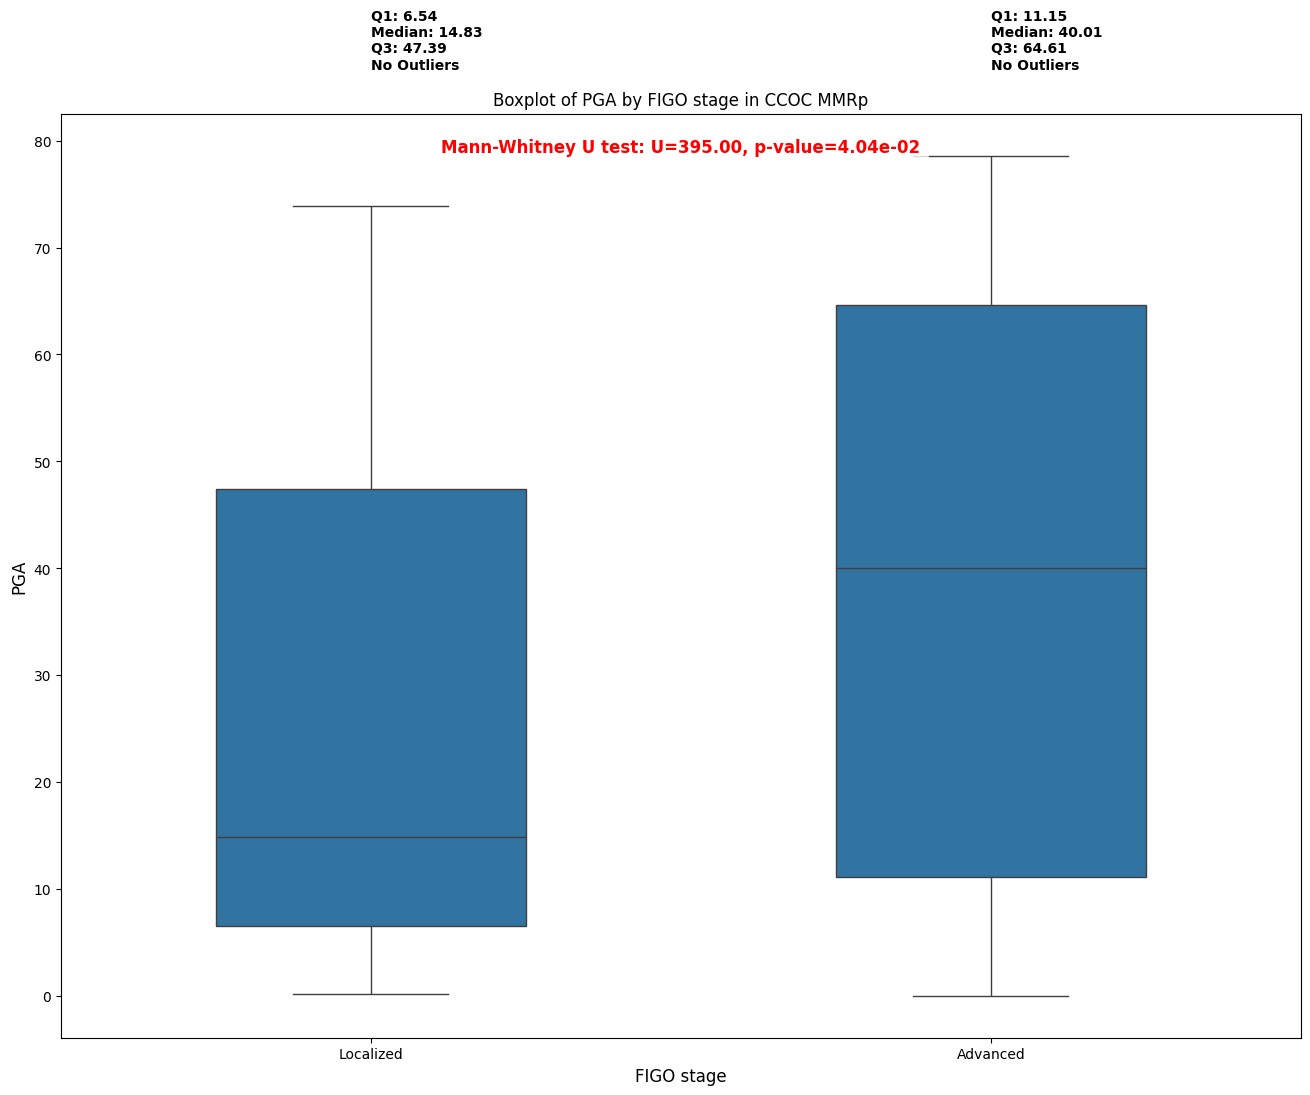

In [43]:
#### Analysis of statistics and distribution of percentage of genome altered values in FIGOL categories in the CCOC MMRp cohort ########

# Uncomment to import if not done previously
#import seaborn as sns  # Library for statistical data visualization
#from scipy.stats import shapiro  # Function to test normality of data (Shapiro-Wilk test)
#from scipy.stats import levene  # Function to test equality of variances (Levene's test)
#from scipy.stats import ttest_ind  # Function for independent two-sample t-test
#from scipy.stats import mannwhitneyu  # Function for Mann-Whitney U test (non-parametric test for two groups)

def analyze_and_plot_genome_altered(df, output_folder, output_file):
    # Filter only "Localized" and "Advanced" categories in FIGOL
    df = df[df['FIGOL'].isin(['Localized', 'Advanced'])]

    # Dictionary to store outlier statistics
    outliers_dict = {}

    # Dictionary to store the number of samples in each category
    sample_counts = df['FIGOL'].value_counts().to_dict()
    print(f"Number of samples in each category:")
    for category, count in sample_counts.items():
        print(f"{category}: {count}")

    # Create a figure for the boxplot
    plt.figure(figsize=(16, 12))  # Increased size for better visibility
    sns.boxplot(x='FIGOL', y='%genome_altered', data=df, width=0.5)  # Adjust the width of the boxes

    # Variables to store data for FIGO categories
    genome_altered_figoloc = []
    genome_altered_figoadv = []

    for category in df['FIGOL'].unique():
        # Filter data for the current category
        category_data = df[df['FIGOL'] == category]

        # Calculate Q1, Q3, and median
        Q1 = category_data['%genome_altered'].quantile(0.25)
        Q3 = category_data['%genome_altered'].quantile(0.75)
        median = category_data['%genome_altered'].median()
        IQR = Q3 - Q1

        # Define limits for outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Identify outliers
        outliers = category_data[(category_data['%genome_altered'] < lower_bound) | 
                                 (category_data['%genome_altered'] > upper_bound)]

        # Store outlier IDs and values
        outliers_dict[category] = {
            'Outlier_IDs': outliers['ID_CNIO'].tolist(),
            'Outlier_Values': outliers['%genome_altered'].tolist(),
            'Q1': Q1,
            'Q3': Q3,
            'Median': median
        }

        # Add data to the corresponding lists
        if category == 'Localized':
            genome_altered_figoloc = category_data['%genome_altered'].astype(float).dropna()
        elif category == 'Advanced':
            genome_altered_figoadv = category_data['%genome_altered'].astype(float).dropna()

    # Perform statistical tests
    if not genome_altered_figoloc.empty and not genome_altered_figoadv.empty:
        # Shapiro-Wilk normality test
        shapiro_loc = shapiro(genome_altered_figoloc)
        shapiro_adv = shapiro(genome_altered_figoadv)
        print(f"Shapiro-Wilk test for Localized: W={shapiro_loc.statistic:.4f}, p-value={shapiro_loc.pvalue:.4f}")
        print(f"Shapiro-Wilk test for Advanced: W={shapiro_adv.statistic:.4f}, p-value={shapiro_adv.pvalue:.4f}")
        
        # Levene's test for homogeneity of variances
        levene_test = levene(genome_altered_figoloc, genome_altered_figoadv)
        print(f"Levene's test: W={levene_test.statistic:.4f}, p-value={levene_test.pvalue:.4f}")
        
        # Select the appropriate test
        if shapiro_loc.pvalue > 0.05 and shapiro_adv.pvalue > 0.05 and levene_test.pvalue > 0.05:
            # T-test
            t_test = ttest_ind(genome_altered_figoloc, genome_altered_figoadv)
            test_result = f"T-test: t={t_test.statistic:.2f}, p-value={t_test.pvalue:.2e}"
        else:
            # Mann-Whitney U test
            mannwhitney_test = mannwhitneyu(genome_altered_figoloc, genome_altered_figoadv, alternative='two-sided')
            test_result = f"Mann-Whitney U test: U={mannwhitney_test.statistic:.2f}, p-value={mannwhitney_test.pvalue:.2e}"

        # Add the test result to the plot
        plt.gca().text(
            x=0.5, y=df['%genome_altered'].max(), 
            s=test_result,
            horizontalalignment='center', verticalalignment='bottom', 
            fontsize=12, color='red', 
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', boxstyle='round,pad=0.5'),
            weight='bold'
        )

    # Add text with outliers, Q1, Q3, and Median
    for category, stats in outliers_dict.items():
        sorted_outliers = sorted(zip(stats['Outlier_IDs'], stats['Outlier_Values']), key=lambda x: x[1])
        outlier_text = 'Outliers:\n' + '\n'.join([f'{id_}: {val:.2f}' for id_, val in sorted_outliers]) if stats['Outlier_Values'] else 'No Outliers'
        
        # Always include Q1, Median, and Q3 in the text box
        summary_stats_text = f"Q1: {stats['Q1']:.2f}\nMedian: {stats['Median']:.2f}\nQ3: {stats['Q3']:.2f}\n{outlier_text}"
        
        x_pos = df['FIGOL'].unique().tolist().index(category)
        plt.gca().text(
            x=x_pos, 
            y=df['%genome_altered'].max() + 0.1 * (df['%genome_altered'].max() - df['%genome_altered'].min()), 
            s=summary_stats_text,
            horizontalalignment='left', verticalalignment='bottom', 
            fontsize=10, color='black',
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.5'),
            weight='bold'
        )

    # Set title and labels for the plot
    plt.title('Boxplot of PGA by FIGO stage in CCOC MMRp', fontsize=12)
    plt.xlabel('FIGO stage', fontsize=12)
    plt.ylabel('PGA', fontsize=12)
    
    # Save the plot as a PDF file
    plt.savefig(f'{output_folder}/{output_file}', format='pdf', bbox_inches='tight')
    
    # Show the plot
    plt.show()

# Define output folder and file and call the function
output_folder = '/home/vant/TFM/Plots_TFM_final/'
output_file = 'Boxplot_MMRp_CCOC_PGA_by_FIGOL.pdf'  
analyze_and_plot_genome_altered(df_cc_mmrp, output_folder, output_file)

Number of samples in each category:
Localized: 103
Advanced: 41
Shapiro-Wilk test for Localized: W=0.7565, p-value=0.0000
Shapiro-Wilk test for Advanced: W=0.8308, p-value=0.0000
Levene's test: W=13.0421, p-value=0.0004


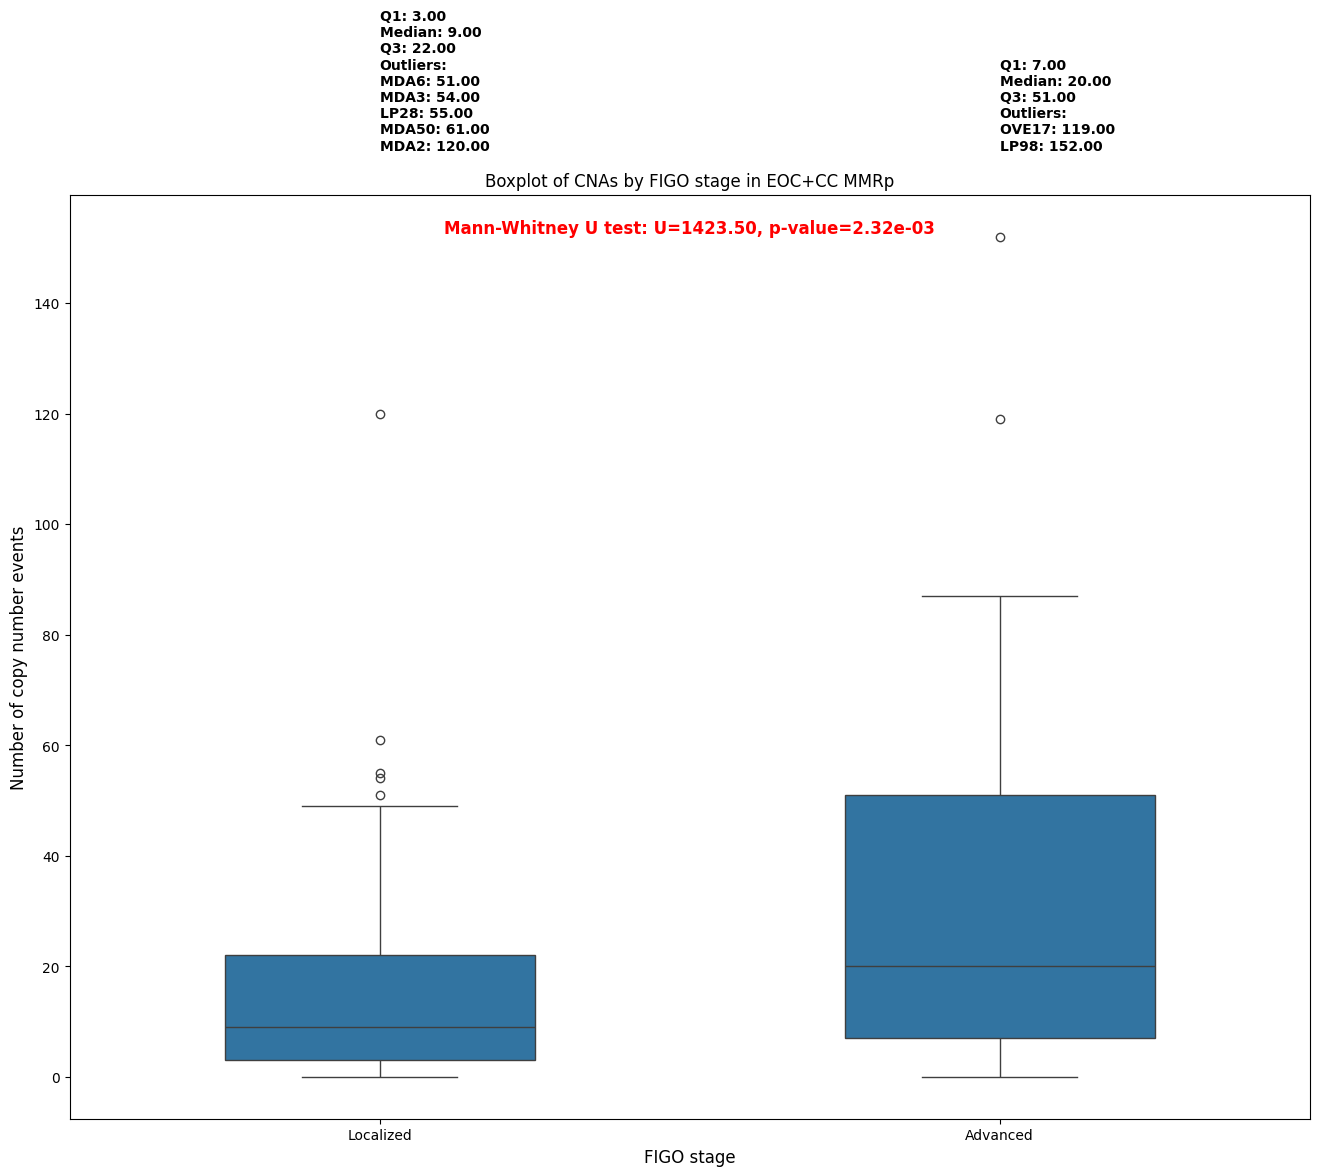

In [44]:
#### Analysis of statistics and distribution of copy number events (CNAs) in FIGOL categories in the entire MMRp cohort ########

# Uncomment to import if not done previously
#import seaborn as sns  # Library for statistical data visualization
#from scipy.stats import shapiro  # Function to test normality of data (Shapiro-Wilk test)
#from scipy.stats import levene  # Function to test equality of variances (Levene's test)
#from scipy.stats import ttest_ind  # Function for independent two-sample t-test
#from scipy.stats import mannwhitneyu  # Function for Mann-Whitney U test (non-parametric test for two groups)

def analyze_and_plot_cnv(df, output_folder, output_file):
    # Filter only "Localized" and "Advanced" categories in FIGOL
    df = df[df['FIGOL'].isin(['Localized', 'Advanced'])]

    # Dictionary to store outlier statistics
    outliers_dict = {}

    # Dictionary to store the number of samples in each category
    sample_counts = df['FIGOL'].value_counts().to_dict()
    print(f"Number of samples in each category:")
    for category, count in sample_counts.items():
        print(f"{category}: {count}")

    # Create a figure for the boxplot
    plt.figure(figsize=(16, 12))  # Increased size for better visibility
    sns.boxplot(x='FIGOL', y='CNV', data=df, width=0.5)  # Adjust the width of the boxes

    # Variables to store data for FIGO categories
    CNV_figoloc = []
    CNV_figoadv = []

    for category in df['FIGOL'].unique():
        # Filter data for the current category
        category_data = df[df['FIGOL'] == category]

        # Calculate Q1, Q3, and median
        Q1 = category_data['CNV'].quantile(0.25)
        Q3 = category_data['CNV'].quantile(0.75)
        median = category_data['CNV'].median()
        IQR = Q3 - Q1

        # Define limits for outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Identify outliers
        outliers = category_data[(category_data['CNV'] < lower_bound) | 
                                 (category_data['CNV'] > upper_bound)]

        # Store outlier IDs and values
        outliers_dict[category] = {
            'Outlier_IDs': outliers['ID_CNIO'].tolist(),
            'Outlier_Values': outliers['CNV'].tolist(),
            'Q1': Q1,
            'Q3': Q3,
            'Median': median
        }

        # Add data to the corresponding lists
        if category == 'Localized':
            CNV_figoloc = category_data['CNV'].astype(float).dropna()
        elif category == 'Advanced':
            CNV_figoadv = category_data['CNV'].astype(float).dropna()

    # Perform statistical tests
    if not CNV_figoloc.empty and not CNV_figoadv.empty:
        # Shapiro-Wilk normality test
        shapiro_loc = shapiro(CNV_figoloc)
        shapiro_adv = shapiro(CNV_figoadv)
        print(f"Shapiro-Wilk test for Localized: W={shapiro_loc.statistic:.4f}, p-value={shapiro_loc.pvalue:.4f}")
        print(f"Shapiro-Wilk test for Advanced: W={shapiro_adv.statistic:.4f}, p-value={shapiro_adv.pvalue:.4f}")
        
        # Levene's test for homogeneity of variances
        levene_test = levene(CNV_figoloc, CNV_figoadv)
        print(f"Levene's test: W={levene_test.statistic:.4f}, p-value={levene_test.pvalue:.4f}")
        
        # Select the appropriate test
        if shapiro_loc.pvalue > 0.05 and shapiro_adv.pvalue > 0.05 and levene_test.pvalue > 0.05:
            # T-test
            t_test = ttest_ind(CNV_figoloc, CNV_figoadv)
            test_result = f"T-test: t={t_test.statistic:.2f}, p-value={t_test.pvalue:.2e}"
        else:
            # Mann-Whitney U test
            mannwhitney_test = mannwhitneyu(CNV_figoloc, CNV_figoadv, alternative='two-sided')
            test_result = f"Mann-Whitney U test: U={mannwhitney_test.statistic:.2f}, p-value={mannwhitney_test.pvalue:.2e}"

        # Add the test result to the plot
        plt.gca().text(
            x=0.5, y=df['CNV'].max(), 
            s=test_result,
            horizontalalignment='center', verticalalignment='bottom', 
            fontsize=12, color='red', 
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', boxstyle='round,pad=0.5'),
            weight='bold'
        )

    # Add text with outliers, Q1, Q3, and Median
    for category, stats in outliers_dict.items():
        sorted_outliers = sorted(zip(stats['Outlier_IDs'], stats['Outlier_Values']), key=lambda x: x[1])
        outlier_text = 'Outliers:\n' + '\n'.join([f'{id_}: {val:.2f}' for id_, val in sorted_outliers]) if stats['Outlier_Values'] else 'No Outliers'
        
        # Always include Q1, Median, and Q3 in the text box
        summary_stats_text = f"Q1: {stats['Q1']:.2f}\nMedian: {stats['Median']:.2f}\nQ3: {stats['Q3']:.2f}\n{outlier_text}"
        
        x_pos = df['FIGOL'].unique().tolist().index(category)
        plt.gca().text(
            x=x_pos, 
            y=df['CNV'].max() + 0.1 * (df['CNV'].max() - df['CNV'].min()), 
            s=summary_stats_text,
            horizontalalignment='left', verticalalignment='bottom', 
            fontsize=10, color='black',
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.5'),
            weight='bold'
        )

    # Set title and labels for the plot
    plt.title('Boxplot of CNAs by FIGO stage in EOC+CC MMRp', fontsize=12)
    plt.xlabel('FIGO stage', fontsize=12)
    plt.ylabel('Number of copy number events', fontsize=12)
    
    # Save the plot as a PDF file
    plt.savefig(f'{output_folder}/{output_file}', format='pdf', bbox_inches='tight')
    
    # Show the plot
    plt.show()

# Define output folder and file and call the function
output_folder = '/home/vant/TFM/Plots_TFM_final/'
output_file = 'Boxplot_MMRp_CNAs_by_FIGOL.pdf'  
analyze_and_plot_cnv(df_all_mmrp, output_folder, output_file)

Number of samples in each category:
Localized: 63
Advanced: 13
Shapiro-Wilk test for Localized: W=0.6518, p-value=0.0000
Shapiro-Wilk test for Advanced: W=0.5982, p-value=0.0001
Levene's test: W=0.1583, p-value=0.6919


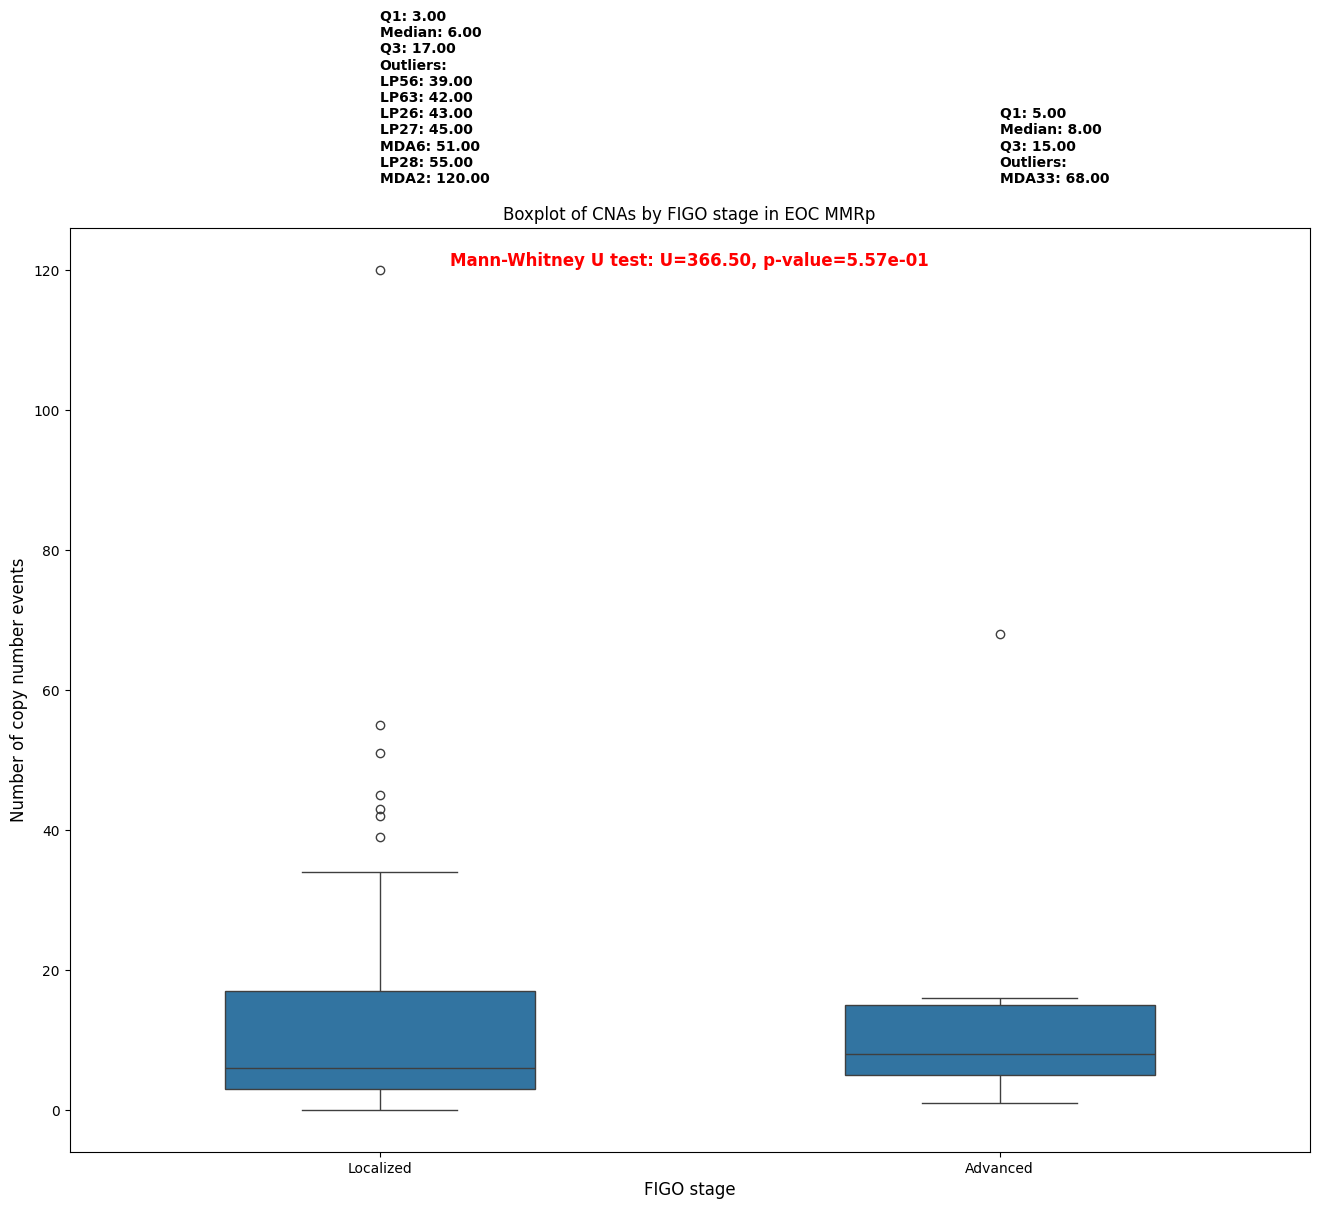

In [45]:
#### Analysis of statistics and distribution of copy number events (CNAs) in FIGOL categories in the EOC MMRp cohort ########

# Uncomment to import if not done previously
#import seaborn as sns  # Library for statistical data visualization
#from scipy.stats import shapiro  # Function to test normality of data (Shapiro-Wilk test)
#from scipy.stats import levene  # Function to test equality of variances (Levene's test)
#from scipy.stats import ttest_ind  # Function for independent two-sample t-test
#from scipy.stats import mannwhitneyu  # Function for Mann-Whitney U test (non-parametric test for two groups)

def analyze_and_plot_cnv(df, output_folder, output_file):
    # Filter only "Localized" and "Advanced" categories in FIGOL
    df = df[df['FIGOL'].isin(['Localized', 'Advanced'])]

    # Dictionary to store outlier statistics
    outliers_dict = {}

    # Dictionary to store the number of samples in each category
    sample_counts = df['FIGOL'].value_counts().to_dict()
    print(f"Number of samples in each category:")
    for category, count in sample_counts.items():
        print(f"{category}: {count}")

    # Create a figure for the boxplot
    plt.figure(figsize=(16, 12))  # Increased size for better visibility
    sns.boxplot(x='FIGOL', y='CNV', data=df, width=0.5)  # Adjust the width of the boxes

    # Variables to store data for FIGO categories
    CNV_figoloc = []
    CNV_figoadv = []

    for category in df['FIGOL'].unique():
        # Filter data for the current category
        category_data = df[df['FIGOL'] == category]

        # Calculate Q1, Q3, and median
        Q1 = category_data['CNV'].quantile(0.25)
        Q3 = category_data['CNV'].quantile(0.75)
        median = category_data['CNV'].median()
        IQR = Q3 - Q1

        # Define limits for outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Identify outliers
        outliers = category_data[(category_data['CNV'] < lower_bound) | 
                                 (category_data['CNV'] > upper_bound)]

        # Store outlier IDs and values
        outliers_dict[category] = {
            'Outlier_IDs': outliers['ID_CNIO'].tolist(),
            'Outlier_Values': outliers['CNV'].tolist(),
            'Q1': Q1,
            'Q3': Q3,
            'Median': median
        }

        # Add data to the corresponding lists
        if category == 'Localized':
            CNV_figoloc = category_data['CNV'].astype(float).dropna()
        elif category == 'Advanced':
            CNV_figoadv = category_data['CNV'].astype(float).dropna()

    # Perform statistical tests
    if not CNV_figoloc.empty and not CNV_figoadv.empty:
        # Shapiro-Wilk normality test
        shapiro_loc = shapiro(CNV_figoloc)
        shapiro_adv = shapiro(CNV_figoadv)
        print(f"Shapiro-Wilk test for Localized: W={shapiro_loc.statistic:.4f}, p-value={shapiro_loc.pvalue:.4f}")
        print(f"Shapiro-Wilk test for Advanced: W={shapiro_adv.statistic:.4f}, p-value={shapiro_adv.pvalue:.4f}")
        
        # Levene's test for homogeneity of variances
        levene_test = levene(CNV_figoloc, CNV_figoadv)
        print(f"Levene's test: W={levene_test.statistic:.4f}, p-value={levene_test.pvalue:.4f}")
        
        # Select the appropriate test
        if shapiro_loc.pvalue > 0.05 and shapiro_adv.pvalue > 0.05 and levene_test.pvalue > 0.05:
            # T-test
            t_test = ttest_ind(CNV_figoloc, CNV_figoadv)
            test_result = f"T-test: t={t_test.statistic:.2f}, p-value={t_test.pvalue:.2e}"
        else:
            # Mann-Whitney U test
            mannwhitney_test = mannwhitneyu(CNV_figoloc, CNV_figoadv, alternative='two-sided')
            test_result = f"Mann-Whitney U test: U={mannwhitney_test.statistic:.2f}, p-value={mannwhitney_test.pvalue:.2e}"

        # Add the test result to the plot
        plt.gca().text(
            x=0.5, y=df['CNV'].max(), 
            s=test_result,
            horizontalalignment='center', verticalalignment='bottom', 
            fontsize=12, color='red', 
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', boxstyle='round,pad=0.5'),
            weight='bold'
        )

    # Add text with outliers, Q1, Q3, and Median
    for category, stats in outliers_dict.items():
        sorted_outliers = sorted(zip(stats['Outlier_IDs'], stats['Outlier_Values']), key=lambda x: x[1])
        outlier_text = 'Outliers:\n' + '\n'.join([f'{id_}: {val:.2f}' for id_, val in sorted_outliers]) if stats['Outlier_Values'] else 'No Outliers'
        
        # Always include Q1, Median, and Q3 in the text box
        summary_stats_text = f"Q1: {stats['Q1']:.2f}\nMedian: {stats['Median']:.2f}\nQ3: {stats['Q3']:.2f}\n{outlier_text}"
        
        x_pos = df['FIGOL'].unique().tolist().index(category)
        plt.gca().text(
            x=x_pos, 
            y=df['CNV'].max() + 0.1 * (df['CNV'].max() - df['CNV'].min()), 
            s=summary_stats_text,
            horizontalalignment='left', verticalalignment='bottom', 
            fontsize=10, color='black',
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.5'),
            weight='bold'
        )

    # Set title and labels for the plot
    plt.title('Boxplot of CNAs by FIGO stage in EOC MMRp', fontsize=12)
    plt.xlabel('FIGO stage', fontsize=12)
    plt.ylabel('Number of copy number events', fontsize=12)
    
    # Save the plot as a PDF file
    plt.savefig(f'{output_folder}/{output_file}', format='pdf', bbox_inches='tight')
    
    # Show the plot
    plt.show()

# Define output folder and file and call the function
output_folder = '/home/vant/TFM/Plots_TFM_final/'
output_file = 'Boxplot_MMRp_EOC_CNAs_by_FIGOL.pdf'  
analyze_and_plot_cnv(df_eoc_mmrp, output_folder, output_file)

Number of samples in each category:
Localized: 40
Advanced: 28
Shapiro-Wilk test for Localized: W=0.8756, p-value=0.0004
Shapiro-Wilk test for Advanced: W=0.8862, p-value=0.0055
Levene's test: W=9.4880, p-value=0.0030


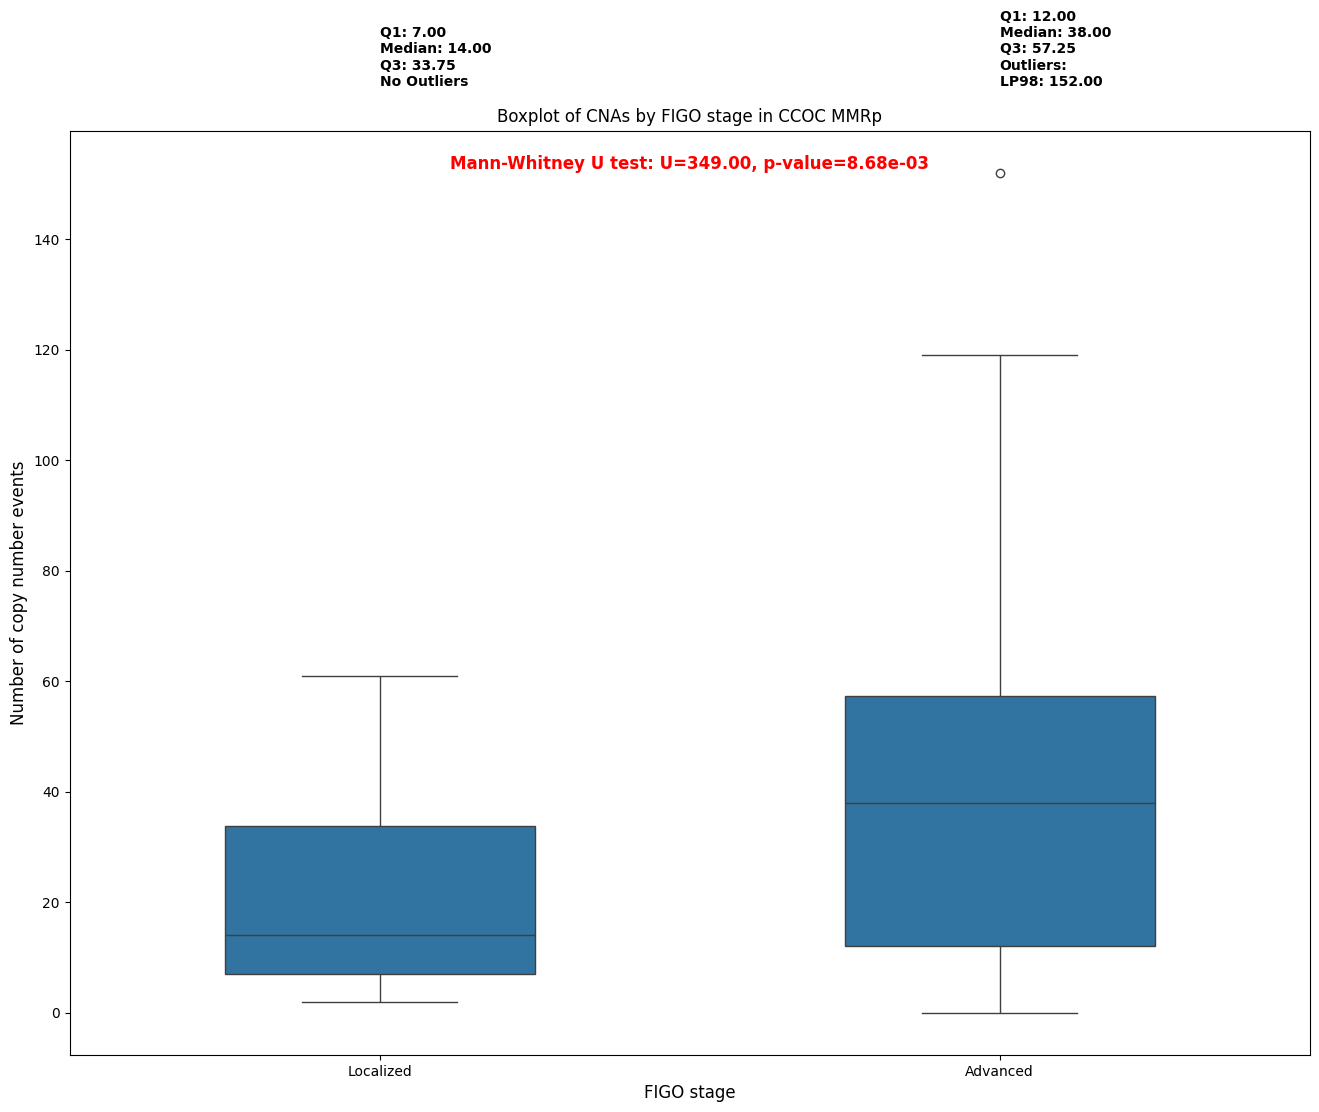

In [46]:
#### Analysis of statistics and distribution of copy number events (CNAs) in FIGOL categories in the CCOC MMRp cohort ########

# Uncomment to import if not done previously
#import seaborn as sns  # Library for statistical data visualization
#from scipy.stats import shapiro  # Function to test normality of data (Shapiro-Wilk test)
#from scipy.stats import levene  # Function to test equality of variances (Levene's test)
#from scipy.stats import ttest_ind  # Function for independent two-sample t-test
#from scipy.stats import mannwhitneyu  # Function for Mann-Whitney U test (non-parametric test for two groups)

def analyze_and_plot_cnv(df, output_folder, output_file):
    # Filter only "Localized" and "Advanced" categories in FIGOL
    df = df[df['FIGOL'].isin(['Localized', 'Advanced'])]

    # Dictionary to store outlier statistics
    outliers_dict = {}

    # Dictionary to store the number of samples in each category
    sample_counts = df['FIGOL'].value_counts().to_dict()
    print(f"Number of samples in each category:")
    for category, count in sample_counts.items():
        print(f"{category}: {count}")

    # Create a figure for the boxplot
    plt.figure(figsize=(16, 12))  # Increased size for better visibility
    sns.boxplot(x='FIGOL', y='CNV', data=df, width=0.5)  # Adjust the width of the boxes

    # Variables to store data for FIGO categories
    CNV_figoloc = []
    CNV_figoadv = []

    for category in df['FIGOL'].unique():
        # Filter data for the current category
        category_data = df[df['FIGOL'] == category]

        # Calculate Q1, Q3, and median
        Q1 = category_data['CNV'].quantile(0.25)
        Q3 = category_data['CNV'].quantile(0.75)
        median = category_data['CNV'].median()
        IQR = Q3 - Q1

        # Define limits for outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Identify outliers
        outliers = category_data[(category_data['CNV'] < lower_bound) | 
                                 (category_data['CNV'] > upper_bound)]

        # Store outlier IDs and values
        outliers_dict[category] = {
            'Outlier_IDs': outliers['ID_CNIO'].tolist(),
            'Outlier_Values': outliers['CNV'].tolist(),
            'Q1': Q1,
            'Q3': Q3,
            'Median': median
        }

        # Add data to the corresponding lists
        if category == 'Localized':
            CNV_figoloc = category_data['CNV'].astype(float).dropna()
        elif category == 'Advanced':
            CNV_figoadv = category_data['CNV'].astype(float).dropna()

    # Perform statistical tests
    if not CNV_figoloc.empty and not CNV_figoadv.empty:
        # Shapiro-Wilk normality test
        shapiro_loc = shapiro(CNV_figoloc)
        shapiro_adv = shapiro(CNV_figoadv)
        print(f"Shapiro-Wilk test for Localized: W={shapiro_loc.statistic:.4f}, p-value={shapiro_loc.pvalue:.4f}")
        print(f"Shapiro-Wilk test for Advanced: W={shapiro_adv.statistic:.4f}, p-value={shapiro_adv.pvalue:.4f}")
        
        # Levene's test for homogeneity of variances
        levene_test = levene(CNV_figoloc, CNV_figoadv)
        print(f"Levene's test: W={levene_test.statistic:.4f}, p-value={levene_test.pvalue:.4f}")
        
        # Select the appropriate test
        if shapiro_loc.pvalue > 0.05 and shapiro_adv.pvalue > 0.05 and levene_test.pvalue > 0.05:
            # T-test
            t_test = ttest_ind(CNV_figoloc, CNV_figoadv)
            test_result = f"T-test: t={t_test.statistic:.2f}, p-value={t_test.pvalue:.2e}"
        else:
            # Mann-Whitney U test
            mannwhitney_test = mannwhitneyu(CNV_figoloc, CNV_figoadv, alternative='two-sided')
            test_result = f"Mann-Whitney U test: U={mannwhitney_test.statistic:.2f}, p-value={mannwhitney_test.pvalue:.2e}"

        # Add the test result to the plot
        plt.gca().text(
            x=0.5, y=df['CNV'].max(), 
            s=test_result,
            horizontalalignment='center', verticalalignment='bottom', 
            fontsize=12, color='red', 
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', boxstyle='round,pad=0.5'),
            weight='bold'
        )

    # Add text with outliers, Q1, Q3, and Median
    for category, stats in outliers_dict.items():
        sorted_outliers = sorted(zip(stats['Outlier_IDs'], stats['Outlier_Values']), key=lambda x: x[1])
        outlier_text = 'Outliers:\n' + '\n'.join([f'{id_}: {val:.2f}' for id_, val in sorted_outliers]) if stats['Outlier_Values'] else 'No Outliers'
        
        # Always include Q1, Median, and Q3 in the text box
        summary_stats_text = f"Q1: {stats['Q1']:.2f}\nMedian: {stats['Median']:.2f}\nQ3: {stats['Q3']:.2f}\n{outlier_text}"
        
        x_pos = df['FIGOL'].unique().tolist().index(category)
        plt.gca().text(
            x=x_pos, 
            y=df['CNV'].max() + 0.1 * (df['CNV'].max() - df['CNV'].min()), 
            s=summary_stats_text,
            horizontalalignment='left', verticalalignment='bottom', 
            fontsize=10, color='black',
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.5'),
            weight='bold'
        )

    # Set title and labels for the plot
    plt.title('Boxplot of CNAs by FIGO stage in CCOC MMRp', fontsize=12)
    plt.xlabel('FIGO stage', fontsize=12)
    plt.ylabel('Number of copy number events', fontsize=12)
    
    # Save the plot as a PDF file
    plt.savefig(f'{output_folder}/{output_file}', format='pdf', bbox_inches='tight')
    
    # Show the plot
    plt.show()

# Define output folder and file and call the function
output_folder = '/home/vant/TFM/Plots_TFM_final/'
output_file = 'Boxplot_MMRp_CCOC_CNAs_by_FIGOL.pdf'  
analyze_and_plot_cnv(df_cc_mmrp, output_folder, output_file)

Number of samples in each category:
Well differentiated: 41
Moderately differentiated: 23
Poorly differentiated: 8


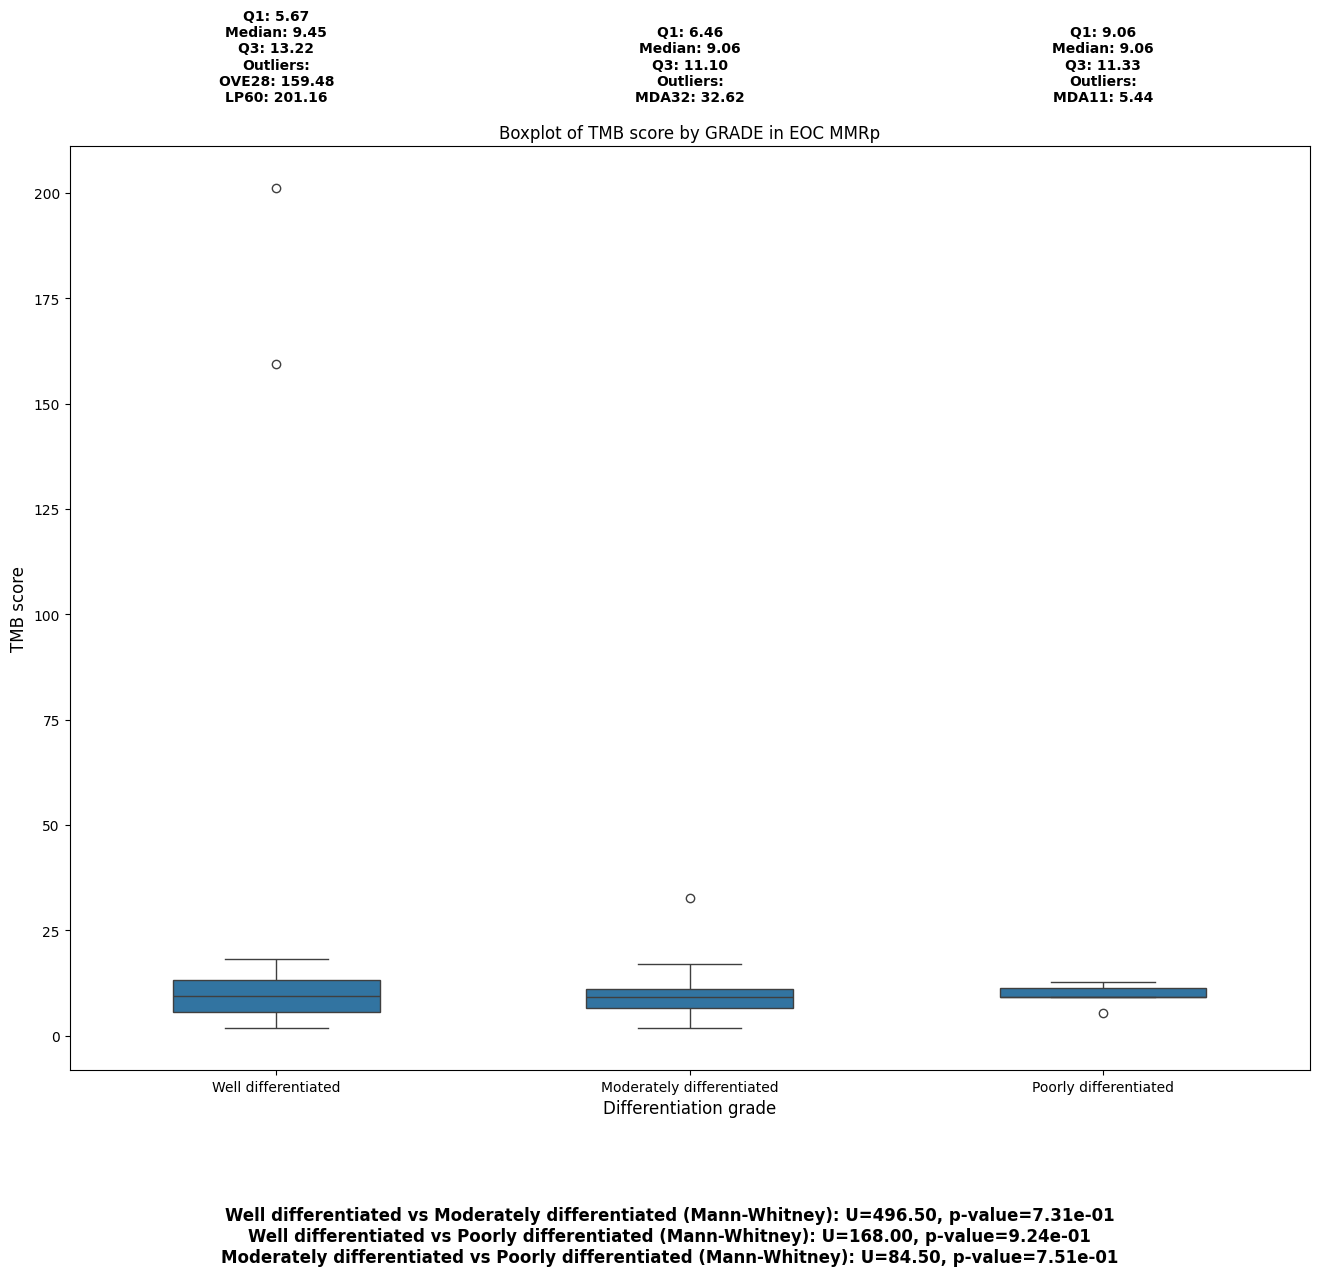

In [47]:
#### Analysis of statistics and distribution of TMB values in GRADE categories in the EOC MMRp cohort ########

# Uncomment to import if not done previously
#import seaborn as sns  # Library for statistical data visualization
#from scipy.stats import shapiro  # Function to test normality of data (Shapiro-Wilk test)
#from scipy.stats import levene  # Function to test equality of variances (Levene's test)
#from scipy.stats import ttest_ind  # Function for independent two-sample t-test
#from scipy.stats import mannwhitneyu  # Function for Mann-Whitney U test (non-parametric test for two groups)

def analyze_and_plot(df, output_folder, output_file):
    # Filter to keep only the specified categories and make a copy to avoid SettingWithCopyWarning
    df = df[df['GRADE'].isin(['Well differentiated', 'Moderately differentiated', 'Poorly differentiated'])].copy()
    
    # Convert GRADE to an ordered categorical type to ensure the correct order in the plot
    df.loc[:, 'GRADE'] = pd.Categorical(df['GRADE'], 
                                        categories=['Well differentiated', 
                                                    'Moderately differentiated', 
                                                    'Poorly differentiated'], 
                                        ordered=True)
    
    # Dictionary to store outlier statistics
    outliers_dict = {}

    # Print the number of samples in each category
    sample_counts = df['GRADE'].value_counts().to_dict()
    print("Number of samples in each category:")
    for category, count in sample_counts.items():
        print(f"{category}: {count}")
        
    # Create figure for the boxplot
    plt.figure(figsize=(16, 12))
    sns.boxplot(x='GRADE', y='TMB', data=df, width=0.5, 
                order=['Well differentiated', 'Moderately differentiated', 'Poorly differentiated'])

    # Variables to store data for each grade category
    TMB_grade_well = []
    TMB_grade_moderate = []
    TMB_grade_poor = []

    # Loop through each grade category to calculate statistics
    for category in ['Well differentiated', 'Moderately differentiated', 'Poorly differentiated']:
        # Filter data for the current category
        category_data = df[df['GRADE'] == category]
        TMB_data = category_data['TMB'].astype(float).dropna()
        
        if not TMB_data.empty:
            # Calculate Q1, Q3, and median
            Q1 = TMB_data.quantile(0.25)
            Q3 = TMB_data.quantile(0.75)
            median = TMB_data.median()
            IQR = Q3 - Q1  # Interquartile Range
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            # Identify outliers
            outliers = category_data[(category_data['TMB'] < lower_bound) | 
                                     (category_data['TMB'] > upper_bound)]
            
            # Store outlier IDs and values, along with quartile information
            outliers_dict[category] = {
                'Outlier_IDs': outliers['ID_CNIO'].tolist(),
                'Outlier_Values': outliers['TMB'].tolist(),
                'Q1': Q1,
                'Q3': Q3,
                'Median': median
            }
            # Assign data to the corresponding lists
            if category == 'Well differentiated':
                TMB_grade_well = TMB_data
            elif category == 'Moderately differentiated':
                TMB_grade_moderate = TMB_data
            elif category == 'Poorly differentiated':
                TMB_grade_poor = TMB_data

    # Perform statistical tests in the specified order
    groups = {
        'Well differentiated': TMB_grade_well,
        'Moderately differentiated': TMB_grade_moderate,
        'Poorly differentiated': TMB_grade_poor
    }

    test_results = {}
    categories = list(groups.keys())

    # Perform pairwise comparisons between categories
    for i in range(len(categories)):
        for j in range(i + 1, len(categories)):
            cat_a = categories[i]
            cat_b = categories[j]
            data_a = groups[cat_a]
            data_b = groups[cat_b]

            if not data_a.empty and not data_b.empty:
                # Shapiro-Wilk normality test
                shapiro_a = shapiro(data_a)
                shapiro_b = shapiro(data_b)
                
                # Levene's test for variance homogeneity
                levene_test = levene(data_a, data_b)
                
                # Select appropriate statistical test based on normality and variance homogeneity
                if shapiro_a.pvalue > 0.05 and shapiro_b.pvalue > 0.05 and levene_test.pvalue > 0.05:
                    # T-test for normally distributed data with equal variances
                    t_test = ttest_ind(data_a, data_b)
                    test_results[f"{cat_a} vs {cat_b} (T-test)"] = f"t={t_test.statistic:.2f}, p-value={t_test.pvalue:.2e}"
                else:
                    # Mann-Whitney U test for non-normally distributed data or unequal variances
                    mannwhitney_test = mannwhitneyu(data_a, data_b, alternative='two-sided')
                    test_results[f"{cat_a} vs {cat_b} (Mann-Whitney)"] = f"U={mannwhitney_test.statistic:.2f}, p-value={mannwhitney_test.pvalue:.2e}"

    # Add the test results as text below the plot
    text_results = "\n".join([f"{comparison}: {result}" for comparison, result in test_results.items()])
    plt.figtext(0.5, -0.05, text_results, horizontalalignment='center', fontsize=12, color='black', weight='bold', ha='center')

    # Add text boxes with outlier and summary statistics for each category
    for category, stats in outliers_dict.items():
        sorted_outliers = sorted(zip(stats['Outlier_IDs'], stats['Outlier_Values']), key=lambda x: x[1])
        outlier_text = 'Outliers:\n' + '\n'.join([f'{id_}: {val:.2f}' for id_, val in sorted_outliers]) if stats['Outlier_Values'] else 'No Outliers'
        
        # Include Q1, Median, Q3 in the summary stats text box
        summary_stats_text = f"Q1: {stats['Q1']:.2f}\nMedian: {stats['Median']:.2f}\nQ3: {stats['Q3']:.2f}\n{outlier_text}"
        
        # Position the text box near the respective category in the plot
        x_pos = ['Well differentiated', 'Moderately differentiated', 'Poorly differentiated'].index(category)
        plt.gca().text(
            x=x_pos, 
            y=df['TMB'].max() + 0.1 * (df['TMB'].max() - df['TMB'].min()), 
            s=summary_stats_text,
            horizontalalignment='center', verticalalignment='bottom', 
            fontsize=10, color='black',
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.5'),
            weight='bold'
        )
    
    # Set plot title and labels
    plt.title('Boxplot of TMB score by GRADE in EOC MMRp', fontsize=12)
    plt.xlabel('Differentiation grade', fontsize=12)
    plt.ylabel('TMB score', fontsize=12)
    
    # Save the plot as a PDF file
    plt.savefig(f'{output_folder}/{output_file}', format='pdf', bbox_inches='tight')
    plt.show()

# Define output folder and file and call the function
output_folder = '/home/vant/TFM/Plots_TFM_final/'
output_file = 'Boxplot_EOC_MMRp_TMB_by_GRADE.pdf'  
analyze_and_plot(df_eoc_mmrp, output_folder, output_file)

Number of samples in each category:
Well differentiated: 41
Moderately differentiated: 23
Poorly differentiated: 8


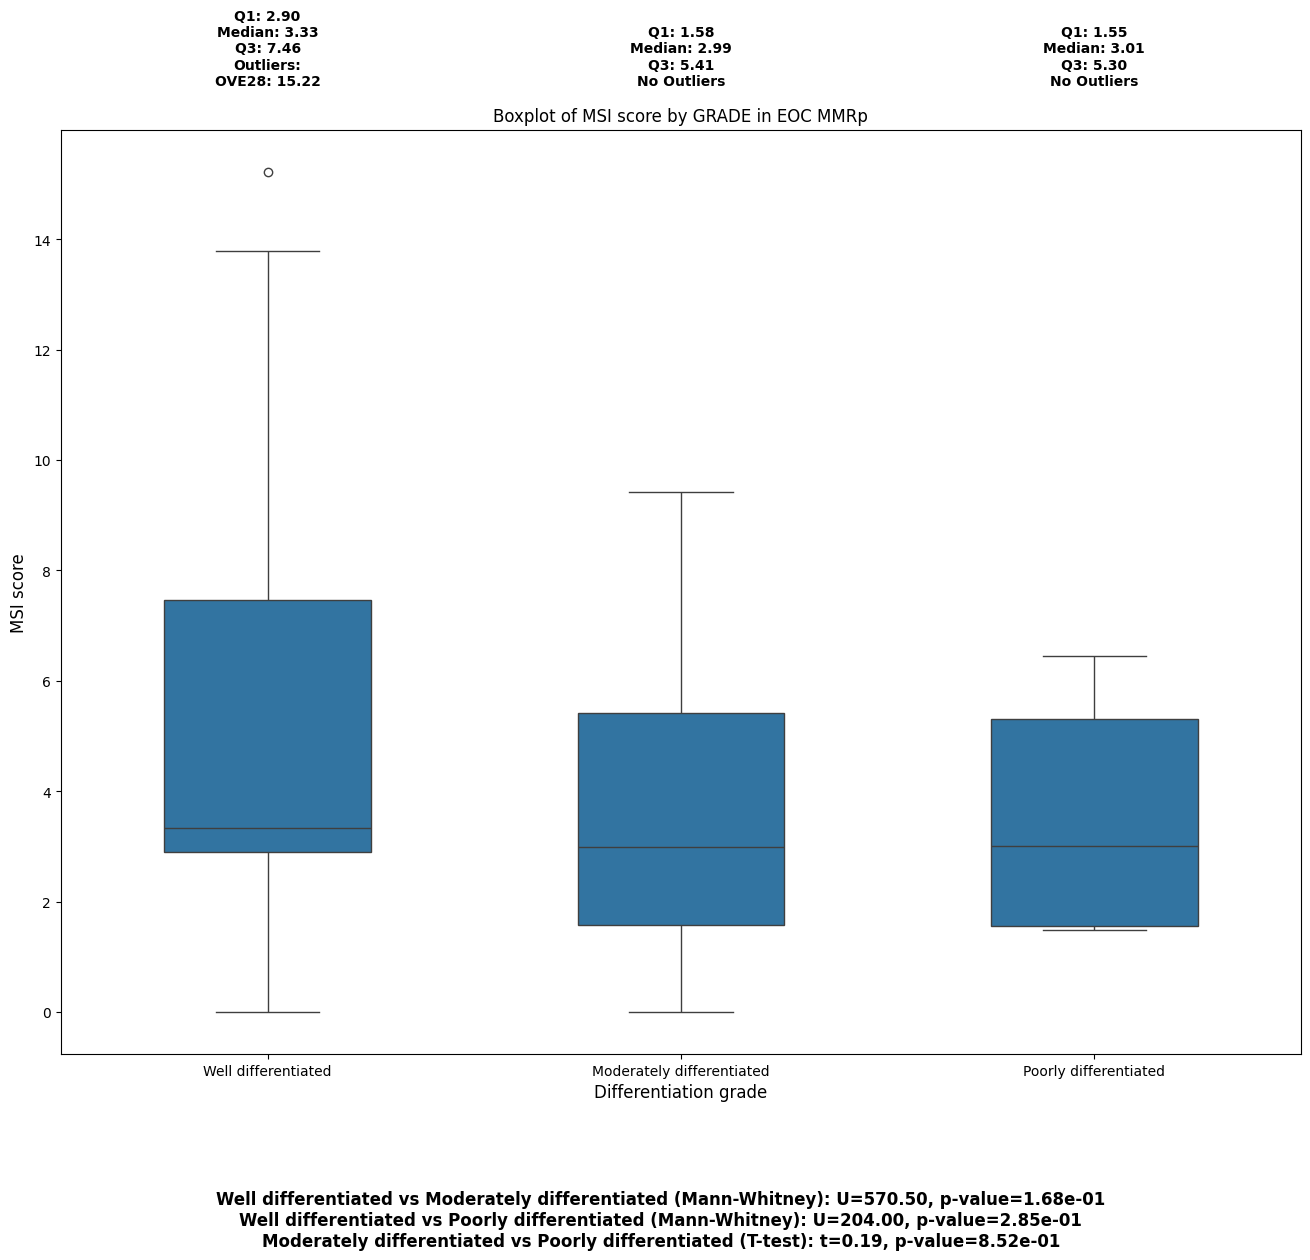

In [48]:
#### Analysis of statistics and distribution of MSI score values in GRADE categories in the EOC MMRp cohort ########

# Uncomment to import if not done previously
#import seaborn as sns  # Library for statistical data visualization
#from scipy.stats import shapiro  # Function to test normality of data (Shapiro-Wilk test)
#from scipy.stats import levene  # Function to test equality of variances (Levene's test)
#from scipy.stats import ttest_ind  # Function for independent two-sample t-test
#from scipy.stats import mannwhitneyu  # Function for Mann-Whitney U test (non-parametric test for two groups)

def analyze_and_plot(df, output_folder, output_file):
    # Filter to keep only the specified categories and make a copy to avoid SettingWithCopyWarning
    df = df[df['GRADE'].isin(['Well differentiated', 'Moderately differentiated', 'Poorly differentiated'])].copy()
    
    # Convert GRADE to an ordered categorical type to ensure the correct order in the plot
    df.loc[:, 'GRADE'] = pd.Categorical(df['GRADE'], 
                                        categories=['Well differentiated', 
                                                    'Moderately differentiated', 
                                                    'Poorly differentiated'], 
                                        ordered=True)
    
    # Dictionary to store outlier statistics
    outliers_dict = {}

    # Print the number of samples in each category
    sample_counts = df['GRADE'].value_counts().to_dict()
    print("Number of samples in each category:")
    for category, count in sample_counts.items():
        print(f"{category}: {count}")
        
    # Create figure for the boxplot
    plt.figure(figsize=(16, 12))
    sns.boxplot(x='GRADE', y='MSI_sensor2', data=df, width=0.5, 
                order=['Well differentiated', 'Moderately differentiated', 'Poorly differentiated'])

    # Variables to store data for each grade category
    MSI_sensor2_grade_well = []
    MSI_sensor2_grade_moderate = []
    MSI_sensor2_grade_poor = []

    # Loop through each grade category to calculate statistics
    for category in ['Well differentiated', 'Moderately differentiated', 'Poorly differentiated']:
        # Filter data for the current category
        category_data = df[df['GRADE'] == category]
        MSI_sensor2_data = category_data['MSI_sensor2'].astype(float).dropna()
        
        if not MSI_sensor2_data.empty:
            # Calculate Q1, Q3, and median
            Q1 = MSI_sensor2_data.quantile(0.25)
            Q3 = MSI_sensor2_data.quantile(0.75)
            median = MSI_sensor2_data.median()
            IQR = Q3 - Q1  # Interquartile Range
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            # Identify outliers
            outliers = category_data[(category_data['MSI_sensor2'] < lower_bound) | 
                                     (category_data['MSI_sensor2'] > upper_bound)]
            
            # Store outlier IDs and values, along with quartile information
            outliers_dict[category] = {
                'Outlier_IDs': outliers['ID_CNIO'].tolist(),
                'Outlier_Values': outliers['MSI_sensor2'].tolist(),
                'Q1': Q1,
                'Q3': Q3,
                'Median': median
            }
            # Assign data to the corresponding lists
            if category == 'Well differentiated':
                MSI_sensor2_grade_well = MSI_sensor2_data
            elif category == 'Moderately differentiated':
                MSI_sensor2_grade_moderate = MSI_sensor2_data
            elif category == 'Poorly differentiated':
                MSI_sensor2_grade_poor = MSI_sensor2_data

    # Perform statistical tests in the specified order
    groups = {
        'Well differentiated': MSI_sensor2_grade_well,
        'Moderately differentiated': MSI_sensor2_grade_moderate,
        'Poorly differentiated': MSI_sensor2_grade_poor
    }

    test_results = {}
    categories = list(groups.keys())

    # Perform pairwise comparisons between categories
    for i in range(len(categories)):
        for j in range(i + 1, len(categories)):
            cat_a = categories[i]
            cat_b = categories[j]
            data_a = groups[cat_a]
            data_b = groups[cat_b]

            if not data_a.empty and not data_b.empty:
                # Shapiro-Wilk normality test
                shapiro_a = shapiro(data_a)
                shapiro_b = shapiro(data_b)
                
                # Levene's test for variance homogeneity
                levene_test = levene(data_a, data_b)
                
                # Select appropriate statistical test based on normality and variance homogeneity
                if shapiro_a.pvalue > 0.05 and shapiro_b.pvalue > 0.05 and levene_test.pvalue > 0.05:
                    # T-test for normally distributed data with equal variances
                    t_test = ttest_ind(data_a, data_b)
                    test_results[f"{cat_a} vs {cat_b} (T-test)"] = f"t={t_test.statistic:.2f}, p-value={t_test.pvalue:.2e}"
                else:
                    # Mann-Whitney U test for non-normally distributed data or unequal variances
                    mannwhitney_test = mannwhitneyu(data_a, data_b, alternative='two-sided')
                    test_results[f"{cat_a} vs {cat_b} (Mann-Whitney)"] = f"U={mannwhitney_test.statistic:.2f}, p-value={mannwhitney_test.pvalue:.2e}"

    # Add the test results as text below the plot
    text_results = "\n".join([f"{comparison}: {result}" for comparison, result in test_results.items()])
    plt.figtext(0.5, -0.05, text_results, horizontalalignment='center', fontsize=12, color='black', weight='bold', ha='center')

    # Add text boxes with outlier and summary statistics for each category
    for category, stats in outliers_dict.items():
        sorted_outliers = sorted(zip(stats['Outlier_IDs'], stats['Outlier_Values']), key=lambda x: x[1])
        outlier_text = 'Outliers:\n' + '\n'.join([f'{id_}: {val:.2f}' for id_, val in sorted_outliers]) if stats['Outlier_Values'] else 'No Outliers'
        
        # Include Q1, Median, Q3 in the summary stats text box
        summary_stats_text = f"Q1: {stats['Q1']:.2f}\nMedian: {stats['Median']:.2f}\nQ3: {stats['Q3']:.2f}\n{outlier_text}"
        
        # Position the text box near the respective category in the plot
        x_pos = ['Well differentiated', 'Moderately differentiated', 'Poorly differentiated'].index(category)
        plt.gca().text(
            x=x_pos, 
            y=df['MSI_sensor2'].max() + 0.1 * (df['MSI_sensor2'].max() - df['MSI_sensor2'].min()), 
            s=summary_stats_text,
            horizontalalignment='center', verticalalignment='bottom', 
            fontsize=10, color='black',
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.5'),
            weight='bold'
        )
    
    # Set plot title and labels
    plt.title('Boxplot of MSI score by GRADE in EOC MMRp', fontsize=12)
    plt.xlabel('Differentiation grade', fontsize=12)
    plt.ylabel('MSI score', fontsize=12)
    
    # Save the plot as a PDF file
    plt.savefig(f'{output_folder}/{output_file}', format='pdf', bbox_inches='tight')
    plt.show()

# Define output folder and file and call the function
output_folder = '/home/vant/TFM/Plots_TFM_final/'
output_file = 'Boxplot_EOC_MMRp_MSIscore_by_GRADE.pdf'  
analyze_and_plot(df_eoc_mmrp, output_folder, output_file)


Number of samples in each category:
Well differentiated: 41
Moderately differentiated: 23
Poorly differentiated: 8


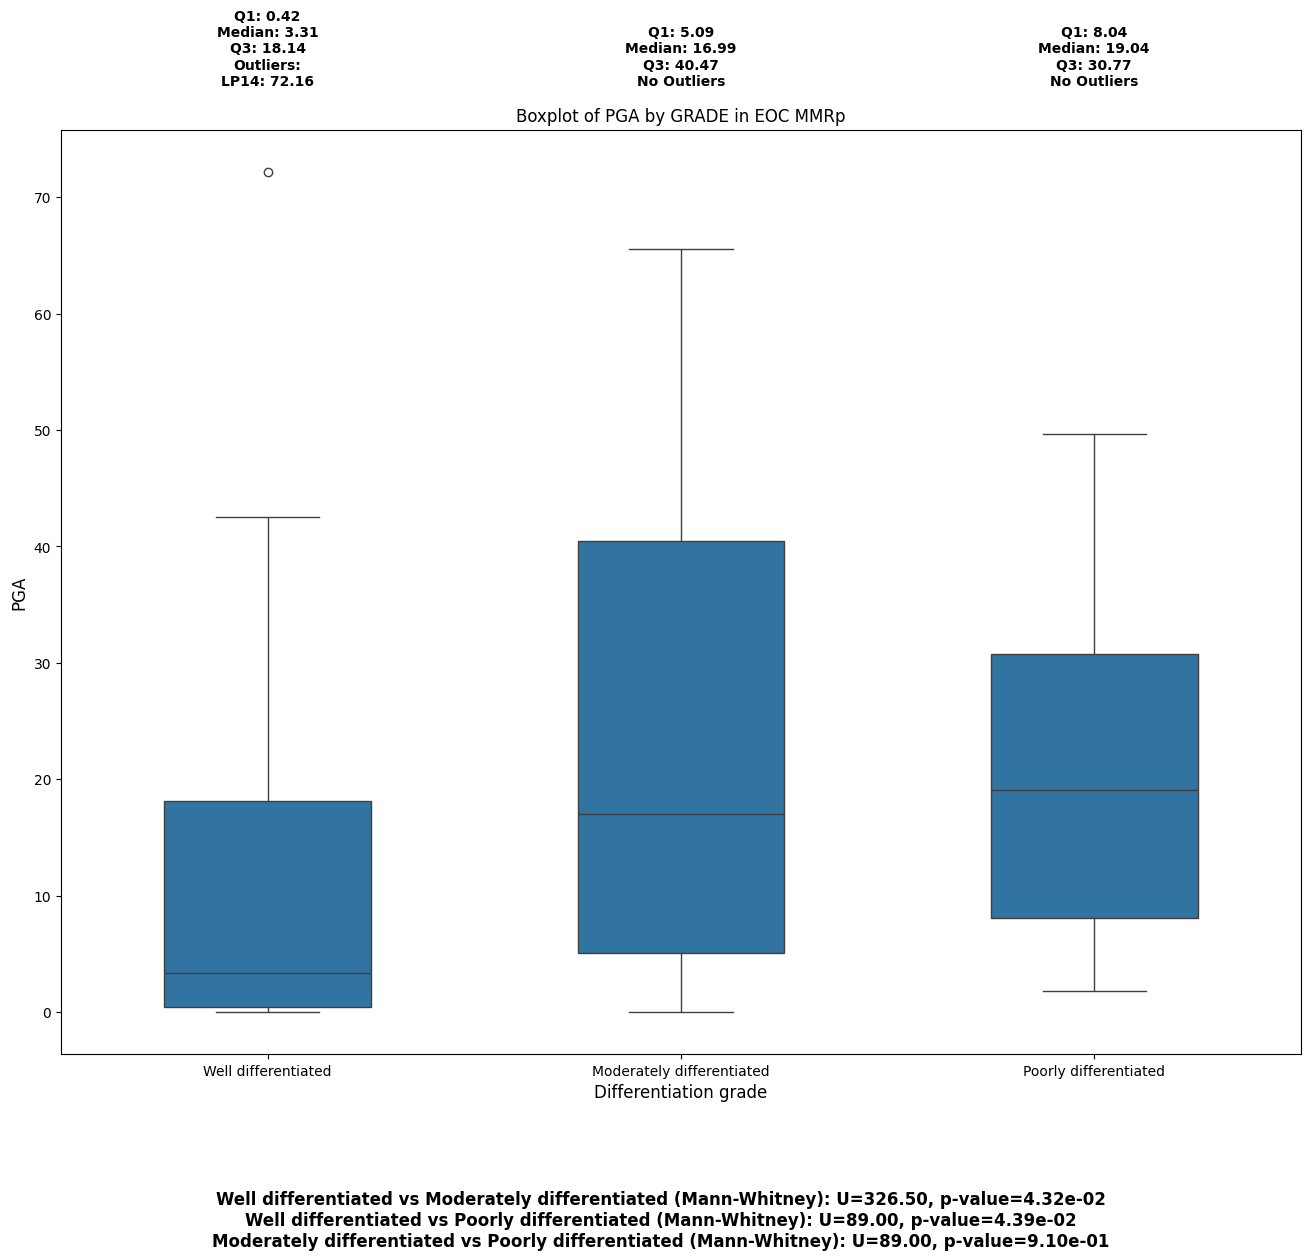

In [49]:
#### Analysis of statistics and distribution of percentage of genome altered values in GRADE categories in the EOC MMRp cohort ########

# Uncomment to import if not done previously
#import seaborn as sns  # Library for statistical data visualization
#from scipy.stats import shapiro  # Function to test normality of data (Shapiro-Wilk test)
#from scipy.stats import levene  # Function to test equality of variances (Levene's test)
#from scipy.stats import ttest_ind  # Function for independent two-sample t-test
#from scipy.stats import mannwhitneyu  # Function for Mann-Whitney U test (non-parametric test for two groups)

def analyze_and_plot(df, output_folder, output_file):
    # Filter to keep only the specified categories and make a copy to avoid SettingWithCopyWarning
    df = df[df['GRADE'].isin(['Well differentiated', 'Moderately differentiated', 'Poorly differentiated'])].copy()
    
    # Convert GRADE to an ordered categorical type to ensure the correct order in the plot
    df.loc[:, 'GRADE'] = pd.Categorical(df['GRADE'], 
                                        categories=['Well differentiated', 
                                                    'Moderately differentiated', 
                                                    'Poorly differentiated'], 
                                        ordered=True)
    
    # Dictionary to store outlier statistics
    outliers_dict = {}

    # Print the number of samples in each category
    sample_counts = df['GRADE'].value_counts().to_dict()
    print("Number of samples in each category:")
    for category, count in sample_counts.items():
        print(f"{category}: {count}")
        
    # Create figure for the boxplot
    plt.figure(figsize=(16, 12))
    sns.boxplot(x='GRADE', y='%genome_altered', data=df, width=0.5, 
                order=['Well differentiated', 'Moderately differentiated', 'Poorly differentiated'])

    # Variables to store data for each grade category
    genome_altered_grade_well = []
    genome_altered_grade_moderate = []
    genome_altered_grade_poor = []

    # Loop through each grade category to calculate statistics
    for category in ['Well differentiated', 'Moderately differentiated', 'Poorly differentiated']:
        # Filter data for the current category
        category_data = df[df['GRADE'] == category]
        TMB_data = category_data['%genome_altered'].astype(float).dropna()
        
        if not TMB_data.empty:
            # Calculate Q1, Q3, and median
            Q1 = TMB_data.quantile(0.25)
            Q3 = TMB_data.quantile(0.75)
            median = TMB_data.median()
            IQR = Q3 - Q1  # Interquartile Range
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            # Identify outliers
            outliers = category_data[(category_data['%genome_altered'] < lower_bound) | 
                                     (category_data['%genome_altered'] > upper_bound)]
            
            # Store outlier IDs and values, along with quartile information
            outliers_dict[category] = {
                'Outlier_IDs': outliers['ID_CNIO'].tolist(),
                'Outlier_Values': outliers['%genome_altered'].tolist(),
                'Q1': Q1,
                'Q3': Q3,
                'Median': median
            }
            # Assign data to the corresponding lists
            if category == 'Well differentiated':
                genome_altered_grade_well = TMB_data
            elif category == 'Moderately differentiated':
                genome_altered_grade_moderate = TMB_data
            elif category == 'Poorly differentiated':
                genome_altered_grade_poor = TMB_data

    # Perform statistical tests in the specified order
    groups = {
        'Well differentiated': genome_altered_grade_well,
        'Moderately differentiated': genome_altered_grade_moderate,
        'Poorly differentiated': genome_altered_grade_poor
    }

    test_results = {}
    categories = list(groups.keys())

    # Perform pairwise comparisons between categories
    for i in range(len(categories)):
        for j in range(i + 1, len(categories)):
            cat_a = categories[i]
            cat_b = categories[j]
            data_a = groups[cat_a]
            data_b = groups[cat_b]

            if not data_a.empty and not data_b.empty:
                # Shapiro-Wilk normality test
                shapiro_a = shapiro(data_a)
                shapiro_b = shapiro(data_b)
                
                # Levene's test for variance homogeneity
                levene_test = levene(data_a, data_b)
                
                # Select appropriate statistical test based on normality and variance homogeneity
                if shapiro_a.pvalue > 0.05 and shapiro_b.pvalue > 0.05 and levene_test.pvalue > 0.05:
                    # T-test for normally distributed data with equal variances
                    t_test = ttest_ind(data_a, data_b)
                    test_results[f"{cat_a} vs {cat_b} (T-test)"] = f"t={t_test.statistic:.2f}, p-value={t_test.pvalue:.2e}"
                else:
                    # Mann-Whitney U test for non-normally distributed data or unequal variances
                    mannwhitney_test = mannwhitneyu(data_a, data_b, alternative='two-sided')
                    test_results[f"{cat_a} vs {cat_b} (Mann-Whitney)"] = f"U={mannwhitney_test.statistic:.2f}, p-value={mannwhitney_test.pvalue:.2e}"

    # Add the test results as text below the plot
    text_results = "\n".join([f"{comparison}: {result}" for comparison, result in test_results.items()])
    plt.figtext(0.5, -0.05, text_results, horizontalalignment='center', fontsize=12, color='black', weight='bold', ha='center')

    # Add text boxes with outlier and summary statistics for each category
    for category, stats in outliers_dict.items():
        sorted_outliers = sorted(zip(stats['Outlier_IDs'], stats['Outlier_Values']), key=lambda x: x[1])
        outlier_text = 'Outliers:\n' + '\n'.join([f'{id_}: {val:.2f}' for id_, val in sorted_outliers]) if stats['Outlier_Values'] else 'No Outliers'
        
        # Include Q1, Median, Q3 in the summary stats text box
        summary_stats_text = f"Q1: {stats['Q1']:.2f}\nMedian: {stats['Median']:.2f}\nQ3: {stats['Q3']:.2f}\n{outlier_text}"
        
        # Position the text box near the respective category in the plot
        x_pos = ['Well differentiated', 'Moderately differentiated', 'Poorly differentiated'].index(category)
        plt.gca().text(
            x=x_pos, 
            y=df['%genome_altered'].max() + 0.1 * (df['%genome_altered'].max() - df['%genome_altered'].min()), 
            s=summary_stats_text,
            horizontalalignment='center', verticalalignment='bottom', 
            fontsize=10, color='black',
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.5'),
            weight='bold'
        )
    
    # Set plot title and labels
    plt.title('Boxplot of PGA by GRADE in EOC MMRp', fontsize=12)
    plt.xlabel('Differentiation grade', fontsize=12)
    plt.ylabel('PGA', fontsize=12)
    
    # Save the plot as a PDF file
    plt.savefig(f'{output_folder}/{output_file}', format='pdf', bbox_inches='tight')
    plt.show()

# Define output folder and file and call the function
output_folder = '/home/vant/TFM/Plots_TFM_final/'
output_file = 'Boxplot_EOC_MMRp_PGA_by_GRADE.pdf'  
analyze_and_plot(df_eoc_mmrp, output_folder, output_file)

Number of samples in each category:
Well differentiated: 41
Moderately differentiated: 23
Poorly differentiated: 8


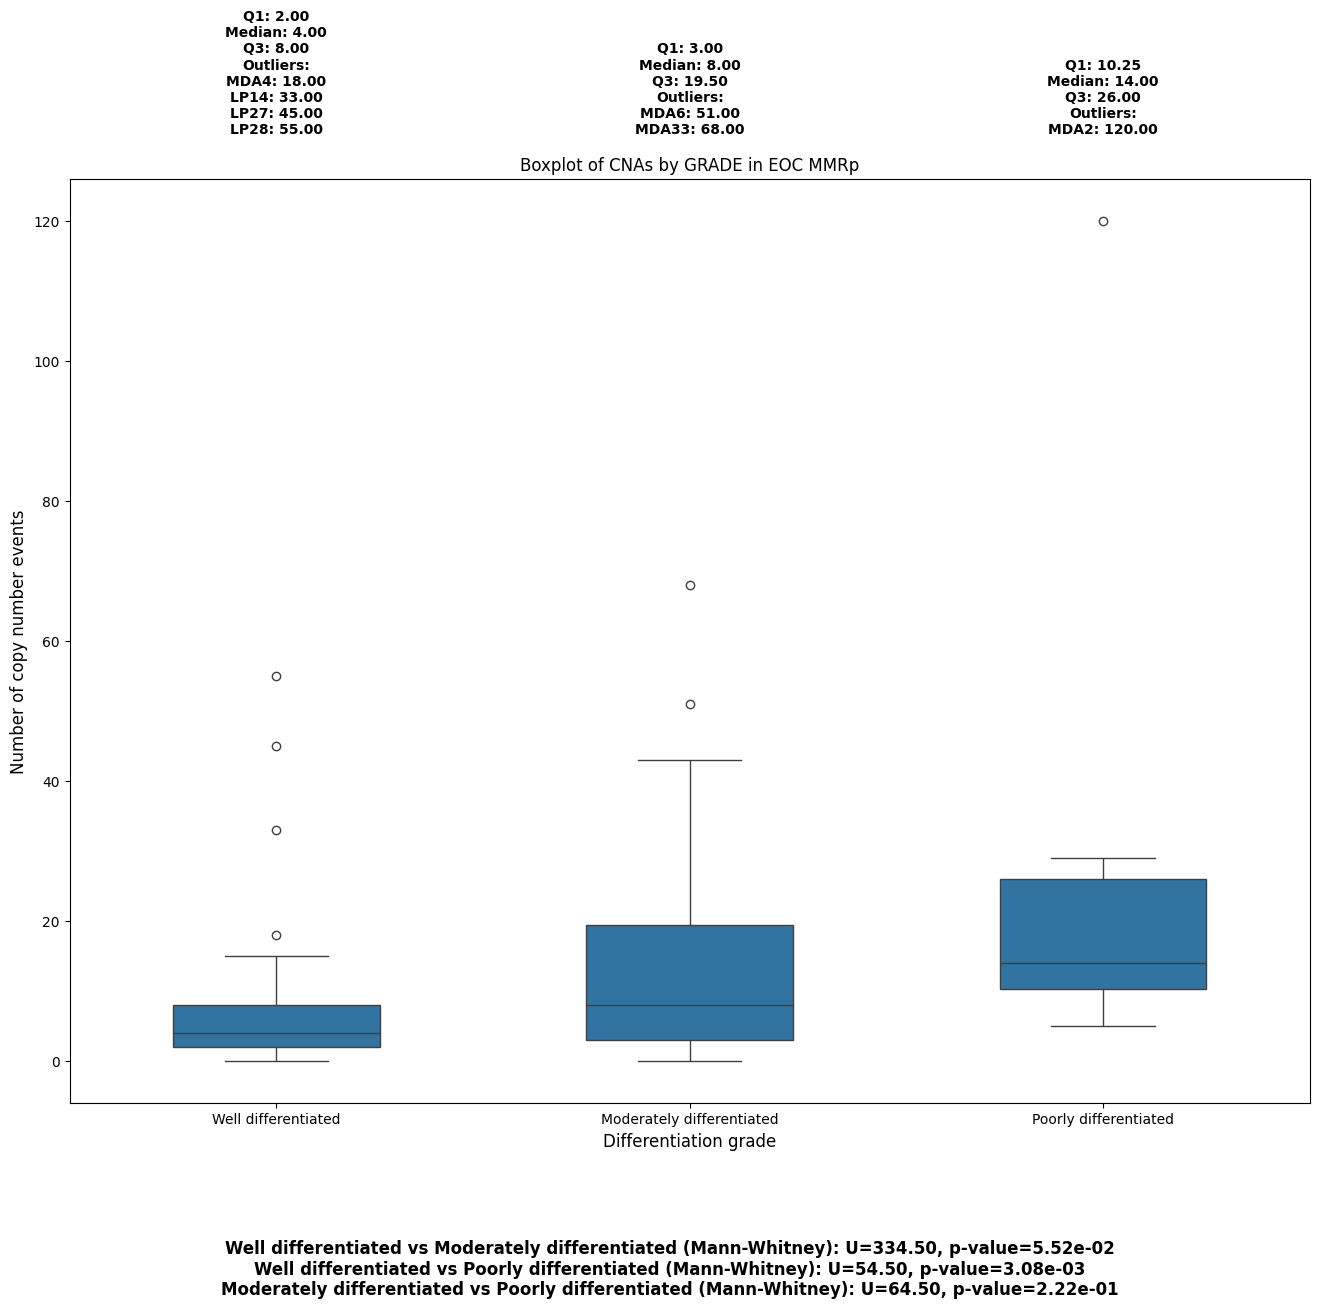

In [50]:
#### Analysis of statistics and distribution of copy number events (CNAs) in GRADE categories in the EOC MMRp cohort ########

# Uncomment to import if not done previously
#import seaborn as sns  # Library for statistical data visualization
#from scipy.stats import shapiro  # Function to test normality of data (Shapiro-Wilk test)
#from scipy.stats import levene  # Function to test equality of variances (Levene's test)
#from scipy.stats import ttest_ind  # Function for independent two-sample t-test
#from scipy.stats import mannwhitneyu  # Function for Mann-Whitney U test (non-parametric test for two groups)

def analyze_and_plot(df, output_folder, output_file):
    # Filter to keep only the specified categories and make a copy to avoid SettingWithCopyWarning
    df = df[df['GRADE'].isin(['Well differentiated', 'Moderately differentiated', 'Poorly differentiated'])].copy()
    
    # Convert GRADE to an ordered categorical type to ensure the correct order in the plot
    df.loc[:, 'GRADE'] = pd.Categorical(df['GRADE'], 
                                        categories=['Well differentiated', 
                                                    'Moderately differentiated', 
                                                    'Poorly differentiated'], 
                                        ordered=True)
    
    # Dictionary to store outlier statistics
    outliers_dict = {}

    # Print the number of samples in each category
    sample_counts = df['GRADE'].value_counts().to_dict()
    print("Number of samples in each category:")
    for category, count in sample_counts.items():
        print(f"{category}: {count}")
        
    # Create figure for the boxplot
    plt.figure(figsize=(16, 12))
    sns.boxplot(x='GRADE', y='CNV', data=df, width=0.5, 
                order=['Well differentiated', 'Moderately differentiated', 'Poorly differentiated'])

    # Variables to store data for each grade category
    CNV_grade_well = []
    CNV_grade_moderate = []
    CNV_grade_poor = []

    # Loop through each grade category to calculate statistics
    for category in ['Well differentiated', 'Moderately differentiated', 'Poorly differentiated']:
        # Filter data for the current category
        category_data = df[df['GRADE'] == category]
        CNV_data = category_data['CNV'].astype(float).dropna()
        
        if not CNV_data.empty:
            # Calculate Q1, Q3, and median
            Q1 = CNV_data.quantile(0.25)
            Q3 = CNV_data.quantile(0.75)
            median = CNV_data.median()
            IQR = Q3 - Q1  # Interquartile Range
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            # Identify outliers
            outliers = category_data[(category_data['CNV'] < lower_bound) | 
                                     (category_data['CNV'] > upper_bound)]
            
            # Store outlier IDs and values, along with quartile information
            outliers_dict[category] = {
                'Outlier_IDs': outliers['ID_CNIO'].tolist(),
                'Outlier_Values': outliers['CNV'].tolist(),
                'Q1': Q1,
                'Q3': Q3,
                'Median': median
            }
            # Assign data to the corresponding lists
            if category == 'Well differentiated':
                CNV_grade_well = CNV_data
            elif category == 'Moderately differentiated':
                CNV_grade_moderate = CNV_data
            elif category == 'Poorly differentiated':
                CNV_grade_poor = CNV_data

    # Perform statistical tests in the specified order
    groups = {
        'Well differentiated': CNV_grade_well,
        'Moderately differentiated': CNV_grade_moderate,
        'Poorly differentiated': CNV_grade_poor
    }

    test_results = {}
    categories = list(groups.keys())

    # Perform pairwise comparisons between categories
    for i in range(len(categories)):
        for j in range(i + 1, len(categories)):
            cat_a = categories[i]
            cat_b = categories[j]
            data_a = groups[cat_a]
            data_b = groups[cat_b]

            if not data_a.empty and not data_b.empty:
                # Shapiro-Wilk normality test
                shapiro_a = shapiro(data_a)
                shapiro_b = shapiro(data_b)
                
                # Levene's test for variance homogeneity
                levene_test = levene(data_a, data_b)
                
                # Select appropriate statistical test based on normality and variance homogeneity
                if shapiro_a.pvalue > 0.05 and shapiro_b.pvalue > 0.05 and levene_test.pvalue > 0.05:
                    # T-test for normally distributed data with equal variances
                    t_test = ttest_ind(data_a, data_b)
                    test_results[f"{cat_a} vs {cat_b} (T-test)"] = f"t={t_test.statistic:.2f}, p-value={t_test.pvalue:.2e}"
                else:
                    # Mann-Whitney U test for non-normally distributed data or unequal variances
                    mannwhitney_test = mannwhitneyu(data_a, data_b, alternative='two-sided')
                    test_results[f"{cat_a} vs {cat_b} (Mann-Whitney)"] = f"U={mannwhitney_test.statistic:.2f}, p-value={mannwhitney_test.pvalue:.2e}"

    # Add the test results as text below the plot
    text_results = "\n".join([f"{comparison}: {result}" for comparison, result in test_results.items()])
    plt.figtext(0.5, -0.05, text_results, horizontalalignment='center', fontsize=12, color='black', weight='bold', ha='center')

    # Add text boxes with outlier and summary statistics for each category
    for category, stats in outliers_dict.items():
        sorted_outliers = sorted(zip(stats['Outlier_IDs'], stats['Outlier_Values']), key=lambda x: x[1])
        outlier_text = 'Outliers:\n' + '\n'.join([f'{id_}: {val:.2f}' for id_, val in sorted_outliers]) if stats['Outlier_Values'] else 'No Outliers'
        
        # Include Q1, Median, Q3 in the summary stats text box
        summary_stats_text = f"Q1: {stats['Q1']:.2f}\nMedian: {stats['Median']:.2f}\nQ3: {stats['Q3']:.2f}\n{outlier_text}"
        
        # Position the text box near the respective category in the plot
        x_pos = ['Well differentiated', 'Moderately differentiated', 'Poorly differentiated'].index(category)
        plt.gca().text(
            x=x_pos, 
            y=df['CNV'].max() + 0.1 * (df['CNV'].max() - df['CNV'].min()), 
            s=summary_stats_text,
            horizontalalignment='center', verticalalignment='bottom', 
            fontsize=10, color='black',
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.5'),
            weight='bold'
        )
    
    # Set plot title and labels
    plt.title('Boxplot of CNAs by GRADE in EOC MMRp', fontsize=12)
    plt.xlabel('Differentiation grade', fontsize=12)
    plt.ylabel('Number of copy number events', fontsize=12)
    
    # Save the plot as a PDF file
    plt.savefig(f'{output_folder}/{output_file}', format='pdf', bbox_inches='tight')
    plt.show()

# Define output folder and file and call the function
output_folder = '/home/vant/TFM/Plots_TFM_final/'
output_file = 'Boxplot_EOC_MMRp_CNAs_by_GRADE.pdf'  
analyze_and_plot(df_eoc_mmrp, output_folder, output_file)

Number of samples in each category:
No: 102
Yes: 19
Shapiro-Wilk test for No: W=0.3136, p-value=0.0000
Shapiro-Wilk test for Yes: W=0.3449, p-value=0.0000
Levene's test: W=1.8491, p-value=0.1765


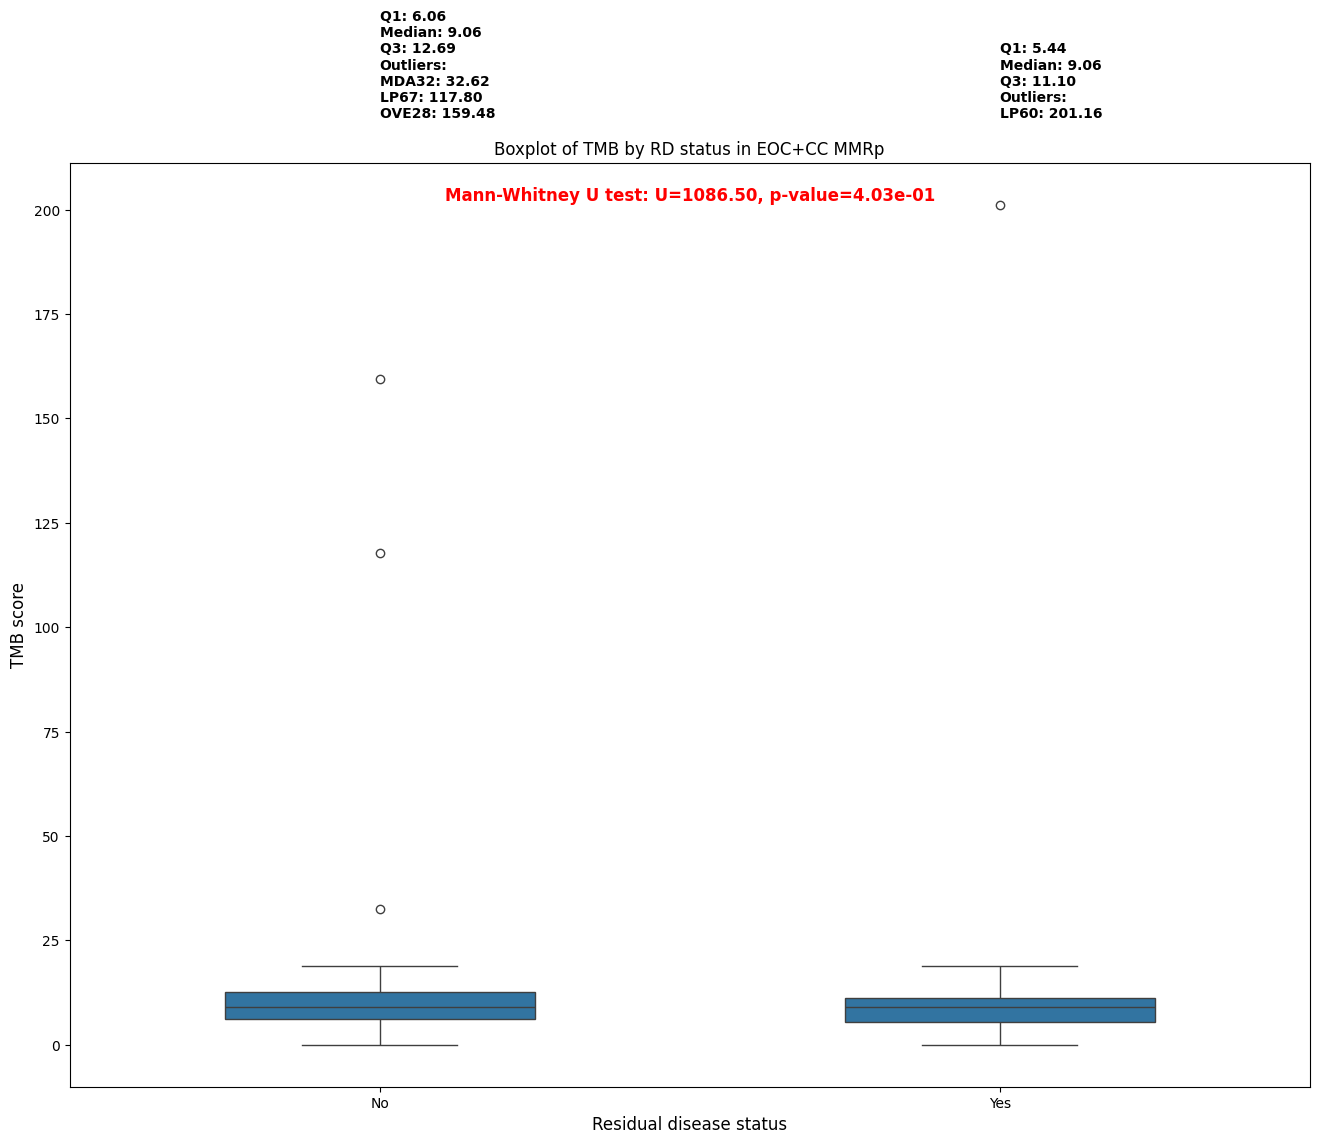

In [51]:
#### Analysis of statistics and distribution of TMB in RESIDUALa categories in the entire MMRp cohort ########

# Uncomment to import if not done previously
#import seaborn as sns  # Library for statistical data visualization
#from scipy.stats import shapiro  # Function to test normality of data (Shapiro-Wilk test)
#from scipy.stats import levene  # Function to test equality of variances (Levene's test)
#from scipy.stats import ttest_ind  # Function for independent two-sample t-test
#from scipy.stats import mannwhitneyu  # Function for Mann-Whitney U test (non-parametric test for two groups)

def analyze_and_plot(df, output_folder, output_file):
    # Filter only "Localized" and "Advanced" categories in FIGOL
    df = df[df['RESIDUALa'].isin(['Yes', 'No'])]

    # Dictionary to store outlier statistics
    outliers_dict = {}

    # Dictionary to store the number of samples in each category
    sample_counts = df['RESIDUALa'].value_counts().to_dict()
    print(f"Number of samples in each category:")
    for category, count in sample_counts.items():
        print(f"{category}: {count}")

    # Create a figure for the boxplot
    plt.figure(figsize=(16, 12))  # Increased size for better visibility
    sns.boxplot(x='RESIDUALa', y='TMB', data=df, width=0.5)  # Adjust the width of the boxes
    
    # Variables to store data for 'No' and 'Yes'
    tmb_residual_no = []
    tmb_residual_yes = []

    for category in df['RESIDUALa'].unique():
        # Filter data for the current category
        category_data = df[df['RESIDUALa'] == category]

        # Calculate Q1, Q3, and median
        Q1 = category_data['TMB'].quantile(0.25)
        Q3 = category_data['TMB'].quantile(0.75)
        median = category_data['TMB'].median()
        IQR = Q3 - Q1
        
        # Define limits for outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Identify outliers
        outliers = category_data[(category_data['TMB'] < lower_bound) | 
                                 (category_data['TMB'] > upper_bound)]
        
        # Store outlier IDs and values
        outliers_dict[category] = {
            'Outlier_IDs': outliers['ID_CNIO'].tolist(),
            'Outlier_Values': outliers['TMB'].tolist(),
            'Q1': Q1,
            'Q3': Q3,
            'Median': median
        }
        
        # Add data to the corresponding lists
        if category == 'No':
            tmb_residual_no = category_data['TMB'].astype(float).dropna()
        elif category == 'Yes':
            tmb_residual_yes = category_data['TMB'].astype(float).dropna()

    # Perform statistical tests
    if not tmb_residual_no.empty and not tmb_residual_yes.empty:
        # Shapiro-Wilk normality test
        shapiro_no = shapiro(tmb_residual_no)
        shapiro_yes = shapiro(tmb_residual_yes)
        print(f"Shapiro-Wilk test for No: W={shapiro_no.statistic:.4f}, p-value={shapiro_no.pvalue:.4f}")
        print(f"Shapiro-Wilk test for Yes: W={shapiro_yes.statistic:.4f}, p-value={shapiro_yes.pvalue:.4f}")
        
        # Levene's test for homogeneity of variances
        levene_test = levene(tmb_residual_no, tmb_residual_yes)
        print(f"Levene's test: W={levene_test.statistic:.4f}, p-value={levene_test.pvalue:.4f}")
        
        # Select the appropriate test
        if shapiro_no.pvalue > 0.05 and shapiro_yes.pvalue > 0.05 and levene_test.pvalue > 0.05:
            # T-test
            t_test = ttest_ind(tmb_residual_no, tmb_residual_yes)
            test_result = f"T-test: t={t_test.statistic:.2f}, p-value={t_test.pvalue:.2e}"  # .2e for scientific notation
        else:
            # Mann-Whitney U test
            mannwhitney_test = mannwhitneyu(tmb_residual_no, tmb_residual_yes, alternative='two-sided')
            test_result = f"Mann-Whitney U test: U={mannwhitney_test.statistic:.2f}, p-value={mannwhitney_test.pvalue:.2e}"
        
        # Add the test result to the plot
        plt.gca().text(
            x=0.5, y=df['TMB'].max(), 
            s=test_result,
            horizontalalignment='center', verticalalignment='bottom', 
            fontsize=12, color='red', 
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', boxstyle='round,pad=0.5'),
            weight='bold'
        )

    # Add text with outliers, Q1, Q3, and Median
    for category, stats in outliers_dict.items():
        sorted_outliers = sorted(zip(stats['Outlier_IDs'], stats['Outlier_Values']), key=lambda x: x[1])
        outlier_text = 'Outliers:\n' + '\n'.join([f'{id_}: {val:.2f}' for id_, val in sorted_outliers]) if stats['Outlier_Values'] else 'No Outliers'
        
        # Always include Q1, Median, and Q3 in the text box
        summary_stats_text = f"Q1: {stats['Q1']:.2f}\nMedian: {stats['Median']:.2f}\nQ3: {stats['Q3']:.2f}\n{outlier_text}"
        
        x_pos = df['RESIDUALa'].unique().tolist().index(category)
        plt.gca().text(
            x=x_pos, 
            y=df['TMB'].max() + 0.1 * (df['TMB'].max() - df['TMB'].min()), 
            s=summary_stats_text,
            horizontalalignment='left', verticalalignment='bottom', 
            fontsize=10, color='black',
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.5'),
            weight='bold'
        )
    
    # Set title and labels for the plot
    plt.title('Boxplot of TMB by RD status in EOC+CC MMRp', fontsize=12)
    plt.xlabel('Residual disease status', fontsize=12)
    plt.ylabel('TMB score', fontsize=12)
    
    # Save the plot as a PDF file
    plt.savefig(f'{output_folder}/{output_file}', format='pdf', bbox_inches='tight')
    
    # Show the plot
    plt.show()

# Define output folder and file and call the function
output_folder = '/home/vant/TFM/Plots_TFM_final/'
output_file = 'Boxplot_MMRp_TMB_by_RD.pdf'  
analyze_and_plot(df_all_mmrp, output_folder, output_file)

Number of samples in each category:
No: 61
Yes: 5
Shapiro-Wilk test for No: W=0.2863, p-value=0.0000
Shapiro-Wilk test for Yes: W=0.5917, p-value=0.0005
Levene's test: W=7.0022, p-value=0.0102


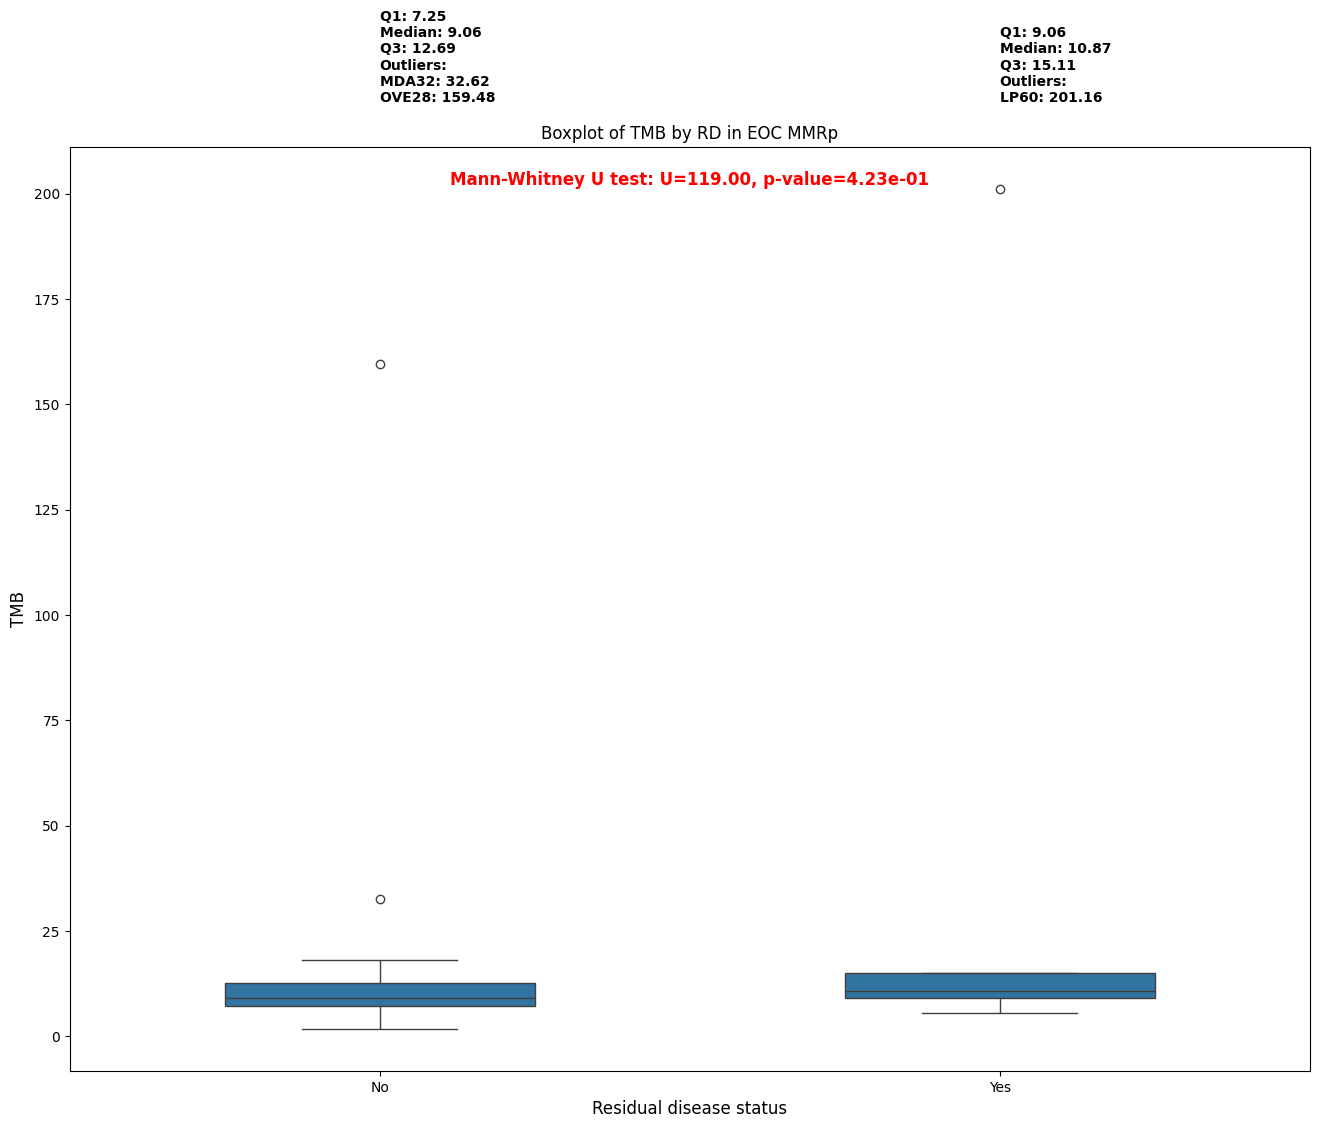

In [52]:
#### Analysis of statistics and distribution of TMB in RESIDUALa categories in the EOC MMRp cohort ########

# Uncomment to import if not done previously
#import seaborn as sns  # Library for statistical data visualization
#from scipy.stats import shapiro  # Function to test normality of data (Shapiro-Wilk test)
#from scipy.stats import levene  # Function to test equality of variances (Levene's test)
#from scipy.stats import ttest_ind  # Function for independent two-sample t-test
#from scipy.stats import mannwhitneyu  # Function for Mann-Whitney U test (non-parametric test for two groups)

def analyze_and_plot(df, output_folder, output_file):
    # Filter only "Localized" and "Advanced" categories in FIGOL
    df = df[df['RESIDUALa'].isin(['Yes', 'No'])]

    # Dictionary to store outlier statistics
    outliers_dict = {}

    # Dictionary to store the number of samples in each category
    sample_counts = df['RESIDUALa'].value_counts().to_dict()
    print(f"Number of samples in each category:")
    for category, count in sample_counts.items():
        print(f"{category}: {count}")

    # Create a figure for the boxplot
    plt.figure(figsize=(16, 12))  # Increased size for better visibility
    sns.boxplot(x='RESIDUALa', y='TMB', data=df, width=0.5)  # Adjust the width of the boxes
    
    # Variables to store data for 'No' and 'Yes'
    tmb_residual_no = []
    tmb_residual_yes = []

    for category in df['RESIDUALa'].unique():
        # Filter data for the current category
        category_data = df[df['RESIDUALa'] == category]

        # Calculate Q1, Q3, and median
        Q1 = category_data['TMB'].quantile(0.25)
        Q3 = category_data['TMB'].quantile(0.75)
        median = category_data['TMB'].median()
        IQR = Q3 - Q1
        
        # Define limits for outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Identify outliers
        outliers = category_data[(category_data['TMB'] < lower_bound) | 
                                 (category_data['TMB'] > upper_bound)]
        
        # Store outlier IDs and values
        outliers_dict[category] = {
            'Outlier_IDs': outliers['ID_CNIO'].tolist(),
            'Outlier_Values': outliers['TMB'].tolist(),
            'Q1': Q1,
            'Q3': Q3,
            'Median': median
        }
        
        # Add data to the corresponding lists
        if category == 'No':
            tmb_residual_no = category_data['TMB'].astype(float).dropna()
        elif category == 'Yes':
            tmb_residual_yes = category_data['TMB'].astype(float).dropna()

    # Perform statistical tests
    if not tmb_residual_no.empty and not tmb_residual_yes.empty:
        # Shapiro-Wilk normality test
        shapiro_no = shapiro(tmb_residual_no)
        shapiro_yes = shapiro(tmb_residual_yes)
        print(f"Shapiro-Wilk test for No: W={shapiro_no.statistic:.4f}, p-value={shapiro_no.pvalue:.4f}")
        print(f"Shapiro-Wilk test for Yes: W={shapiro_yes.statistic:.4f}, p-value={shapiro_yes.pvalue:.4f}")
        
        # Levene's test for homogeneity of variances
        levene_test = levene(tmb_residual_no, tmb_residual_yes)
        print(f"Levene's test: W={levene_test.statistic:.4f}, p-value={levene_test.pvalue:.4f}")
        
        # Select the appropriate test
        if shapiro_no.pvalue > 0.05 and shapiro_yes.pvalue > 0.05 and levene_test.pvalue > 0.05:
            # T-test
            t_test = ttest_ind(tmb_residual_no, tmb_residual_yes)
            test_result = f"T-test: t={t_test.statistic:.2f}, p-value={t_test.pvalue:.2e}"  # .2e for scientific notation
        else:
            # Mann-Whitney U test
            mannwhitney_test = mannwhitneyu(tmb_residual_no, tmb_residual_yes, alternative='two-sided')
            test_result = f"Mann-Whitney U test: U={mannwhitney_test.statistic:.2f}, p-value={mannwhitney_test.pvalue:.2e}"
        
        # Add the test result to the plot
        plt.gca().text(
            x=0.5, y=df['TMB'].max(), 
            s=test_result,
            horizontalalignment='center', verticalalignment='bottom', 
            fontsize=12, color='red', 
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', boxstyle='round,pad=0.5'),
            weight='bold'
        )

    # Add text with outliers, Q1, Q3, and Median
    for category, stats in outliers_dict.items():
        sorted_outliers = sorted(zip(stats['Outlier_IDs'], stats['Outlier_Values']), key=lambda x: x[1])
        outlier_text = 'Outliers:\n' + '\n'.join([f'{id_}: {val:.2f}' for id_, val in sorted_outliers]) if stats['Outlier_Values'] else 'No Outliers'
        
        # Always include Q1, Median, and Q3 in the text box
        summary_stats_text = f"Q1: {stats['Q1']:.2f}\nMedian: {stats['Median']:.2f}\nQ3: {stats['Q3']:.2f}\n{outlier_text}"
        
        x_pos = df['RESIDUALa'].unique().tolist().index(category)
        plt.gca().text(
            x=x_pos, 
            y=df['TMB'].max() + 0.1 * (df['TMB'].max() - df['TMB'].min()), 
            s=summary_stats_text,
            horizontalalignment='left', verticalalignment='bottom', 
            fontsize=10, color='black',
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.5'),
            weight='bold'
        )
    
    # Set title and labels for the plot
    plt.title('Boxplot of TMB by RD in EOC MMRp', fontsize=12)
    plt.xlabel('Residual disease status', fontsize=12)
    plt.ylabel('TMB', fontsize=12)
    
    # Save the plot as a PDF file
    plt.savefig(f'{output_folder}/{output_file}', format='pdf', bbox_inches='tight')
    
    # Show the plot
    plt.show()

# Define output folder and file and call the function
output_folder = '/home/vant/TFM/Plots_TFM_final/'
output_file = 'Boxplot_EOC_MMRp_TMB_by_RD.pdf'  
analyze_and_plot(df_eoc_mmrp, output_folder, output_file)

Number of samples in each category:
No: 41
Yes: 14
Shapiro-Wilk test for No: W=0.3516, p-value=0.0000
Shapiro-Wilk test for Yes: W=0.9194, p-value=0.2159
Levene's test: W=0.1653, p-value=0.6859


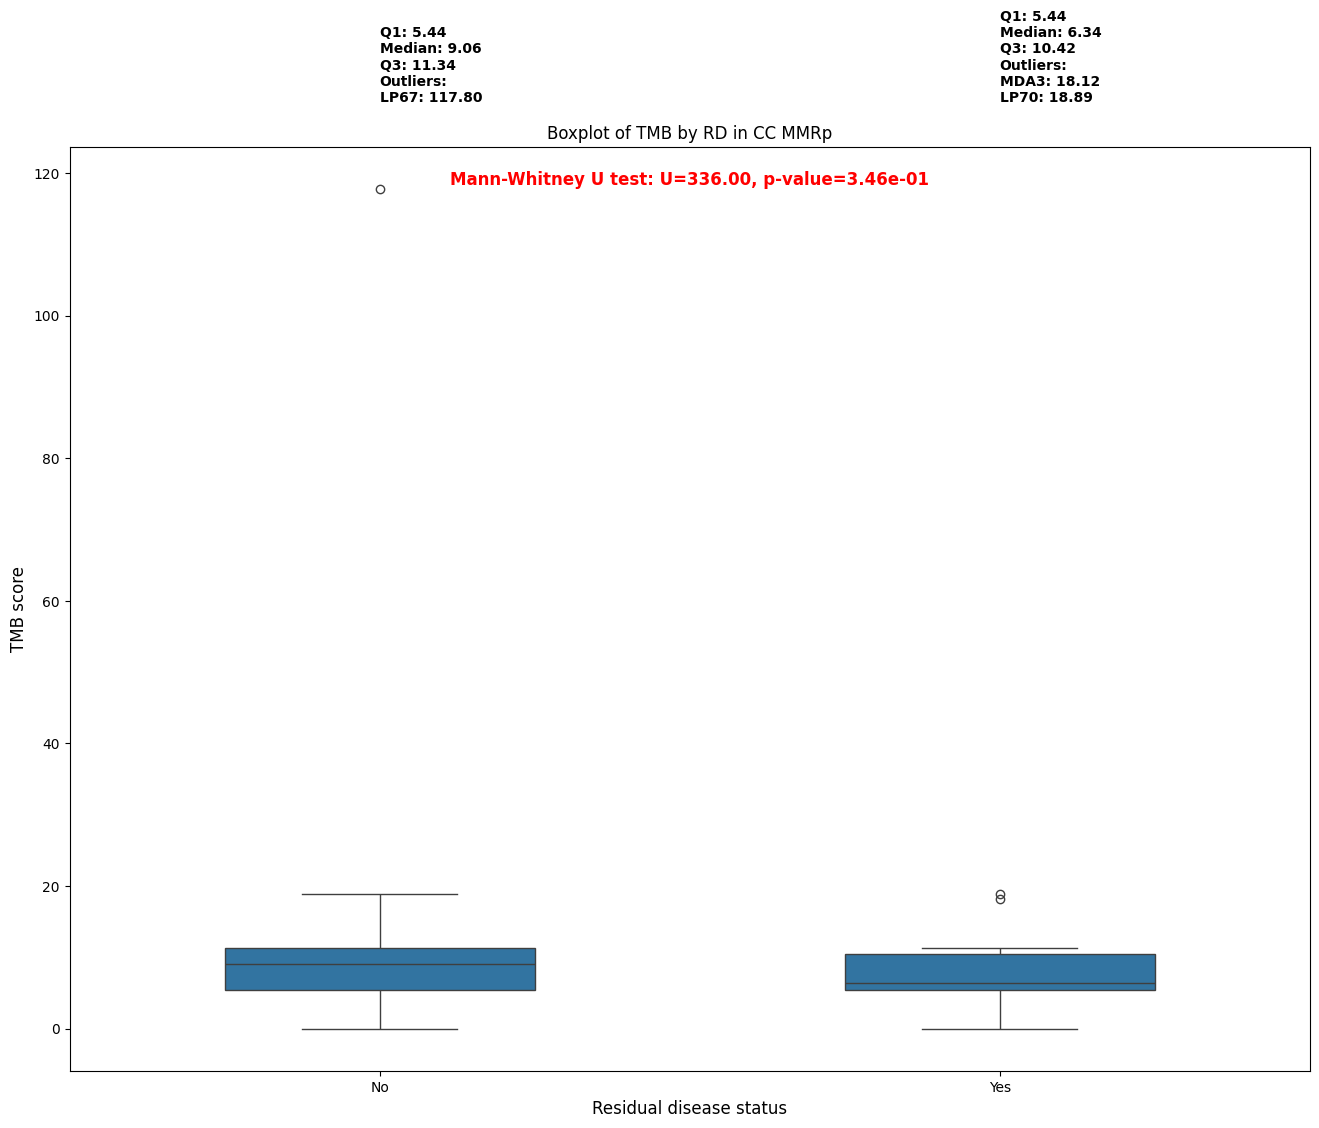

In [53]:
#### Analysis of statistics and distribution of TMB in RESIDUALa categories in the CCOC MMRp cohort ########

# Uncomment to import if not done previously
#import seaborn as sns  # Library for statistical data visualization
#from scipy.stats import shapiro  # Function to test normality of data (Shapiro-Wilk test)
#from scipy.stats import levene  # Function to test equality of variances (Levene's test)
#from scipy.stats import ttest_ind  # Function for independent two-sample t-test
#from scipy.stats import mannwhitneyu  # Function for Mann-Whitney U test (non-parametric test for two groups)

def analyze_and_plot(df, output_folder, output_file):
    # Filter only "Localized" and "Advanced" categories in FIGOL
    df = df[df['RESIDUALa'].isin(['Yes', 'No'])]

    # Dictionary to store outlier statistics
    outliers_dict = {}

    # Dictionary to store the number of samples in each category
    sample_counts = df['RESIDUALa'].value_counts().to_dict()
    print(f"Number of samples in each category:")
    for category, count in sample_counts.items():
        print(f"{category}: {count}")

    # Create a figure for the boxplot
    plt.figure(figsize=(16, 12))  # Increased size for better visibility
    sns.boxplot(x='RESIDUALa', y='TMB', data=df, width=0.5)  # Adjust the width of the boxes
    
    # Variables to store data for 'No' and 'Yes'
    tmb_residual_no = []
    tmb_residual_yes = []

    for category in df['RESIDUALa'].unique():
        # Filter data for the current category
        category_data = df[df['RESIDUALa'] == category]

        # Calculate Q1, Q3, and median
        Q1 = category_data['TMB'].quantile(0.25)
        Q3 = category_data['TMB'].quantile(0.75)
        median = category_data['TMB'].median()
        IQR = Q3 - Q1
        
        # Define limits for outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Identify outliers
        outliers = category_data[(category_data['TMB'] < lower_bound) | 
                                 (category_data['TMB'] > upper_bound)]
        
        # Store outlier IDs and values
        outliers_dict[category] = {
            'Outlier_IDs': outliers['ID_CNIO'].tolist(),
            'Outlier_Values': outliers['TMB'].tolist(),
            'Q1': Q1,
            'Q3': Q3,
            'Median': median
        }
        
        # Add data to the corresponding lists
        if category == 'No':
            tmb_residual_no = category_data['TMB'].astype(float).dropna()
        elif category == 'Yes':
            tmb_residual_yes = category_data['TMB'].astype(float).dropna()

    # Perform statistical tests
    if not tmb_residual_no.empty and not tmb_residual_yes.empty:
        # Shapiro-Wilk normality test
        shapiro_no = shapiro(tmb_residual_no)
        shapiro_yes = shapiro(tmb_residual_yes)
        print(f"Shapiro-Wilk test for No: W={shapiro_no.statistic:.4f}, p-value={shapiro_no.pvalue:.4f}")
        print(f"Shapiro-Wilk test for Yes: W={shapiro_yes.statistic:.4f}, p-value={shapiro_yes.pvalue:.4f}")
        
        # Levene's test for homogeneity of variances
        levene_test = levene(tmb_residual_no, tmb_residual_yes)
        print(f"Levene's test: W={levene_test.statistic:.4f}, p-value={levene_test.pvalue:.4f}")
        
        # Select the appropriate test
        if shapiro_no.pvalue > 0.05 and shapiro_yes.pvalue > 0.05 and levene_test.pvalue > 0.05:
            # T-test
            t_test = ttest_ind(tmb_residual_no, tmb_residual_yes)
            test_result = f"T-test: t={t_test.statistic:.2f}, p-value={t_test.pvalue:.2e}"  # .2e for scientific notation
        else:
            # Mann-Whitney U test
            mannwhitney_test = mannwhitneyu(tmb_residual_no, tmb_residual_yes, alternative='two-sided')
            test_result = f"Mann-Whitney U test: U={mannwhitney_test.statistic:.2f}, p-value={mannwhitney_test.pvalue:.2e}"
        
        # Add the test result to the plot
        plt.gca().text(
            x=0.5, y=df['TMB'].max(), 
            s=test_result,
            horizontalalignment='center', verticalalignment='bottom', 
            fontsize=12, color='red', 
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', boxstyle='round,pad=0.5'),
            weight='bold'
        )

    # Add text with outliers, Q1, Q3, and Median
    for category, stats in outliers_dict.items():
        sorted_outliers = sorted(zip(stats['Outlier_IDs'], stats['Outlier_Values']), key=lambda x: x[1])
        outlier_text = 'Outliers:\n' + '\n'.join([f'{id_}: {val:.2f}' for id_, val in sorted_outliers]) if stats['Outlier_Values'] else 'No Outliers'
        
        # Always include Q1, Median, and Q3 in the text box
        summary_stats_text = f"Q1: {stats['Q1']:.2f}\nMedian: {stats['Median']:.2f}\nQ3: {stats['Q3']:.2f}\n{outlier_text}"
        
        x_pos = df['RESIDUALa'].unique().tolist().index(category)
        plt.gca().text(
            x=x_pos, 
            y=df['TMB'].max() + 0.1 * (df['TMB'].max() - df['TMB'].min()), 
            s=summary_stats_text,
            horizontalalignment='left', verticalalignment='bottom', 
            fontsize=10, color='black',
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.5'),
            weight='bold'
        )
    
    # Set title and labels for the plot
    plt.title('Boxplot of TMB by RD in CC MMRp', fontsize=12)
    plt.xlabel('Residual disease status', fontsize=12)
    plt.ylabel('TMB score', fontsize=12)
    
    # Save the plot as a PDF file
    plt.savefig(f'{output_folder}/{output_file}', format='pdf', bbox_inches='tight')
    
    # Show the plot
    plt.show()

# Define output folder and file and call the function
output_folder = '/home/vant/TFM/Plots_TFM_final/'
output_file = 'Boxplot_CC_MMRp_TMB_by_RD.pdf'  
analyze_and_plot(df_cc_mmrp, output_folder, output_file)

Number of samples in each category:
No: 102
Yes: 19
Shapiro-Wilk test for No: W=0.9149, p-value=0.0000
Shapiro-Wilk test for Yes: W=0.7919, p-value=0.0009
Levene's test: W=0.2766, p-value=0.5999


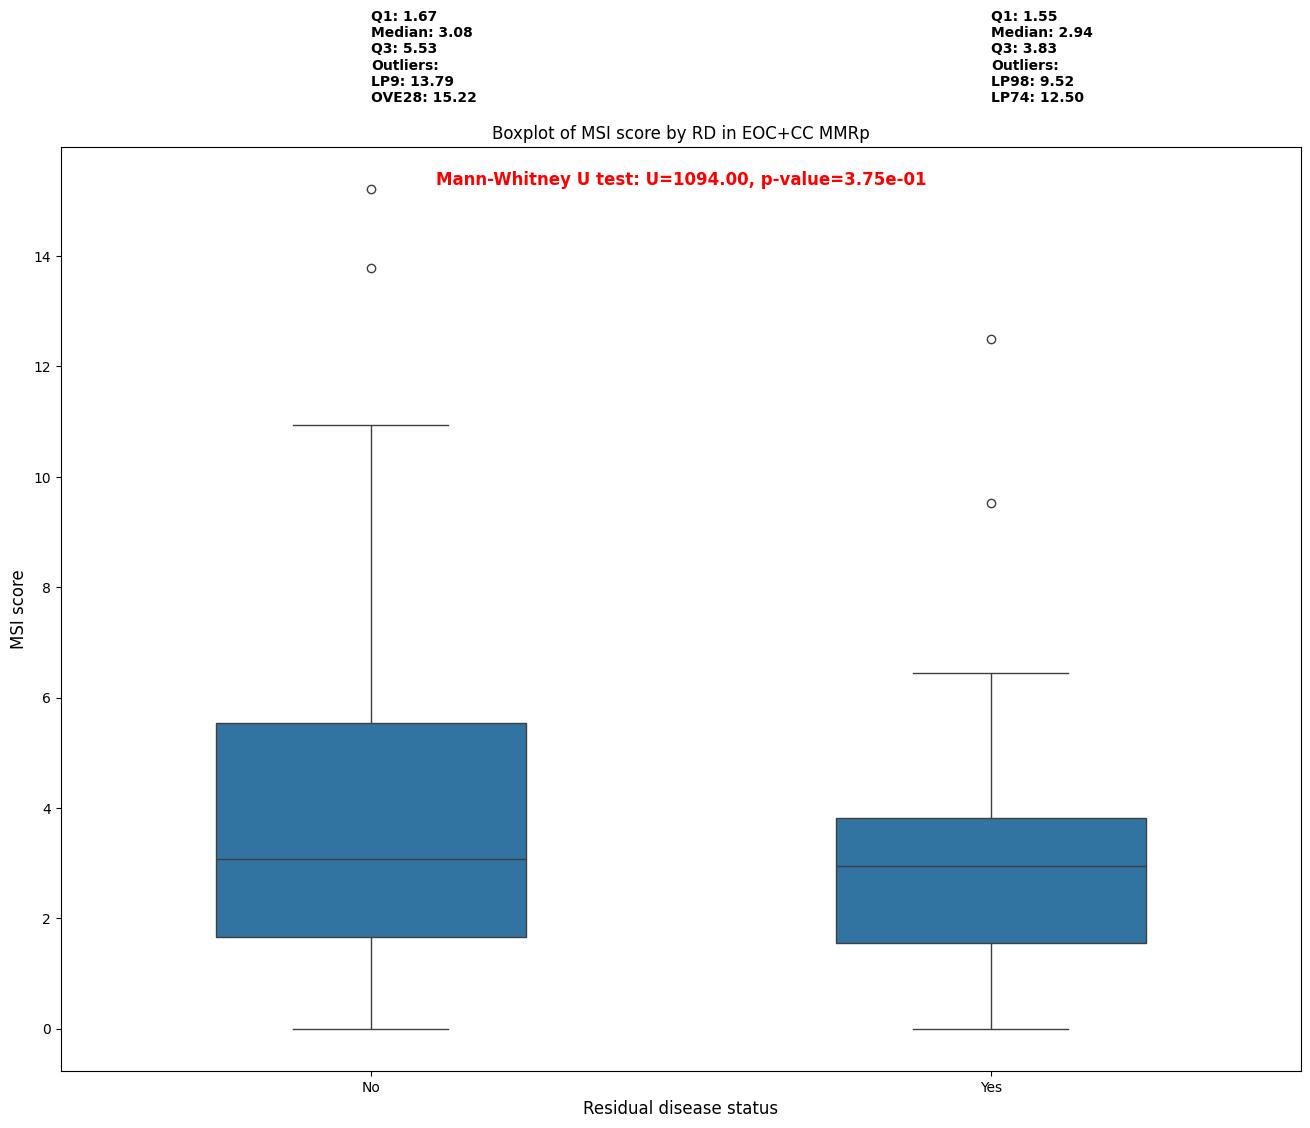

In [54]:
#### Analysis of statistics and distribution of MSI score values in RESIDUALa categories in the entire MMRp cohort ########

# Uncomment to import if not done previously
#import seaborn as sns  # Library for statistical data visualization
#from scipy.stats import shapiro  # Function to test normality of data (Shapiro-Wilk test)
#from scipy.stats import levene  # Function to test equality of variances (Levene's test)
#from scipy.stats import ttest_ind  # Function for independent two-sample t-test
#from scipy.stats import mannwhitneyu  # Function for Mann-Whitney U test (non-parametric test for two groups)

def analyze_and_plot(df, output_folder, output_file):
    # Filter only "Localized" and "Advanced" categories in FIGOL
    df = df[df['RESIDUALa'].isin(['Yes', 'No'])]

    # Dictionary to store outlier statistics
    outliers_dict = {}

    # Dictionary to store the number of samples in each category
    sample_counts = df['RESIDUALa'].value_counts().to_dict()
    print(f"Number of samples in each category:")
    for category, count in sample_counts.items():
        print(f"{category}: {count}")

    # Create a figure for the boxplot
    plt.figure(figsize=(16, 12))  # Increased size for better visibility
    sns.boxplot(x='RESIDUALa', y='MSI_sensor2', data=df, width=0.5)  # Adjust the width of the boxes
    
    # Variables to store data for 'No' and 'Yes'
    msi_sensor2_residual_no = []
    msi_sensor2_residual_yes = []

    for category in df['RESIDUALa'].unique():
        # Filter data for the current category
        category_data = df[df['RESIDUALa'] == category]

        # Calculate Q1, Q3, and median
        Q1 = category_data['MSI_sensor2'].quantile(0.25)
        Q3 = category_data['MSI_sensor2'].quantile(0.75)
        median = category_data['MSI_sensor2'].median()
        IQR = Q3 - Q1
        
        # Define limits for outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Identify outliers
        outliers = category_data[(category_data['MSI_sensor2'] < lower_bound) | 
                                 (category_data['MSI_sensor2'] > upper_bound)]
        
        # Store outlier IDs and values
        outliers_dict[category] = {
            'Outlier_IDs': outliers['ID_CNIO'].tolist(),
            'Outlier_Values': outliers['MSI_sensor2'].tolist(),
            'Q1': Q1,
            'Q3': Q3,
            'Median': median
        }
        
        # Add data to the corresponding lists
        if category == 'No':
            msi_sensor2_residual_no = category_data['MSI_sensor2'].astype(float).dropna()
        elif category == 'Yes':
            msi_sensor2_residual_yes = category_data['MSI_sensor2'].astype(float).dropna()

    # Perform statistical tests
    if not msi_sensor2_residual_no.empty and not msi_sensor2_residual_yes.empty:
        # Shapiro-Wilk normality test
        shapiro_no = shapiro(msi_sensor2_residual_no)
        shapiro_yes = shapiro(msi_sensor2_residual_yes)
        print(f"Shapiro-Wilk test for No: W={shapiro_no.statistic:.4f}, p-value={shapiro_no.pvalue:.4f}")
        print(f"Shapiro-Wilk test for Yes: W={shapiro_yes.statistic:.4f}, p-value={shapiro_yes.pvalue:.4f}")
        
        # Levene's test for homogeneity of variances
        levene_test = levene(msi_sensor2_residual_no, msi_sensor2_residual_yes)
        print(f"Levene's test: W={levene_test.statistic:.4f}, p-value={levene_test.pvalue:.4f}")
        
        # Select the appropriate test
        if shapiro_no.pvalue > 0.05 and shapiro_yes.pvalue > 0.05 and levene_test.pvalue > 0.05:
            # T-test
            t_test = ttest_ind(msi_sensor2_residual_no, msi_sensor2_residual_yes)
            test_result = f"T-test: t={t_test.statistic:.2f}, p-value={t_test.pvalue:.2e}"  # .2e for scientific notation
        else:
            # Mann-Whitney U test
            mannwhitney_test = mannwhitneyu(msi_sensor2_residual_no, msi_sensor2_residual_yes, alternative='two-sided')
            test_result = f"Mann-Whitney U test: U={mannwhitney_test.statistic:.2f}, p-value={mannwhitney_test.pvalue:.2e}"
        
        # Add the test result to the plot
        plt.gca().text(
            x=0.5, y=df['MSI_sensor2'].max(), 
            s=test_result,
            horizontalalignment='center', verticalalignment='bottom', 
            fontsize=12, color='red', 
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', boxstyle='round,pad=0.5'),
            weight='bold'
        )

    # Add text with outliers, Q1, Q3, and Median
    for category, stats in outliers_dict.items():
        sorted_outliers = sorted(zip(stats['Outlier_IDs'], stats['Outlier_Values']), key=lambda x: x[1])
        outlier_text = 'Outliers:\n' + '\n'.join([f'{id_}: {val:.2f}' for id_, val in sorted_outliers]) if stats['Outlier_Values'] else 'No Outliers'
        
        # Always include Q1, Median, and Q3 in the text box
        summary_stats_text = f"Q1: {stats['Q1']:.2f}\nMedian: {stats['Median']:.2f}\nQ3: {stats['Q3']:.2f}\n{outlier_text}"
        
        x_pos = df['RESIDUALa'].unique().tolist().index(category)
        plt.gca().text(
            x=x_pos, 
            y=df['MSI_sensor2'].max() + 0.1 * (df['MSI_sensor2'].max() - df['MSI_sensor2'].min()), 
            s=summary_stats_text,
            horizontalalignment='left', verticalalignment='bottom', 
            fontsize=10, color='black',
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.5'),
            weight='bold'
        )
    
    # Set title and labels for the plot
    plt.title('Boxplot of MSI score by RD in EOC+CC MMRp', fontsize=12)
    plt.xlabel('Residual disease status', fontsize=12)
    plt.ylabel('MSI score', fontsize=12)
    
    # Save the plot as a PDF file
    plt.savefig(f'{output_folder}/{output_file}', format='pdf', bbox_inches='tight')
    
    # Show the plot
    plt.show()

# Define output folder and file and call the function
output_folder = '/home/vant/TFM/Plots_TFM_final/'
output_file = 'Boxplot_MMRp_MSIscore_by_RD.pdf'  
analyze_and_plot(df_all_mmrp, output_folder, output_file)

Number of samples in each category:
No: 61
Yes: 5
Shapiro-Wilk test for No: W=0.9084, p-value=0.0002
Shapiro-Wilk test for Yes: W=0.8305, p-value=0.1402
Levene's test: W=0.3036, p-value=0.5835


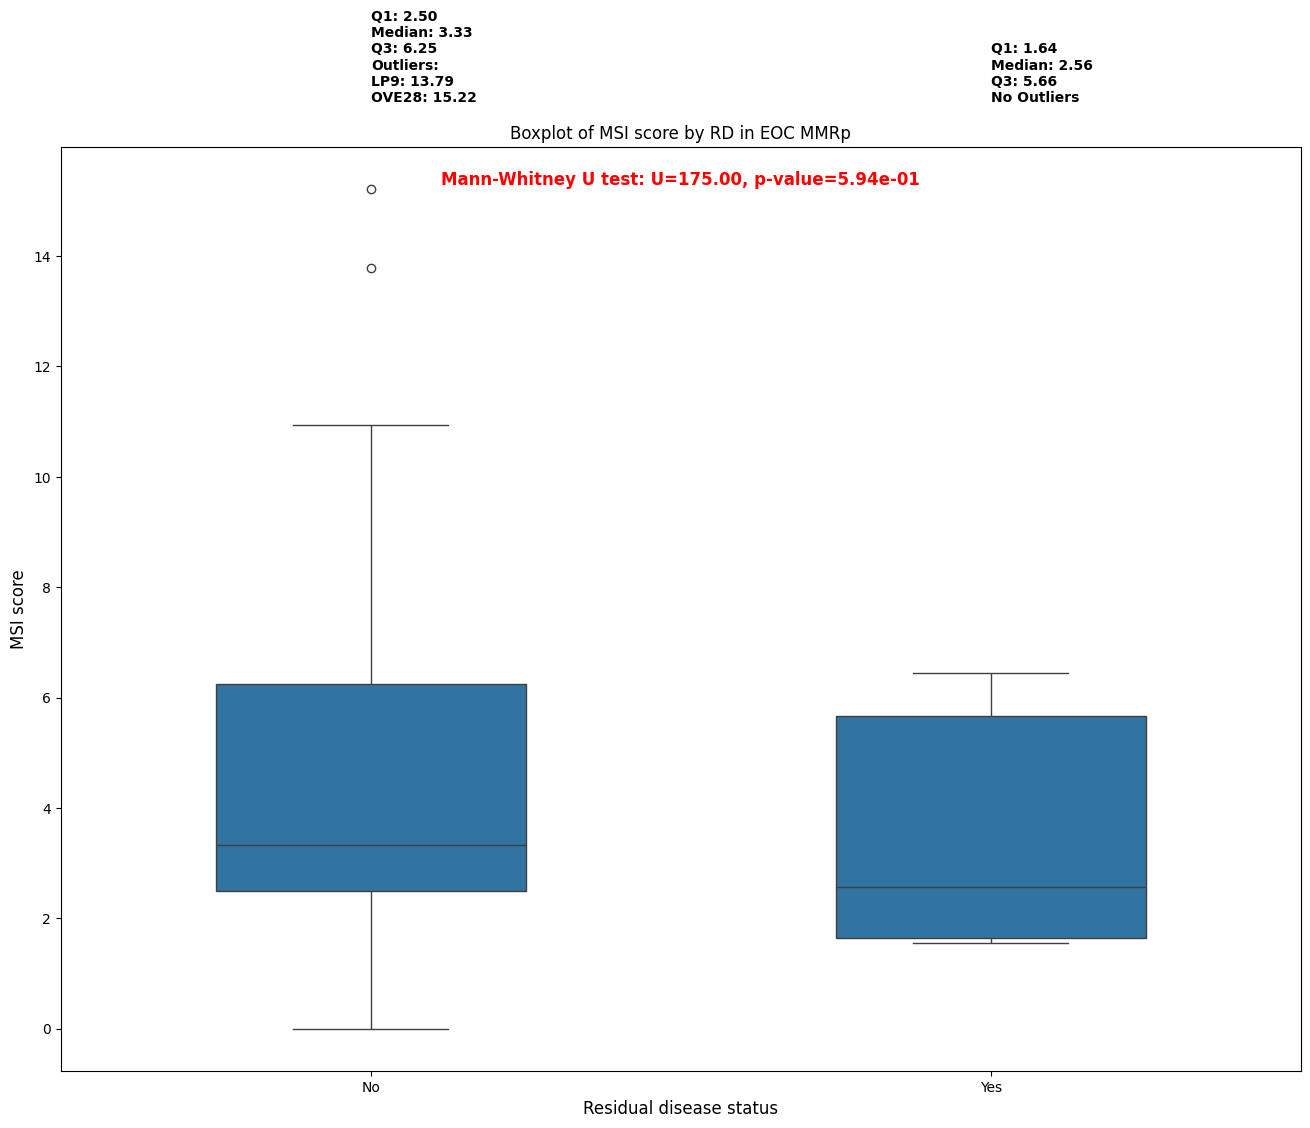

In [55]:
#### Analysis of statistics and distribution of MSI score values in RESIDUALa categories in the EOC MMRp cohort ########

# Uncomment to import if not done previously
#import seaborn as sns  # Library for statistical data visualization
#from scipy.stats import shapiro  # Function to test normality of data (Shapiro-Wilk test)
#from scipy.stats import levene  # Function to test equality of variances (Levene's test)
#from scipy.stats import ttest_ind  # Function for independent two-sample t-test
#from scipy.stats import mannwhitneyu  # Function for Mann-Whitney U test (non-parametric test for two groups)

def analyze_and_plot(df, output_folder, output_file):
    # Filter only "Localized" and "Advanced" categories in FIGOL
    df = df[df['RESIDUALa'].isin(['Yes', 'No'])]

    # Dictionary to store outlier statistics
    outliers_dict = {}

    # Dictionary to store the number of samples in each category
    sample_counts = df['RESIDUALa'].value_counts().to_dict()
    print(f"Number of samples in each category:")
    for category, count in sample_counts.items():
        print(f"{category}: {count}")

    # Create a figure for the boxplot
    plt.figure(figsize=(16, 12))  # Increased size for better visibility
    sns.boxplot(x='RESIDUALa', y='MSI_sensor2', data=df, width=0.5)  # Adjust the width of the boxes
    
    # Variables to store data for 'No' and 'Yes'
    msi_sensor2_residual_no = []
    msi_sensor2_residual_yes = []

    for category in df['RESIDUALa'].unique():
        # Filter data for the current category
        category_data = df[df['RESIDUALa'] == category]

        # Calculate Q1, Q3, and median
        Q1 = category_data['MSI_sensor2'].quantile(0.25)
        Q3 = category_data['MSI_sensor2'].quantile(0.75)
        median = category_data['MSI_sensor2'].median()
        IQR = Q3 - Q1
        
        # Define limits for outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Identify outliers
        outliers = category_data[(category_data['MSI_sensor2'] < lower_bound) | 
                                 (category_data['MSI_sensor2'] > upper_bound)]
        
        # Store outlier IDs and values
        outliers_dict[category] = {
            'Outlier_IDs': outliers['ID_CNIO'].tolist(),
            'Outlier_Values': outliers['MSI_sensor2'].tolist(),
            'Q1': Q1,
            'Q3': Q3,
            'Median': median
        }
        
        # Add data to the corresponding lists
        if category == 'No':
            msi_sensor2_residual_no = category_data['MSI_sensor2'].astype(float).dropna()
        elif category == 'Yes':
            msi_sensor2_residual_yes = category_data['MSI_sensor2'].astype(float).dropna()

    # Perform statistical tests
    if not msi_sensor2_residual_no.empty and not msi_sensor2_residual_yes.empty:
        # Shapiro-Wilk normality test
        shapiro_no = shapiro(msi_sensor2_residual_no)
        shapiro_yes = shapiro(msi_sensor2_residual_yes)
        print(f"Shapiro-Wilk test for No: W={shapiro_no.statistic:.4f}, p-value={shapiro_no.pvalue:.4f}")
        print(f"Shapiro-Wilk test for Yes: W={shapiro_yes.statistic:.4f}, p-value={shapiro_yes.pvalue:.4f}")
        
        # Levene's test for homogeneity of variances
        levene_test = levene(msi_sensor2_residual_no, msi_sensor2_residual_yes)
        print(f"Levene's test: W={levene_test.statistic:.4f}, p-value={levene_test.pvalue:.4f}")
        
        # Select the appropriate test
        if shapiro_no.pvalue > 0.05 and shapiro_yes.pvalue > 0.05 and levene_test.pvalue > 0.05:
            # T-test
            t_test = ttest_ind(msi_sensor2_residual_no, msi_sensor2_residual_yes)
            test_result = f"T-test: t={t_test.statistic:.2f}, p-value={t_test.pvalue:.2e}"  # .2e for scientific notation
        else:
            # Mann-Whitney U test
            mannwhitney_test = mannwhitneyu(msi_sensor2_residual_no, msi_sensor2_residual_yes, alternative='two-sided')
            test_result = f"Mann-Whitney U test: U={mannwhitney_test.statistic:.2f}, p-value={mannwhitney_test.pvalue:.2e}"
        
        # Add the test result to the plot
        plt.gca().text(
            x=0.5, y=df['MSI_sensor2'].max(), 
            s=test_result,
            horizontalalignment='center', verticalalignment='bottom', 
            fontsize=12, color='red', 
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', boxstyle='round,pad=0.5'),
            weight='bold'
        )

    # Add text with outliers, Q1, Q3, and Median
    for category, stats in outliers_dict.items():
        sorted_outliers = sorted(zip(stats['Outlier_IDs'], stats['Outlier_Values']), key=lambda x: x[1])
        outlier_text = 'Outliers:\n' + '\n'.join([f'{id_}: {val:.2f}' for id_, val in sorted_outliers]) if stats['Outlier_Values'] else 'No Outliers'
        
        # Always include Q1, Median, and Q3 in the text box
        summary_stats_text = f"Q1: {stats['Q1']:.2f}\nMedian: {stats['Median']:.2f}\nQ3: {stats['Q3']:.2f}\n{outlier_text}"
        
        x_pos = df['RESIDUALa'].unique().tolist().index(category)
        plt.gca().text(
            x=x_pos, 
            y=df['MSI_sensor2'].max() + 0.1 * (df['MSI_sensor2'].max() - df['MSI_sensor2'].min()), 
            s=summary_stats_text,
            horizontalalignment='left', verticalalignment='bottom', 
            fontsize=10, color='black',
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.5'),
            weight='bold'
        )
    
    # Set title and labels for the plot
    plt.title('Boxplot of MSI score by RD in EOC MMRp', fontsize=12)
    plt.xlabel('Residual disease status', fontsize=12)
    plt.ylabel('MSI score', fontsize=12)
    
    # Save the plot as a PDF file
    plt.savefig(f'{output_folder}/{output_file}', format='pdf', bbox_inches='tight')
    
    # Show the plot
    plt.show()

# Define output folder and file and call the function
output_folder = '/home/vant/TFM/Plots_TFM_final/'
output_file = 'Boxplot_EOC_MMRp_MSIscore_by_RD.pdf'  
analyze_and_plot(df_eoc_mmrp, output_folder, output_file)

Number of samples in each category:
No: 41
Yes: 14
Shapiro-Wilk test for No: W=0.9399, p-value=0.0311
Shapiro-Wilk test for Yes: W=0.7419, p-value=0.0010
Levene's test: W=0.0002, p-value=0.9902


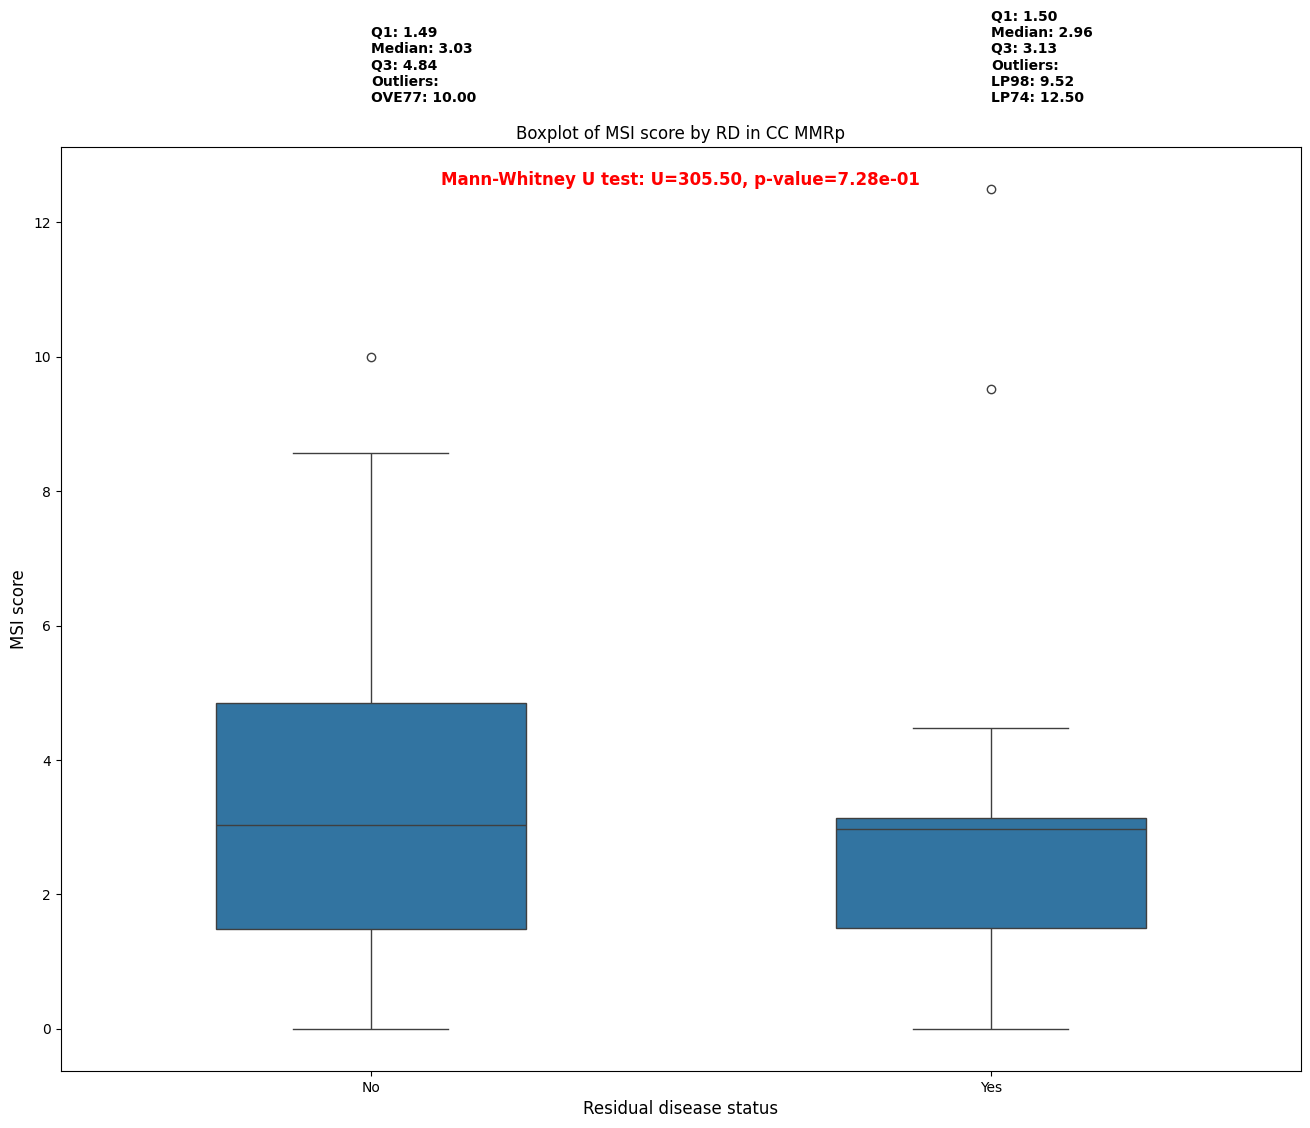

In [56]:
#### Analysis of statistics and distribution of MSI score values in RESIDUALa categories in the CCOC MMRp cohort ########

# Uncomment to import if not done previously
#import seaborn as sns  # Library for statistical data visualization
#from scipy.stats import shapiro  # Function to test normality of data (Shapiro-Wilk test)
#from scipy.stats import levene  # Function to test equality of variances (Levene's test)
#from scipy.stats import ttest_ind  # Function for independent two-sample t-test
#from scipy.stats import mannwhitneyu  # Function for Mann-Whitney U test (non-parametric test for two groups)

def analyze_and_plot(df, output_folder, output_file):
    # Filter only "Localized" and "Advanced" categories in FIGOL
    df = df[df['RESIDUALa'].isin(['Yes', 'No'])]

    # Dictionary to store outlier statistics
    outliers_dict = {}

    # Dictionary to store the number of samples in each category
    sample_counts = df['RESIDUALa'].value_counts().to_dict()
    print(f"Number of samples in each category:")
    for category, count in sample_counts.items():
        print(f"{category}: {count}")

    # Create a figure for the boxplot
    plt.figure(figsize=(16, 12))  # Increased size for better visibility
    sns.boxplot(x='RESIDUALa', y='MSI_sensor2', data=df, width=0.5)  # Adjust the width of the boxes
    
    # Variables to store data for 'No' and 'Yes'
    msi_sensor2_residual_no = []
    msi_sensor2_residual_yes = []

    for category in df['RESIDUALa'].unique():
        # Filter data for the current category
        category_data = df[df['RESIDUALa'] == category]

        # Calculate Q1, Q3, and median
        Q1 = category_data['MSI_sensor2'].quantile(0.25)
        Q3 = category_data['MSI_sensor2'].quantile(0.75)
        median = category_data['MSI_sensor2'].median()
        IQR = Q3 - Q1
        
        # Define limits for outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Identify outliers
        outliers = category_data[(category_data['MSI_sensor2'] < lower_bound) | 
                                 (category_data['MSI_sensor2'] > upper_bound)]
        
        # Store outlier IDs and values
        outliers_dict[category] = {
            'Outlier_IDs': outliers['ID_CNIO'].tolist(),
            'Outlier_Values': outliers['MSI_sensor2'].tolist(),
            'Q1': Q1,
            'Q3': Q3,
            'Median': median
        }
        
        # Add data to the corresponding lists
        if category == 'No':
            msi_sensor2_residual_no = category_data['MSI_sensor2'].astype(float).dropna()
        elif category == 'Yes':
            msi_sensor2_residual_yes = category_data['MSI_sensor2'].astype(float).dropna()

    # Perform statistical tests
    if not msi_sensor2_residual_no.empty and not msi_sensor2_residual_yes.empty:
        # Shapiro-Wilk normality test
        shapiro_no = shapiro(msi_sensor2_residual_no)
        shapiro_yes = shapiro(msi_sensor2_residual_yes)
        print(f"Shapiro-Wilk test for No: W={shapiro_no.statistic:.4f}, p-value={shapiro_no.pvalue:.4f}")
        print(f"Shapiro-Wilk test for Yes: W={shapiro_yes.statistic:.4f}, p-value={shapiro_yes.pvalue:.4f}")
        
        # Levene's test for homogeneity of variances
        levene_test = levene(msi_sensor2_residual_no, msi_sensor2_residual_yes)
        print(f"Levene's test: W={levene_test.statistic:.4f}, p-value={levene_test.pvalue:.4f}")
        
        # Select the appropriate test
        if shapiro_no.pvalue > 0.05 and shapiro_yes.pvalue > 0.05 and levene_test.pvalue > 0.05:
            # T-test
            t_test = ttest_ind(msi_sensor2_residual_no, msi_sensor2_residual_yes)
            test_result = f"T-test: t={t_test.statistic:.2f}, p-value={t_test.pvalue:.2e}"  # .2e for scientific notation
        else:
            # Mann-Whitney U test
            mannwhitney_test = mannwhitneyu(msi_sensor2_residual_no, msi_sensor2_residual_yes, alternative='two-sided')
            test_result = f"Mann-Whitney U test: U={mannwhitney_test.statistic:.2f}, p-value={mannwhitney_test.pvalue:.2e}"
        
        # Add the test result to the plot
        plt.gca().text(
            x=0.5, y=df['MSI_sensor2'].max(), 
            s=test_result,
            horizontalalignment='center', verticalalignment='bottom', 
            fontsize=12, color='red', 
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', boxstyle='round,pad=0.5'),
            weight='bold'
        )

    # Add text with outliers, Q1, Q3, and Median
    for category, stats in outliers_dict.items():
        sorted_outliers = sorted(zip(stats['Outlier_IDs'], stats['Outlier_Values']), key=lambda x: x[1])
        outlier_text = 'Outliers:\n' + '\n'.join([f'{id_}: {val:.2f}' for id_, val in sorted_outliers]) if stats['Outlier_Values'] else 'No Outliers'
        
        # Always include Q1, Median, and Q3 in the text box
        summary_stats_text = f"Q1: {stats['Q1']:.2f}\nMedian: {stats['Median']:.2f}\nQ3: {stats['Q3']:.2f}\n{outlier_text}"
        
        x_pos = df['RESIDUALa'].unique().tolist().index(category)
        plt.gca().text(
            x=x_pos, 
            y=df['MSI_sensor2'].max() + 0.1 * (df['MSI_sensor2'].max() - df['MSI_sensor2'].min()), 
            s=summary_stats_text,
            horizontalalignment='left', verticalalignment='bottom', 
            fontsize=10, color='black',
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.5'),
            weight='bold'
        )
    
    # Set title and labels for the plot
    plt.title('Boxplot of MSI score by RD in CC MMRp', fontsize=12)
    plt.xlabel('Residual disease status', fontsize=12)
    plt.ylabel('MSI score', fontsize=12)
    
    # Save the plot as a PDF file
    plt.savefig(f'{output_folder}/{output_file}', format='pdf', bbox_inches='tight')
    
    # Show the plot
    plt.show()

# Define output folder and file and call the function
output_folder = '/home/vant/TFM/Plots_TFM_final/' 
output_file = 'Boxplot_CC_MMRp_MSIscore_by_RD.pdf'  
analyze_and_plot(df_cc_mmrp, output_folder, output_file)

Number of samples in each category:
No: 102
Yes: 19
Shapiro-Wilk test for No: W=0.8418, p-value=0.0000
Shapiro-Wilk test for Yes: W=0.9309, p-value=0.1796
Levene's test: W=0.4819, p-value=0.4889


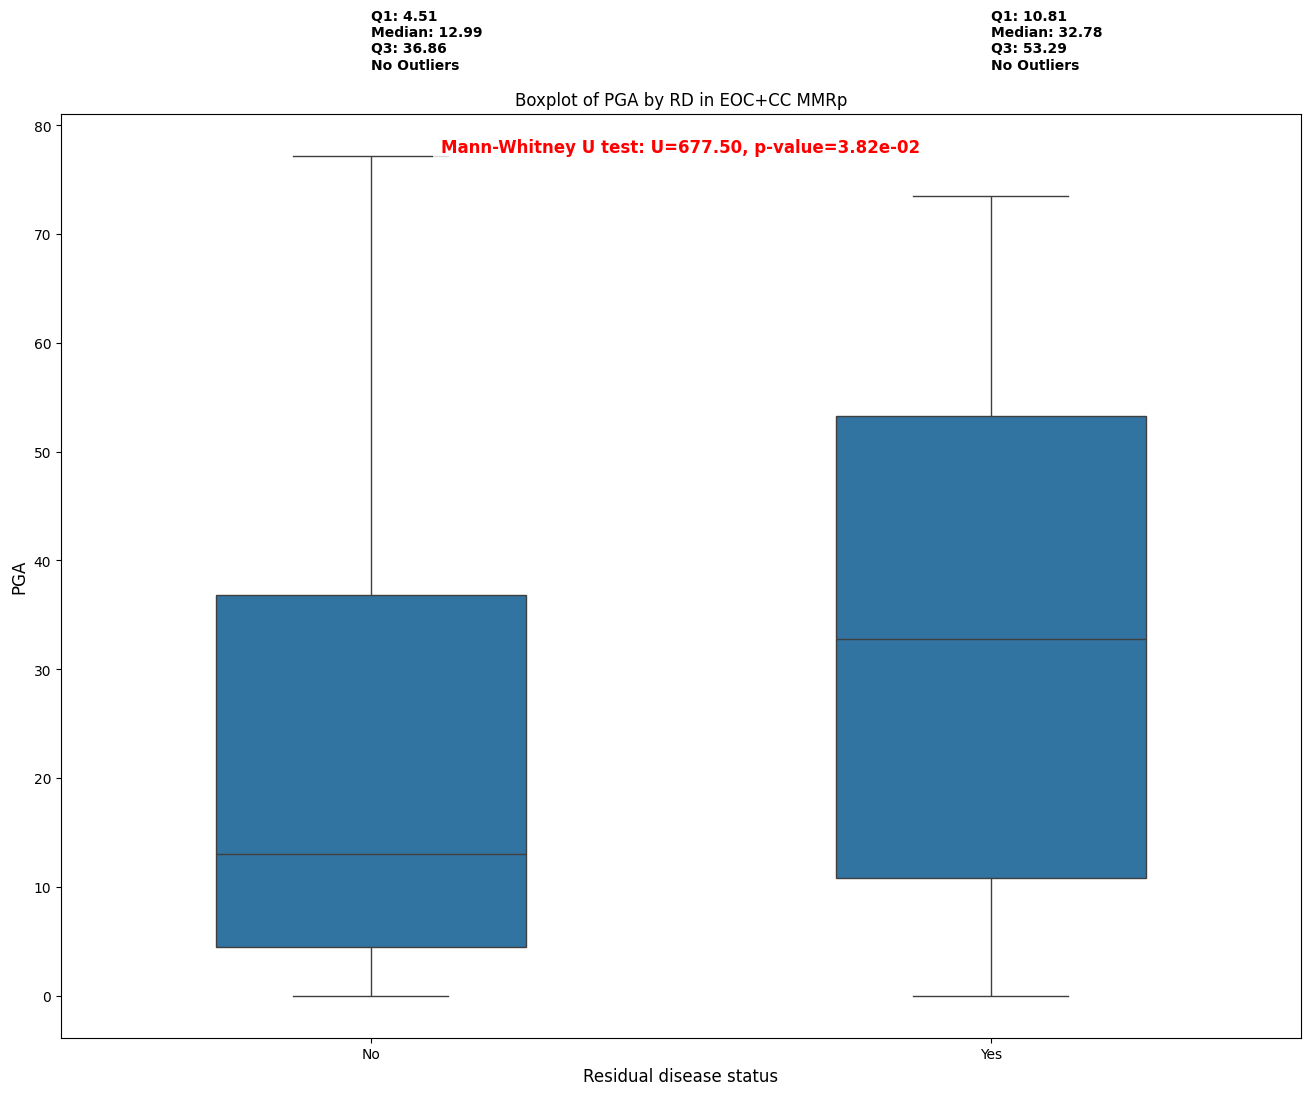

In [57]:
#### Analysis of statistics and distribution of percentage of genome altered values in RESIDUALa categories in the entire MMRp cohort ########

# Uncomment to import if not done previously
#import seaborn as sns  # Library for statistical data visualization
#from scipy.stats import shapiro  # Function to test normality of data (Shapiro-Wilk test)
#from scipy.stats import levene  # Function to test equality of variances (Levene's test)
#from scipy.stats import ttest_ind  # Function for independent two-sample t-test
#from scipy.stats import mannwhitneyu  # Function for Mann-Whitney U test (non-parametric test for two groups)

def analyze_and_plot(df, output_folder, output_file):
    # Filter only "Localized" and "Advanced" categories in FIGOL
    df = df[df['RESIDUALa'].isin(['Yes', 'No'])]

    # Dictionary to store outlier statistics
    outliers_dict = {}

    # Dictionary to store the number of samples in each category
    sample_counts = df['RESIDUALa'].value_counts().to_dict()
    print(f"Number of samples in each category:")
    for category, count in sample_counts.items():
        print(f"{category}: {count}")

    # Create a figure for the boxplot
    plt.figure(figsize=(16, 12))  # Increased size for better visibility
    sns.boxplot(x='RESIDUALa', y='%genome_altered', data=df, width=0.5)  # Adjust the width of the boxes
    
    # Variables to store data for 'No' and 'Yes'
    genome_altered_residual_no = []
    genome_altered_residual_yes = []

    for category in df['RESIDUALa'].unique():
        # Filter data for the current category
        category_data = df[df['RESIDUALa'] == category]

        # Calculate Q1, Q3, and median
        Q1 = category_data['%genome_altered'].quantile(0.25)
        Q3 = category_data['%genome_altered'].quantile(0.75)
        median = category_data['%genome_altered'].median()
        IQR = Q3 - Q1
        
        # Define limits for outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Identify outliers
        outliers = category_data[(category_data['%genome_altered'] < lower_bound) | 
                                 (category_data['%genome_altered'] > upper_bound)]
        
        # Store outlier IDs and values
        outliers_dict[category] = {
            'Outlier_IDs': outliers['ID_CNIO'].tolist(),
            'Outlier_Values': outliers['%genome_altered'].tolist(),
            'Q1': Q1,
            'Q3': Q3,
            'Median': median
        }
        
        # Add data to the corresponding lists
        if category == 'No':
            genome_altered_residual_no = category_data['%genome_altered'].astype(float).dropna()
        elif category == 'Yes':
            genome_altered_residual_yes = category_data['%genome_altered'].astype(float).dropna()

    # Perform statistical tests
    if not genome_altered_residual_no.empty and not genome_altered_residual_yes.empty:
        # Shapiro-Wilk normality test
        shapiro_no = shapiro(genome_altered_residual_no)
        shapiro_yes = shapiro(genome_altered_residual_yes)
        print(f"Shapiro-Wilk test for No: W={shapiro_no.statistic:.4f}, p-value={shapiro_no.pvalue:.4f}")
        print(f"Shapiro-Wilk test for Yes: W={shapiro_yes.statistic:.4f}, p-value={shapiro_yes.pvalue:.4f}")
        
        # Levene's test for homogeneity of variances
        levene_test = levene(genome_altered_residual_no, genome_altered_residual_yes)
        print(f"Levene's test: W={levene_test.statistic:.4f}, p-value={levene_test.pvalue:.4f}")
        
        # Select the appropriate test
        if shapiro_no.pvalue > 0.05 and shapiro_yes.pvalue > 0.05 and levene_test.pvalue > 0.05:
            # T-test
            t_test = ttest_ind(genome_altered_residual_no, genome_altered_residual_yes)
            test_result = f"T-test: t={t_test.statistic:.2f}, p-value={t_test.pvalue:.2e}"  # .2e for scientific notation
        else:
            # Mann-Whitney U test
            mannwhitney_test = mannwhitneyu(genome_altered_residual_no, genome_altered_residual_yes, alternative='two-sided')
            test_result = f"Mann-Whitney U test: U={mannwhitney_test.statistic:.2f}, p-value={mannwhitney_test.pvalue:.2e}"
        
        # Add the test result to the plot
        plt.gca().text(
            x=0.5, y=df['%genome_altered'].max(), 
            s=test_result,
            horizontalalignment='center', verticalalignment='bottom', 
            fontsize=12, color='red', 
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', boxstyle='round,pad=0.5'),
            weight='bold'
        )

    # Add text with outliers, Q1, Q3, and Median
    for category, stats in outliers_dict.items():
        sorted_outliers = sorted(zip(stats['Outlier_IDs'], stats['Outlier_Values']), key=lambda x: x[1])
        outlier_text = 'Outliers:\n' + '\n'.join([f'{id_}: {val:.2f}' for id_, val in sorted_outliers]) if stats['Outlier_Values'] else 'No Outliers'
        
        # Always include Q1, Median, and Q3 in the text box
        summary_stats_text = f"Q1: {stats['Q1']:.2f}\nMedian: {stats['Median']:.2f}\nQ3: {stats['Q3']:.2f}\n{outlier_text}"
        
        x_pos = df['RESIDUALa'].unique().tolist().index(category)
        plt.gca().text(
            x=x_pos, 
            y=df['%genome_altered'].max() + 0.1 * (df['%genome_altered'].max() - df['%genome_altered'].min()), 
            s=summary_stats_text,
            horizontalalignment='left', verticalalignment='bottom', 
            fontsize=10, color='black',
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.5'),
            weight='bold'
        )
    
    # Set title and labels for the plot
    plt.title('Boxplot of PGA by RD in EOC+CC MMRp', fontsize=12)
    plt.xlabel('Residual disease status', fontsize=12)
    plt.ylabel('PGA', fontsize=12)
    
    # Save the plot as a PDF file
    plt.savefig(f'{output_folder}/{output_file}', format='pdf', bbox_inches='tight')
    
    # Show the plot
    plt.show()

#  Define output folder and file and call the function
output_folder = '/home/vant/TFM/Plots_TFM_final/' 
output_file = 'Boxplot_MMRp_PGA_by_RD.pdf'  
analyze_and_plot(df_all_mmrp, output_folder, output_file)

Number of samples in each category:
No: 61
Yes: 5
Shapiro-Wilk test for No: W=0.8392, p-value=0.0000
Shapiro-Wilk test for Yes: W=0.9045, p-value=0.4354
Levene's test: W=0.3908, p-value=0.5341


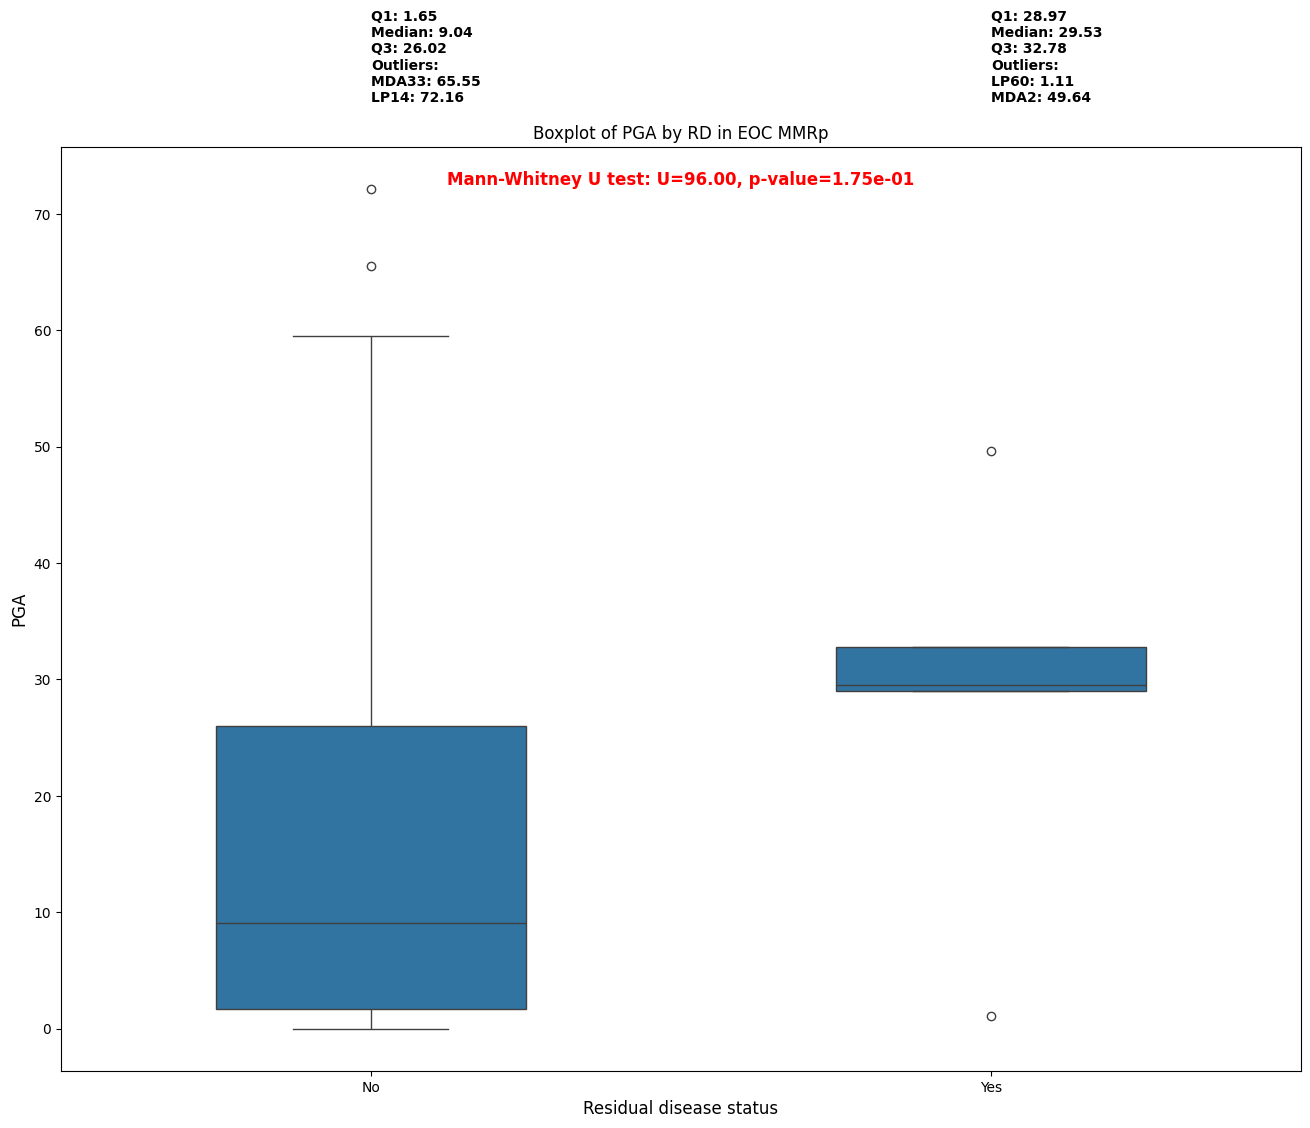

In [58]:
#### Analysis of statistics and distribution of percentage of genome altered values in RESIDUALa categories in the EOC MMRp cohort ######

# Uncomment to import if not done previously
#import seaborn as sns  # Library for statistical data visualization
#from scipy.stats import shapiro  # Function to test normality of data (Shapiro-Wilk test)
#from scipy.stats import levene  # Function to test equality of variances (Levene's test)
#from scipy.stats import ttest_ind  # Function for independent two-sample t-test
#from scipy.stats import mannwhitneyu  # Function for Mann-Whitney U test (non-parametric test for two groups)

def analyze_and_plot(df, output_folder, output_file):
    # Filter only "Localized" and "Advanced" categories in FIGOL
    df = df[df['RESIDUALa'].isin(['Yes', 'No'])]

    # Dictionary to store outlier statistics
    outliers_dict = {}

    # Dictionary to store the number of samples in each category
    sample_counts = df['RESIDUALa'].value_counts().to_dict()
    print(f"Number of samples in each category:")
    for category, count in sample_counts.items():
        print(f"{category}: {count}")

    # Create a figure for the boxplot
    plt.figure(figsize=(16, 12))  # Increased size for better visibility
    sns.boxplot(x='RESIDUALa', y='%genome_altered', data=df, width=0.5)  # Adjust the width of the boxes
    
    # Variables to store data for 'No' and 'Yes'
    genome_altered_residual_no = []
    genome_altered_residual_yes = []

    for category in df['RESIDUALa'].unique():
        # Filter data for the current category
        category_data = df[df['RESIDUALa'] == category]

        # Calculate Q1, Q3, and median
        Q1 = category_data['%genome_altered'].quantile(0.25)
        Q3 = category_data['%genome_altered'].quantile(0.75)
        median = category_data['%genome_altered'].median()
        IQR = Q3 - Q1
        
        # Define limits for outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Identify outliers
        outliers = category_data[(category_data['%genome_altered'] < lower_bound) | 
                                 (category_data['%genome_altered'] > upper_bound)]
        
        # Store outlier IDs and values
        outliers_dict[category] = {
            'Outlier_IDs': outliers['ID_CNIO'].tolist(),
            'Outlier_Values': outliers['%genome_altered'].tolist(),
            'Q1': Q1,
            'Q3': Q3,
            'Median': median
        }
        
        # Add data to the corresponding lists
        if category == 'No':
            genome_altered_residual_no = category_data['%genome_altered'].astype(float).dropna()
        elif category == 'Yes':
            genome_altered_residual_yes = category_data['%genome_altered'].astype(float).dropna()

    # Perform statistical tests
    if not genome_altered_residual_no.empty and not genome_altered_residual_yes.empty:
        # Shapiro-Wilk normality test
        shapiro_no = shapiro(genome_altered_residual_no)
        shapiro_yes = shapiro(genome_altered_residual_yes)
        print(f"Shapiro-Wilk test for No: W={shapiro_no.statistic:.4f}, p-value={shapiro_no.pvalue:.4f}")
        print(f"Shapiro-Wilk test for Yes: W={shapiro_yes.statistic:.4f}, p-value={shapiro_yes.pvalue:.4f}")
        
        # Levene's test for homogeneity of variances
        levene_test = levene(genome_altered_residual_no, genome_altered_residual_yes)
        print(f"Levene's test: W={levene_test.statistic:.4f}, p-value={levene_test.pvalue:.4f}")
        
        # Select the appropriate test
        if shapiro_no.pvalue > 0.05 and shapiro_yes.pvalue > 0.05 and levene_test.pvalue > 0.05:
            # T-test
            t_test = ttest_ind(genome_altered_residual_no, genome_altered_residual_yes)
            test_result = f"T-test: t={t_test.statistic:.2f}, p-value={t_test.pvalue:.2e}"  # .2e for scientific notation
        else:
            # Mann-Whitney U test
            mannwhitney_test = mannwhitneyu(genome_altered_residual_no, genome_altered_residual_yes, alternative='two-sided')
            test_result = f"Mann-Whitney U test: U={mannwhitney_test.statistic:.2f}, p-value={mannwhitney_test.pvalue:.2e}"
        
        # Add the test result to the plot
        plt.gca().text(
            x=0.5, y=df['%genome_altered'].max(), 
            s=test_result,
            horizontalalignment='center', verticalalignment='bottom', 
            fontsize=12, color='red', 
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', boxstyle='round,pad=0.5'),
            weight='bold'
        )

    # Add text with outliers, Q1, Q3, and Median
    for category, stats in outliers_dict.items():
        sorted_outliers = sorted(zip(stats['Outlier_IDs'], stats['Outlier_Values']), key=lambda x: x[1])
        outlier_text = 'Outliers:\n' + '\n'.join([f'{id_}: {val:.2f}' for id_, val in sorted_outliers]) if stats['Outlier_Values'] else 'No Outliers'
        
        # Always include Q1, Median, and Q3 in the text box
        summary_stats_text = f"Q1: {stats['Q1']:.2f}\nMedian: {stats['Median']:.2f}\nQ3: {stats['Q3']:.2f}\n{outlier_text}"
        
        x_pos = df['RESIDUALa'].unique().tolist().index(category)
        plt.gca().text(
            x=x_pos, 
            y=df['%genome_altered'].max() + 0.1 * (df['%genome_altered'].max() - df['%genome_altered'].min()), 
            s=summary_stats_text,
            horizontalalignment='left', verticalalignment='bottom', 
            fontsize=10, color='black',
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.5'),
            weight='bold'
        )
    
    # Set title and labels for the plot
    plt.title('Boxplot of PGA by RD in EOC MMRp', fontsize=12)
    plt.xlabel('Residual disease status', fontsize=12)
    plt.ylabel('PGA', fontsize=12)
    
    # Save the plot as a PDF file
    plt.savefig(f'{output_folder}/{output_file}', format='pdf', bbox_inches='tight')
    
    # Show the plot
    plt.show()

# Define output folder and file and call the function
output_folder = '/home/vant/TFM/Plots_TFM_final/'
output_file = 'Boxplot_EOC_MMRp_PGA_by_RD.pdf'  
analyze_and_plot(df_eoc_mmrp, output_folder, output_file)

Number of samples in each category:
No: 41
Yes: 14
Shapiro-Wilk test for No: W=0.8459, p-value=0.0001
Shapiro-Wilk test for Yes: W=0.8878, p-value=0.0752
Levene's test: W=0.0905, p-value=0.7647


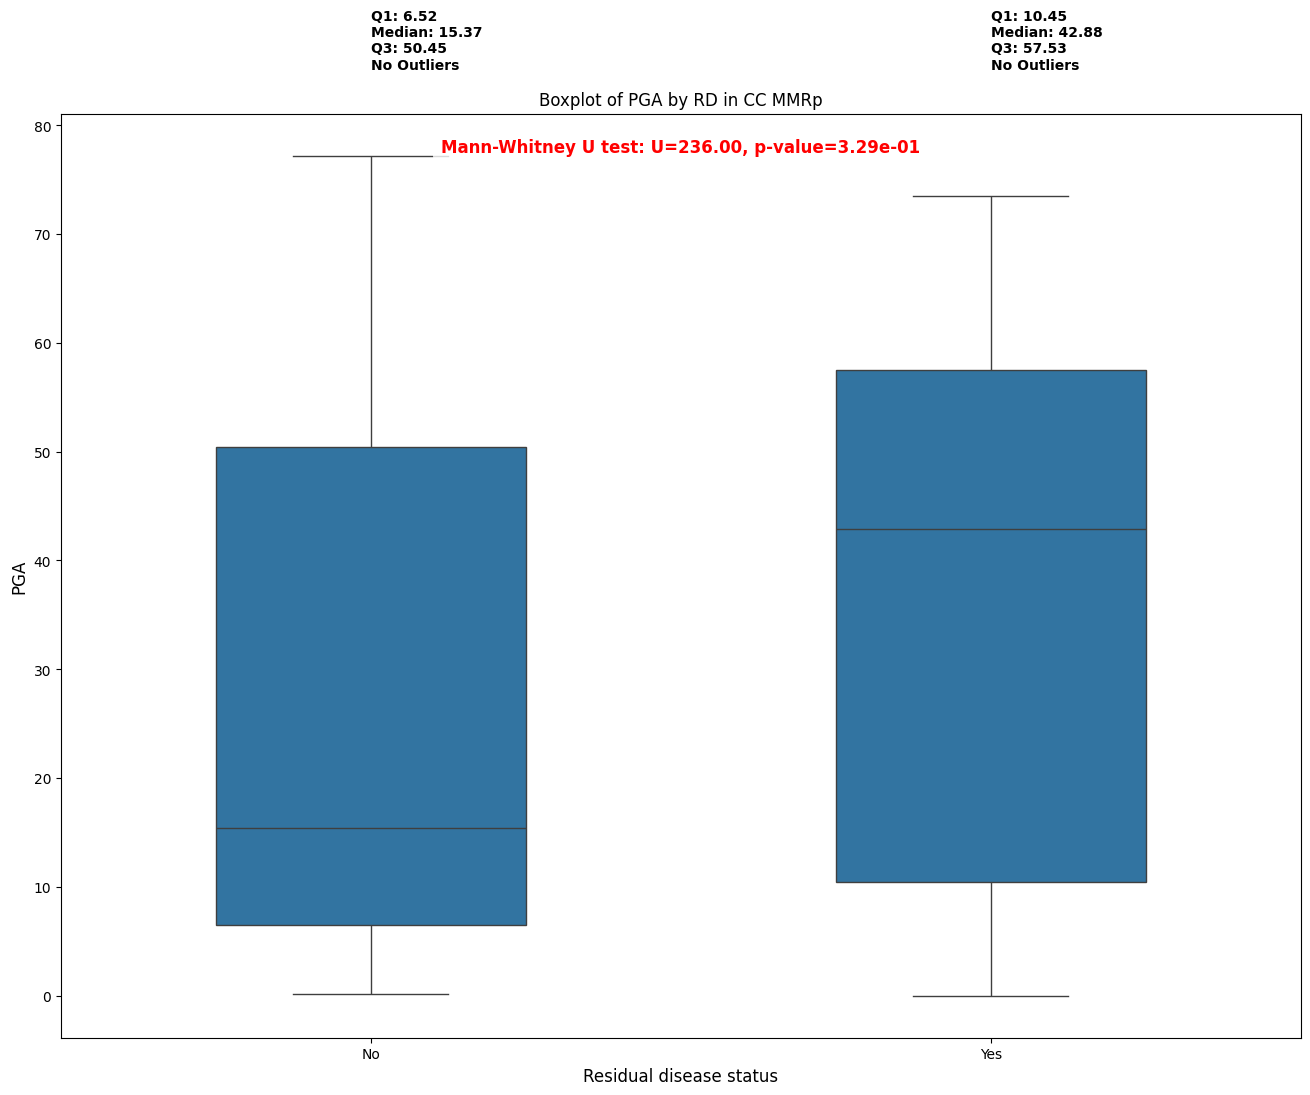

In [59]:
#### Analysis of statistics and distribution of percentage of genome altered values in RESIDUALa categories in the CCOC MMRp cohort ######

# Uncomment to import if not done previously
#import seaborn as sns  # Library for statistical data visualization
#from scipy.stats import shapiro  # Function to test normality of data (Shapiro-Wilk test)
#from scipy.stats import levene  # Function to test equality of variances (Levene's test)
#from scipy.stats import ttest_ind  # Function for independent two-sample t-test
#from scipy.stats import mannwhitneyu  # Function for Mann-Whitney U test (non-parametric test for two groups)

def analyze_and_plot(df, output_folder, output_file):
    # Filter only "Localized" and "Advanced" categories in FIGOL
    df = df[df['RESIDUALa'].isin(['Yes', 'No'])]

    # Dictionary to store outlier statistics
    outliers_dict = {}

    # Dictionary to store the number of samples in each category
    sample_counts = df['RESIDUALa'].value_counts().to_dict()
    print(f"Number of samples in each category:")
    for category, count in sample_counts.items():
        print(f"{category}: {count}")

    # Create a figure for the boxplot
    plt.figure(figsize=(16, 12))  # Increased size for better visibility
    sns.boxplot(x='RESIDUALa', y='%genome_altered', data=df, width=0.5)  # Adjust the width of the boxes
    
    # Variables to store data for 'No' and 'Yes'
    genome_altered_residual_no = []
    genome_altered_residual_yes = []

    for category in df['RESIDUALa'].unique():
        # Filter data for the current category
        category_data = df[df['RESIDUALa'] == category]

        # Calculate Q1, Q3, and median
        Q1 = category_data['%genome_altered'].quantile(0.25)
        Q3 = category_data['%genome_altered'].quantile(0.75)
        median = category_data['%genome_altered'].median()
        IQR = Q3 - Q1
        
        # Define limits for outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Identify outliers
        outliers = category_data[(category_data['%genome_altered'] < lower_bound) | 
                                 (category_data['%genome_altered'] > upper_bound)]
        
        # Store outlier IDs and values
        outliers_dict[category] = {
            'Outlier_IDs': outliers['ID_CNIO'].tolist(),
            'Outlier_Values': outliers['%genome_altered'].tolist(),
            'Q1': Q1,
            'Q3': Q3,
            'Median': median
        }
        
        # Add data to the corresponding lists
        if category == 'No':
            genome_altered_residual_no = category_data['%genome_altered'].astype(float).dropna()
        elif category == 'Yes':
            genome_altered_residual_yes = category_data['%genome_altered'].astype(float).dropna()

    # Perform statistical tests
    if not genome_altered_residual_no.empty and not genome_altered_residual_yes.empty:
        # Shapiro-Wilk normality test
        shapiro_no = shapiro(genome_altered_residual_no)
        shapiro_yes = shapiro(genome_altered_residual_yes)
        print(f"Shapiro-Wilk test for No: W={shapiro_no.statistic:.4f}, p-value={shapiro_no.pvalue:.4f}")
        print(f"Shapiro-Wilk test for Yes: W={shapiro_yes.statistic:.4f}, p-value={shapiro_yes.pvalue:.4f}")
        
        # Levene's test for homogeneity of variances
        levene_test = levene(genome_altered_residual_no, genome_altered_residual_yes)
        print(f"Levene's test: W={levene_test.statistic:.4f}, p-value={levene_test.pvalue:.4f}")
        
        # Select the appropriate test
        if shapiro_no.pvalue > 0.05 and shapiro_yes.pvalue > 0.05 and levene_test.pvalue > 0.05:
            # T-test
            t_test = ttest_ind(genome_altered_residual_no, genome_altered_residual_yes)
            test_result = f"T-test: t={t_test.statistic:.2f}, p-value={t_test.pvalue:.2e}"  # .2e for scientific notation
        else:
            # Mann-Whitney U test
            mannwhitney_test = mannwhitneyu(genome_altered_residual_no, genome_altered_residual_yes, alternative='two-sided')
            test_result = f"Mann-Whitney U test: U={mannwhitney_test.statistic:.2f}, p-value={mannwhitney_test.pvalue:.2e}"
        
        # Add the test result to the plot
        plt.gca().text(
            x=0.5, y=df['%genome_altered'].max(), 
            s=test_result,
            horizontalalignment='center', verticalalignment='bottom', 
            fontsize=12, color='red', 
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', boxstyle='round,pad=0.5'),
            weight='bold'
        )

    # Add text with outliers, Q1, Q3, and Median
    for category, stats in outliers_dict.items():
        sorted_outliers = sorted(zip(stats['Outlier_IDs'], stats['Outlier_Values']), key=lambda x: x[1])
        outlier_text = 'Outliers:\n' + '\n'.join([f'{id_}: {val:.2f}' for id_, val in sorted_outliers]) if stats['Outlier_Values'] else 'No Outliers'
        
        # Always include Q1, Median, and Q3 in the text box
        summary_stats_text = f"Q1: {stats['Q1']:.2f}\nMedian: {stats['Median']:.2f}\nQ3: {stats['Q3']:.2f}\n{outlier_text}"
        
        x_pos = df['RESIDUALa'].unique().tolist().index(category)
        plt.gca().text(
            x=x_pos, 
            y=df['%genome_altered'].max() + 0.1 * (df['%genome_altered'].max() - df['%genome_altered'].min()), 
            s=summary_stats_text,
            horizontalalignment='left', verticalalignment='bottom', 
            fontsize=10, color='black',
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.5'),
            weight='bold'
        )
    
    # Set title and labels for the plot
    plt.title('Boxplot of PGA by RD in CC MMRp', fontsize=12)
    plt.xlabel('Residual disease status', fontsize=12)
    plt.ylabel('PGA', fontsize=12)
    
    # Save the plot as a PDF file
    plt.savefig(f'{output_folder}/{output_file}', format='pdf', bbox_inches='tight')
    
    # Show the plot
    plt.show()

# Define output folder and file and call the function
output_folder = '/home/vant/TFM/Plots_TFM_final/'
output_file = 'Boxplot_CC_MMRp_PGA_by_RD.pdf'  
analyze_and_plot(df_cc_mmrp, output_folder, output_file)

Number of samples in each category:
No: 102
Yes: 19
Shapiro-Wilk test for No: W=0.7853, p-value=0.0000
Shapiro-Wilk test for Yes: W=0.8485, p-value=0.0063
Levene's test: W=12.3122, p-value=0.0006


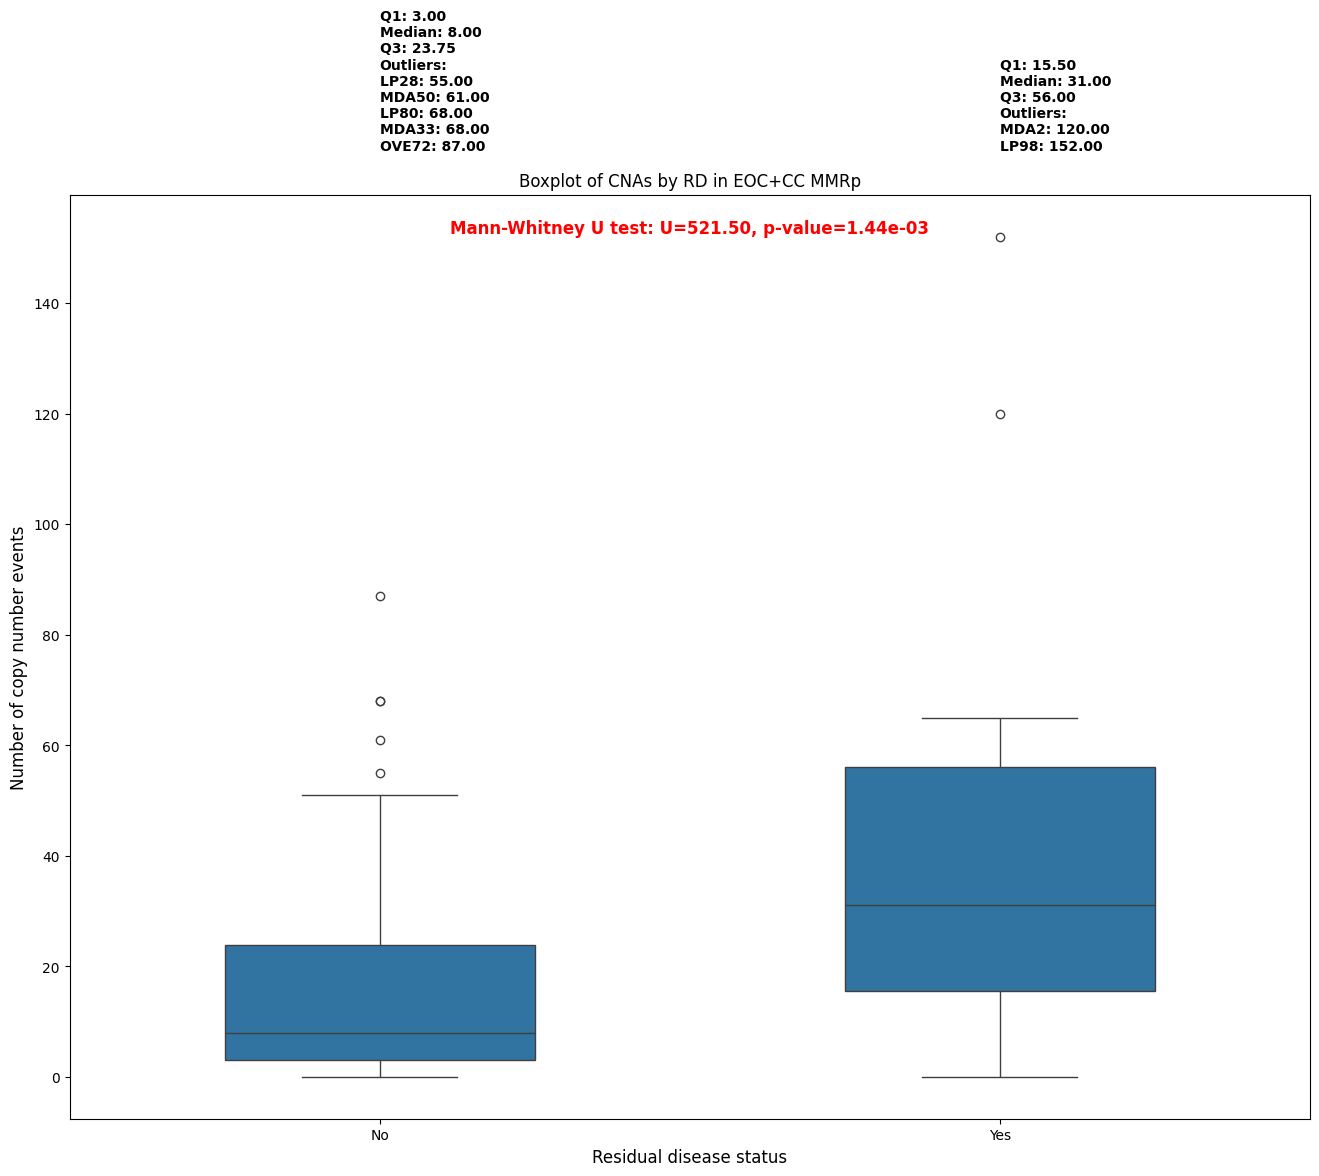

In [60]:
#### Analysis of statistics and distribution of copy number events in RESIDUALa categories in the entire MMRp cohort ######

# Uncomment to import if not done previously
#import seaborn as sns  # Library for statistical data visualization
#from scipy.stats import shapiro  # Function to test normality of data (Shapiro-Wilk test)
#from scipy.stats import levene  # Function to test equality of variances (Levene's test)
#from scipy.stats import ttest_ind  # Function for independent two-sample t-test
#from scipy.stats import mannwhitneyu  # Function for Mann-Whitney U test (non-parametric test for two groups)

def analyze_and_plot(df, output_folder, output_file):
    # Filter only "Localized" and "Advanced" categories in FIGOL
    df = df[df['RESIDUALa'].isin(['Yes', 'No'])]

    # Dictionary to store outlier statistics
    outliers_dict = {}

    # Dictionary to store the number of samples in each category
    sample_counts = df['RESIDUALa'].value_counts().to_dict()
    print(f"Number of samples in each category:")
    for category, count in sample_counts.items():
        print(f"{category}: {count}")

    # Create a figure for the boxplot
    plt.figure(figsize=(16, 12))  # Increased size for better visibility
    sns.boxplot(x='RESIDUALa', y='CNV', data=df, width=0.5)  # Adjust the width of the boxes
    
    # Variables to store data for 'No' and 'Yes'
    cnv_residual_no = []
    cnv_residual_yes = []

    for category in df['RESIDUALa'].unique():
        # Filter data for the current category
        category_data = df[df['RESIDUALa'] == category]

        # Calculate Q1, Q3, and median
        Q1 = category_data['CNV'].quantile(0.25)
        Q3 = category_data['CNV'].quantile(0.75)
        median = category_data['CNV'].median()
        IQR = Q3 - Q1
        
        # Define limits for outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Identify outliers
        outliers = category_data[(category_data['CNV'] < lower_bound) | 
                                 (category_data['CNV'] > upper_bound)]
        
        # Store outlier IDs and values
        outliers_dict[category] = {
            'Outlier_IDs': outliers['ID_CNIO'].tolist(),
            'Outlier_Values': outliers['CNV'].tolist(),
            'Q1': Q1,
            'Q3': Q3,
            'Median': median
        }
        
        # Add data to the corresponding lists
        if category == 'No':
            cnv_residual_no = category_data['CNV'].astype(float).dropna()
        elif category == 'Yes':
            cnv_residual_yes = category_data['CNV'].astype(float).dropna()

    # Perform statistical tests
    if not cnv_residual_no.empty and not cnv_residual_yes.empty:
        # Shapiro-Wilk normality test
        shapiro_no = shapiro(cnv_residual_no)
        shapiro_yes = shapiro(cnv_residual_yes)
        print(f"Shapiro-Wilk test for No: W={shapiro_no.statistic:.4f}, p-value={shapiro_no.pvalue:.4f}")
        print(f"Shapiro-Wilk test for Yes: W={shapiro_yes.statistic:.4f}, p-value={shapiro_yes.pvalue:.4f}")
        
        # Levene's test for homogeneity of variances
        levene_test = levene(cnv_residual_no, cnv_residual_yes)
        print(f"Levene's test: W={levene_test.statistic:.4f}, p-value={levene_test.pvalue:.4f}")
        
        # Select the appropriate test
        if shapiro_no.pvalue > 0.05 and shapiro_yes.pvalue > 0.05 and levene_test.pvalue > 0.05:
            # T-test
            t_test = ttest_ind(cnv_residual_no, cnv_residual_yes)
            test_result = f"T-test: t={t_test.statistic:.2f}, p-value={t_test.pvalue:.2e}"  # .2e for scientific notation
        else:
            # Mann-Whitney U test
            mannwhitney_test = mannwhitneyu(cnv_residual_no, cnv_residual_yes, alternative='two-sided')
            test_result = f"Mann-Whitney U test: U={mannwhitney_test.statistic:.2f}, p-value={mannwhitney_test.pvalue:.2e}"
        
        # Add the test result to the plot
        plt.gca().text(
            x=0.5, y=df['CNV'].max(), 
            s=test_result,
            horizontalalignment='center', verticalalignment='bottom', 
            fontsize=12, color='red', 
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', boxstyle='round,pad=0.5'),
            weight='bold'
        )

    # Add text with outliers, Q1, Q3, and Median
    for category, stats in outliers_dict.items():
        sorted_outliers = sorted(zip(stats['Outlier_IDs'], stats['Outlier_Values']), key=lambda x: x[1])
        outlier_text = 'Outliers:\n' + '\n'.join([f'{id_}: {val:.2f}' for id_, val in sorted_outliers]) if stats['Outlier_Values'] else 'No Outliers'
        
        # Always include Q1, Median, and Q3 in the text box
        summary_stats_text = f"Q1: {stats['Q1']:.2f}\nMedian: {stats['Median']:.2f}\nQ3: {stats['Q3']:.2f}\n{outlier_text}"
        
        x_pos = df['RESIDUALa'].unique().tolist().index(category)
        plt.gca().text(
            x=x_pos, 
            y=df['CNV'].max() + 0.1 * (df['CNV'].max() - df['CNV'].min()), 
            s=summary_stats_text,
            horizontalalignment='left', verticalalignment='bottom', 
            fontsize=10, color='black',
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.5'),
            weight='bold'
        )
    
    # Set title and labels for the plot
    plt.title('Boxplot of CNAs by RD in EOC+CC MMRp', fontsize=12)
    plt.xlabel('Residual disease status', fontsize=12)
    plt.ylabel('Number of copy number events', fontsize=12)
    
    # Save the plot as a PDF file
    plt.savefig(f'{output_folder}/{output_file}', format='pdf', bbox_inches='tight')
    
    # Show the plot
    plt.show()

# Define output folder and file and call the function
output_folder = '/home/vant/TFM/Plots_TFM_final/'
output_file = 'Boxplot_MMRp_CNAs_by_RD.pdf'  
analyze_and_plot(df_all_mmrp, output_folder, output_file)

Number of samples in each category:
No: 61
Yes: 5
Shapiro-Wilk test for No: W=0.7448, p-value=0.0000
Shapiro-Wilk test for Yes: W=0.7468, p-value=0.0278
Levene's test: W=6.0608, p-value=0.0165


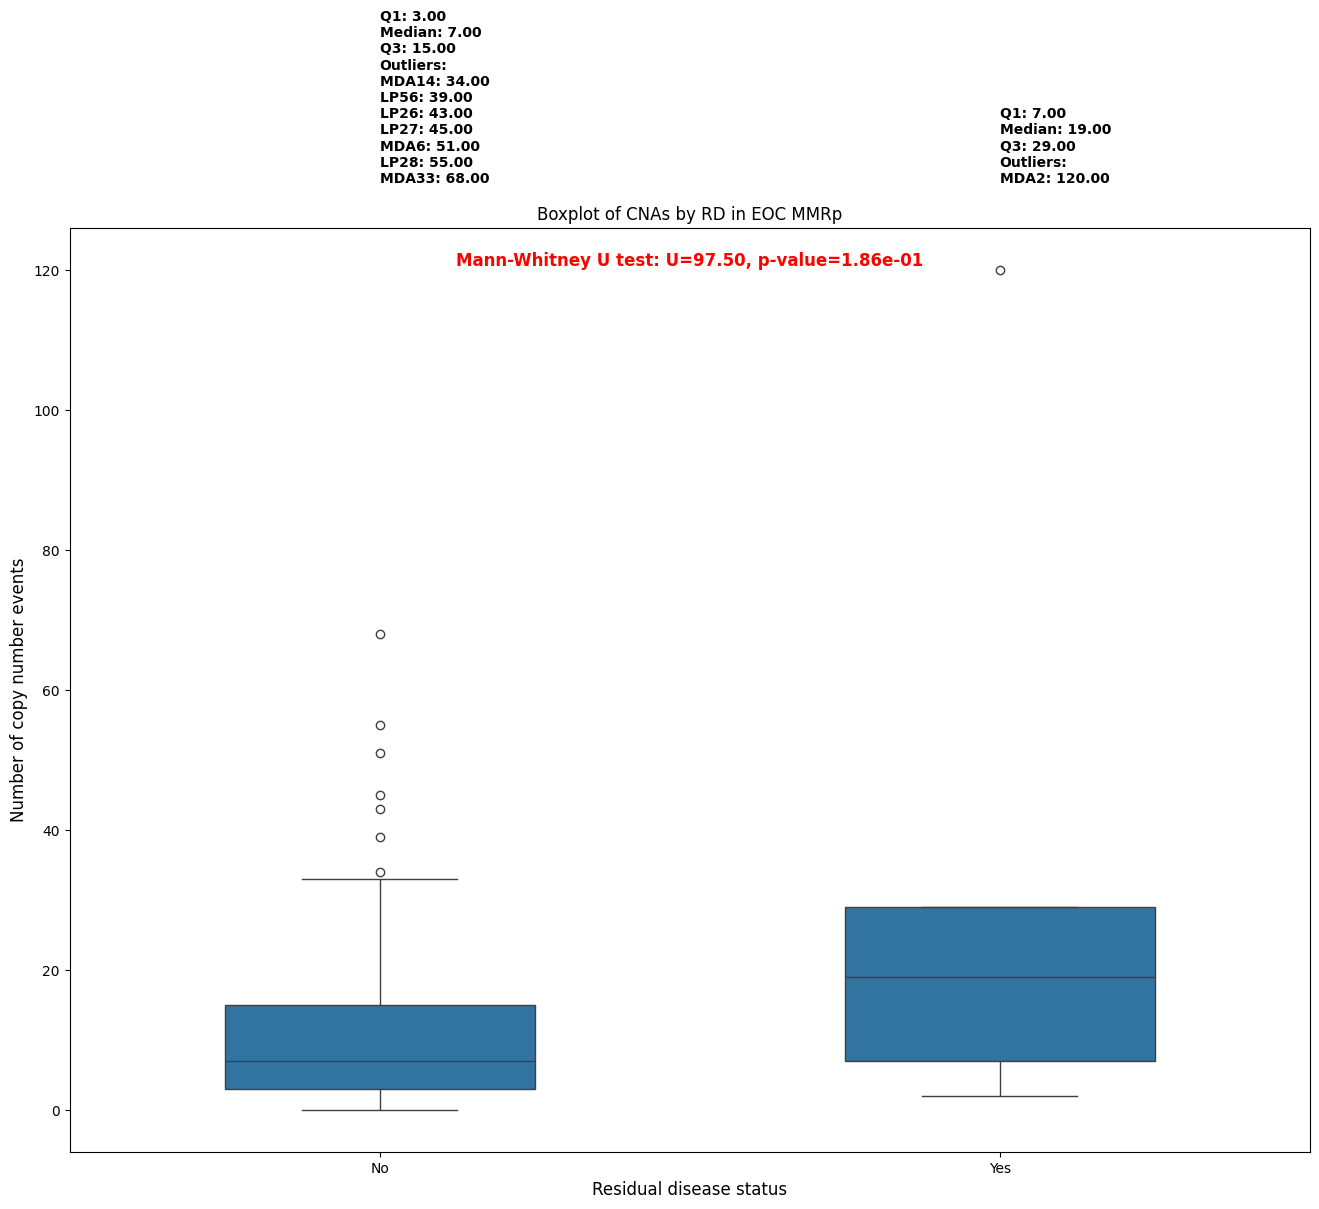

In [61]:
#### Analysis of statistics and distribution of copy number events in RESIDUALa categories in the EOC MMRp cohort ###

# Uncomment to import if not done previously
#import seaborn as sns  # Library for statistical data visualization
#from scipy.stats import shapiro  # Function to test normality of data (Shapiro-Wilk test)
#from scipy.stats import levene  # Function to test equality of variances (Levene's test)
#from scipy.stats import ttest_ind  # Function for independent two-sample t-test
#from scipy.stats import mannwhitneyu  # Function for Mann-Whitney U test (non-parametric test for two groups)

def analyze_and_plot(df, output_folder, output_file):
    # Filter only "Localized" and "Advanced" categories in FIGOL
    df = df[df['RESIDUALa'].isin(['Yes', 'No'])]

    # Dictionary to store outlier statistics
    outliers_dict = {}

    # Dictionary to store the number of samples in each category
    sample_counts = df['RESIDUALa'].value_counts().to_dict()
    print(f"Number of samples in each category:")
    for category, count in sample_counts.items():
        print(f"{category}: {count}")

    # Create a figure for the boxplot
    plt.figure(figsize=(16, 12))  # Increased size for better visibility
    sns.boxplot(x='RESIDUALa', y='CNV', data=df, width=0.5)  # Adjust the width of the boxes
    
    # Variables to store data for 'No' and 'Yes'
    cnv_residual_no = []
    cnv_residual_yes = []

    for category in df['RESIDUALa'].unique():
        # Filter data for the current category
        category_data = df[df['RESIDUALa'] == category]

        # Calculate Q1, Q3, and median
        Q1 = category_data['CNV'].quantile(0.25)
        Q3 = category_data['CNV'].quantile(0.75)
        median = category_data['CNV'].median()
        IQR = Q3 - Q1
        
        # Define limits for outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Identify outliers
        outliers = category_data[(category_data['CNV'] < lower_bound) | 
                                 (category_data['CNV'] > upper_bound)]
        
        # Store outlier IDs and values
        outliers_dict[category] = {
            'Outlier_IDs': outliers['ID_CNIO'].tolist(),
            'Outlier_Values': outliers['CNV'].tolist(),
            'Q1': Q1,
            'Q3': Q3,
            'Median': median
        }
        
        # Add data to the corresponding lists
        if category == 'No':
            cnv_residual_no = category_data['CNV'].astype(float).dropna()
        elif category == 'Yes':
            cnv_residual_yes = category_data['CNV'].astype(float).dropna()

    # Perform statistical tests
    if not cnv_residual_no.empty and not cnv_residual_yes.empty:
        # Shapiro-Wilk normality test
        shapiro_no = shapiro(cnv_residual_no)
        shapiro_yes = shapiro(cnv_residual_yes)
        print(f"Shapiro-Wilk test for No: W={shapiro_no.statistic:.4f}, p-value={shapiro_no.pvalue:.4f}")
        print(f"Shapiro-Wilk test for Yes: W={shapiro_yes.statistic:.4f}, p-value={shapiro_yes.pvalue:.4f}")
        
        # Levene's test for homogeneity of variances
        levene_test = levene(cnv_residual_no, cnv_residual_yes)
        print(f"Levene's test: W={levene_test.statistic:.4f}, p-value={levene_test.pvalue:.4f}")
        
        # Select the appropriate test
        if shapiro_no.pvalue > 0.05 and shapiro_yes.pvalue > 0.05 and levene_test.pvalue > 0.05:
            # T-test
            t_test = ttest_ind(cnv_residual_no, cnv_residual_yes)
            test_result = f"T-test: t={t_test.statistic:.2f}, p-value={t_test.pvalue:.2e}"  # .2e for scientific notation
        else:
            # Mann-Whitney U test
            mannwhitney_test = mannwhitneyu(cnv_residual_no, cnv_residual_yes, alternative='two-sided')
            test_result = f"Mann-Whitney U test: U={mannwhitney_test.statistic:.2f}, p-value={mannwhitney_test.pvalue:.2e}"
        
        # Add the test result to the plot
        plt.gca().text(
            x=0.5, y=df['CNV'].max(), 
            s=test_result,
            horizontalalignment='center', verticalalignment='bottom', 
            fontsize=12, color='red', 
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', boxstyle='round,pad=0.5'),
            weight='bold'
        )

    # Add text with outliers, Q1, Q3, and Median
    for category, stats in outliers_dict.items():
        sorted_outliers = sorted(zip(stats['Outlier_IDs'], stats['Outlier_Values']), key=lambda x: x[1])
        outlier_text = 'Outliers:\n' + '\n'.join([f'{id_}: {val:.2f}' for id_, val in sorted_outliers]) if stats['Outlier_Values'] else 'No Outliers'
        
        # Always include Q1, Median, and Q3 in the text box
        summary_stats_text = f"Q1: {stats['Q1']:.2f}\nMedian: {stats['Median']:.2f}\nQ3: {stats['Q3']:.2f}\n{outlier_text}"
        
        x_pos = df['RESIDUALa'].unique().tolist().index(category)
        plt.gca().text(
            x=x_pos, 
            y=df['CNV'].max() + 0.1 * (df['CNV'].max() - df['CNV'].min()), 
            s=summary_stats_text,
            horizontalalignment='left', verticalalignment='bottom', 
            fontsize=10, color='black',
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.5'),
            weight='bold'
        )
    
    # Set title and labels for the plot
    plt.title('Boxplot of CNAs by RD in EOC MMRp', fontsize=12)
    plt.xlabel('Residual disease status', fontsize=12)
    plt.ylabel('Number of copy number events', fontsize=12)
    
    # Save the plot as a PDF file
    plt.savefig(f'{output_folder}/{output_file}', format='pdf', bbox_inches='tight')
    
    # Show the plot
    plt.show()

# Define output folder and file and call the function
output_folder = '/home/vant/TFM/Plots_TFM_final/'
output_file = 'Boxplot_EOC_MMRp_CNAs_by_RD.pdf'  
analyze_and_plot(df_eoc_mmrp, output_folder, output_file)

Number of samples in each category:
No: 41
Yes: 14
Shapiro-Wilk test for No: W=0.8387, p-value=0.0000
Shapiro-Wilk test for Yes: W=0.8367, p-value=0.0147
Levene's test: W=3.1199, p-value=0.0831


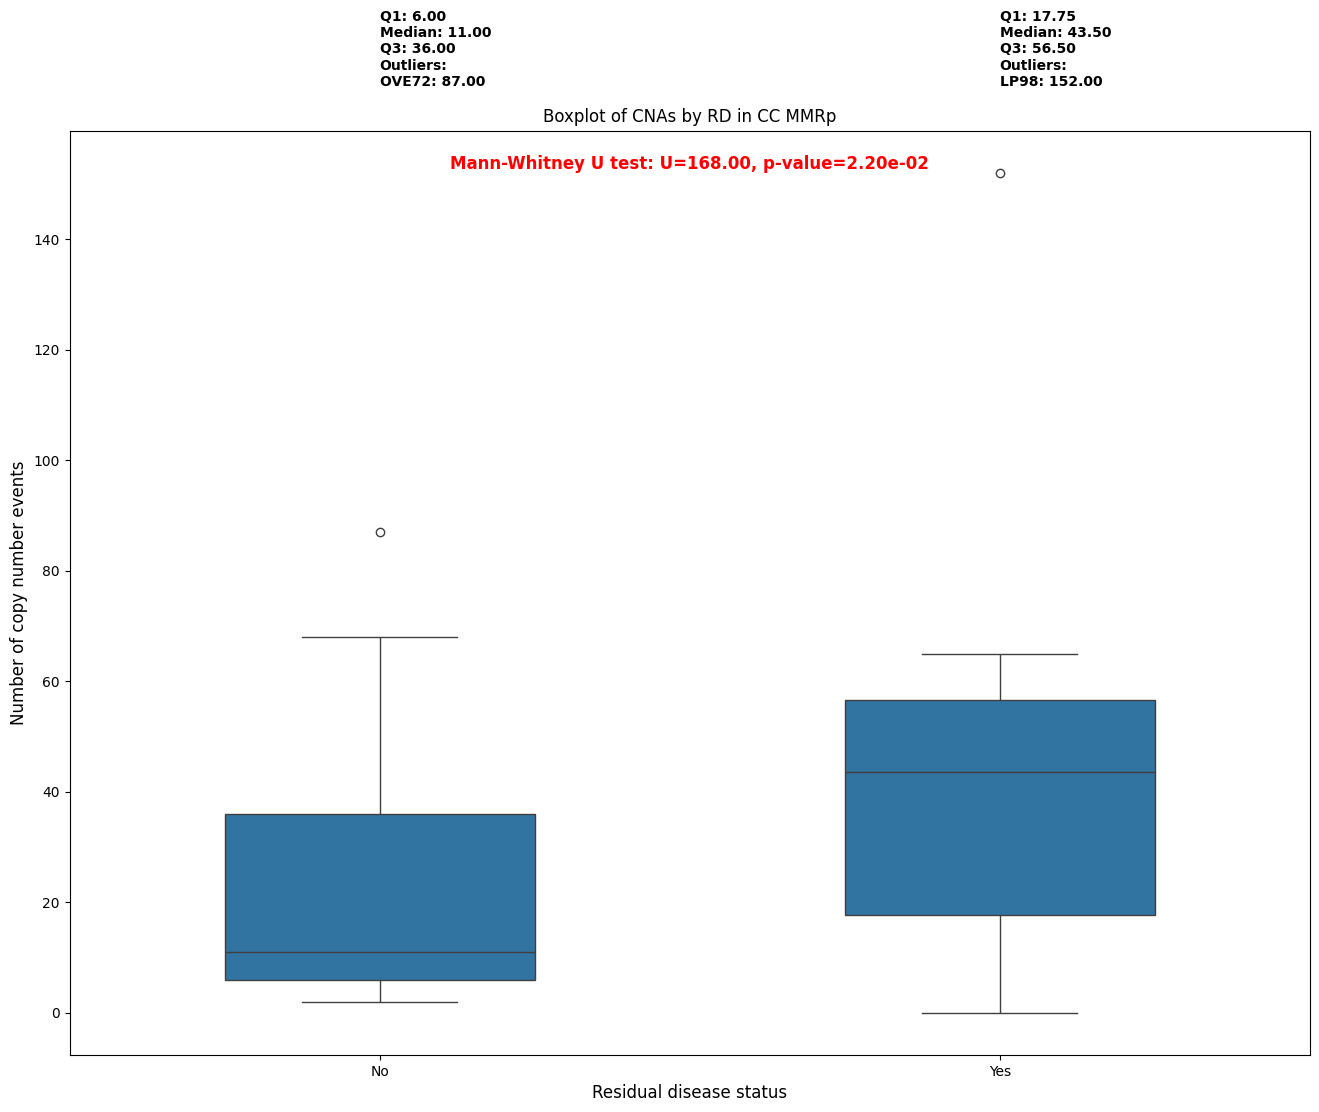

In [62]:
#### Analysis of statistics and distribution of copy number events in RESIDUALa categories in the CCOC MMRp cohort #

# Uncomment to import if not done previously
#import seaborn as sns  # Library for statistical data visualization
#from scipy.stats import shapiro  # Function to test normality of data (Shapiro-Wilk test)
#from scipy.stats import levene  # Function to test equality of variances (Levene's test)
#from scipy.stats import ttest_ind  # Function for independent two-sample t-test
#from scipy.stats import mannwhitneyu  # Function for Mann-Whitney U test (non-parametric test for two groups)

def analyze_and_plot(df, output_folder, output_file):
    # Filter only "Localized" and "Advanced" categories in FIGOL
    df = df[df['RESIDUALa'].isin(['Yes', 'No'])]

    # Dictionary to store outlier statistics
    outliers_dict = {}

    # Dictionary to store the number of samples in each category
    sample_counts = df['RESIDUALa'].value_counts().to_dict()
    print(f"Number of samples in each category:")
    for category, count in sample_counts.items():
        print(f"{category}: {count}")

    # Create a figure for the boxplot
    plt.figure(figsize=(16, 12))  # Increased size for better visibility
    sns.boxplot(x='RESIDUALa', y='CNV', data=df, width=0.5)  # Adjust the width of the boxes
    
    # Variables to store data for 'No' and 'Yes'
    cnv_residual_no = []
    cnv_residual_yes = []

    for category in df['RESIDUALa'].unique():
        # Filter data for the current category
        category_data = df[df['RESIDUALa'] == category]

        # Calculate Q1, Q3, and median
        Q1 = category_data['CNV'].quantile(0.25)
        Q3 = category_data['CNV'].quantile(0.75)
        median = category_data['CNV'].median()
        IQR = Q3 - Q1
        
        # Define limits for outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Identify outliers
        outliers = category_data[(category_data['CNV'] < lower_bound) | 
                                 (category_data['CNV'] > upper_bound)]
        
        # Store outlier IDs and values
        outliers_dict[category] = {
            'Outlier_IDs': outliers['ID_CNIO'].tolist(),
            'Outlier_Values': outliers['CNV'].tolist(),
            'Q1': Q1,
            'Q3': Q3,
            'Median': median
        }
        
        # Add data to the corresponding lists
        if category == 'No':
            cnv_residual_no = category_data['CNV'].astype(float).dropna()
        elif category == 'Yes':
            cnv_residual_yes = category_data['CNV'].astype(float).dropna()

    # Perform statistical tests
    if not cnv_residual_no.empty and not cnv_residual_yes.empty:
        # Shapiro-Wilk normality test
        shapiro_no = shapiro(cnv_residual_no)
        shapiro_yes = shapiro(cnv_residual_yes)
        print(f"Shapiro-Wilk test for No: W={shapiro_no.statistic:.4f}, p-value={shapiro_no.pvalue:.4f}")
        print(f"Shapiro-Wilk test for Yes: W={shapiro_yes.statistic:.4f}, p-value={shapiro_yes.pvalue:.4f}")
        
        # Levene's test for homogeneity of variances
        levene_test = levene(cnv_residual_no, cnv_residual_yes)
        print(f"Levene's test: W={levene_test.statistic:.4f}, p-value={levene_test.pvalue:.4f}")
        
        # Select the appropriate test
        if shapiro_no.pvalue > 0.05 and shapiro_yes.pvalue > 0.05 and levene_test.pvalue > 0.05:
            # T-test
            t_test = ttest_ind(cnv_residual_no, cnv_residual_yes)
            test_result = f"T-test: t={t_test.statistic:.2f}, p-value={t_test.pvalue:.2e}"  # .2e for scientific notation
        else:
            # Mann-Whitney U test
            mannwhitney_test = mannwhitneyu(cnv_residual_no, cnv_residual_yes, alternative='two-sided')
            test_result = f"Mann-Whitney U test: U={mannwhitney_test.statistic:.2f}, p-value={mannwhitney_test.pvalue:.2e}"
        
        # Add the test result to the plot
        plt.gca().text(
            x=0.5, y=df['CNV'].max(), 
            s=test_result,
            horizontalalignment='center', verticalalignment='bottom', 
            fontsize=12, color='red', 
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', boxstyle='round,pad=0.5'),
            weight='bold'
        )

    # Add text with outliers, Q1, Q3, and Median
    for category, stats in outliers_dict.items():
        sorted_outliers = sorted(zip(stats['Outlier_IDs'], stats['Outlier_Values']), key=lambda x: x[1])
        outlier_text = 'Outliers:\n' + '\n'.join([f'{id_}: {val:.2f}' for id_, val in sorted_outliers]) if stats['Outlier_Values'] else 'No Outliers'
        
        # Always include Q1, Median, and Q3 in the text box
        summary_stats_text = f"Q1: {stats['Q1']:.2f}\nMedian: {stats['Median']:.2f}\nQ3: {stats['Q3']:.2f}\n{outlier_text}"
        
        x_pos = df['RESIDUALa'].unique().tolist().index(category)
        plt.gca().text(
            x=x_pos, 
            y=df['CNV'].max() + 0.1 * (df['CNV'].max() - df['CNV'].min()), 
            s=summary_stats_text,
            horizontalalignment='left', verticalalignment='bottom', 
            fontsize=10, color='black',
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.5'),
            weight='bold'
        )
    
    # Set title and labels for the plot
    plt.title('Boxplot of CNAs by RD in CC MMRp', fontsize=12)
    plt.xlabel('Residual disease status', fontsize=12)
    plt.ylabel('Number of copy number events', fontsize=12)
    
    # Save the plot as a PDF file
    plt.savefig(f'{output_folder}/{output_file}', format='pdf', bbox_inches='tight')
    
    # Show the plot
    plt.show()

# Define output folder and file and call the function
output_folder = '/home/vant/TFM/Plots_TFM_final/'
output_file = 'Boxplot_CC_MMRp_CNAs_by_RD.pdf'  
analyze_and_plot(df_cc_mmrp, output_folder, output_file)